###Database Management and Analytics using Google Cloud SQL

This project focuses on leveraging the capabilities of Google Cloud SQL and Google Colab to manage, analyze, and visualize data stored in a SQL Server instance. It covers a wide array of functionalities that not only involve basic table creation and data insertion but also extend to advanced queries, data manipulation, and procedural automation. Below are some of the real-world applications and benefits of this multi-faceted project:

Real-Life Uses:
Business Analytics: This setup can help businesses understand their customer behavior better by performing complex queries like calculating total purchases and discounts or determining product popularity.

Inventory Management: With functionalities like 'Top5BestSelling' views and stored procedures to update product discounts, businesses can make informed decisions regarding stock replenishment and pricing strategies.

Security: Features such as card masking and password updating by email offer enhanced security measures in line with best practices for data management.

Financial Auditing: The ability to display various formats of product prices, orders, and customer spending can facilitate easier auditing and compliance checks.

Customer Relationship Management (CRM): This platform offers multiple ways to better understand customer interactions with the business, ranging from sorting them by last name to identifying their smallest and largest orders.

E-Commerce: Displaying shipping details, verifying new customer entries, and tracking order statuses are essential functionalities for maintaining a reliable e-commerce platform.

Key Functions:
Initial Setup and Management: Establish a SQL Server Instance in Google Cloud SQL, accessible from Google Colab.

Data Manipulation: Functions to create tables and insert data, covering tables like 'Orders' and 'Customers.'

Data Querying and Visualization: Various types of queries like sorting, filtering, and calculating are carried out on tables. Examples include filtering customers by last name, displaying orders sorted by shipping date, and calculating total purchase values.

Advanced Queries and Views: Creation of more advanced SQL views and functionalities like 'Order Item Product Details' and 'Top5BestSelling' to serve complex analytical needs.

Stored Procedures and Automation: Setting up and testing stored procedures for tasks like updating product discounts.

Data Formatting and Security: Functions to display data in multiple formats and mask sensitive information like card details.

Data Validation and Updating: Functions to add and verify new customer entries and to update and verify customer passwords.

Mathematical and Financial Calculations: Functions to perform mathematical operations like finding common divisors and calculating discounted prices.

This project serves as a robust solution for database management and analytics, tailored for both small and large-scale operations. By leveraging Google's cloud capabilities, it offers a scalable, secure, and versatile platform for a variety of real-world applications in business and data analytics.

###Google Cloud Credentials

To set up a SQL Server instance on Google Cloud, start by navigating to the Google Cloud Console and creating a new project. Once the project is active, enable the Compute Engine API to access additional resources. Next, proceed to the SQL section and instantiate a new SQL Server instance. During the setup process, make sure to configure the networking settings of the instance to use a public IP address. Afterward, you'll have the option to name your database—feel free to choose any name that suits your needs. Finally, for authentication purposes, use the default username "sqlserver" and its corresponding password.




In [ ]:
#@markdown Enter your Google Cloud credentials below:

project_id = "" #@param {type:"string"}
region = ""              #@param {type:"string"}
instance_name = ""      #@param {type:"string"}
database_name = ""      #@param {type:"string"}
sqlserver_user = ""        #@param {type:"string"}
sqlserver_pass = "" #@param {type:"string"}

# Asserting that all required parameters are provided
assert project_id, "⚠️ Project ID is required!"
assert region, "⚠️ Region is required!"
assert instance_name, "⚠️ Instance Name is required!"
assert database_name, "⚠️ Database Name is required!"
assert sqlserver_user, "⚠️ SQL Server User is required!"
assert sqlserver_pass, "⚠️ SQL Server Password is required!"

###Functions

In [ ]:
import sqlalchemy
import pandas as pd

def fetch_and_display_data(query: str):
    """Execute the provided SQL query and display the results."""
    with pool.connect() as connection:
        sql_query = sqlalchemy.text(query)
        result_dataframe = pd.read_sql(sql_query, connection)
        display(result_dataframe)

def execute_sql(query: str):
    """Execute the provided SQL query and print results or errors."""
    with pool.connect() as db_connection:
        try:
            sql_query = sqlalchemy.text(query)
            result = db_connection.execute(sql_query)
            db_connection.commit()

            # If the result contains rows, fetch and print them
            if result.returns_rows:
                rows = result.fetchall()
                for row in rows:
                    print(row)

        except Exception as e:
            # Print any errors
            print(f"Error: {e}")


###Setting Up and Managing a SQL Server Instance in Google Cloud SQL from Google Colab

In [ ]:
# Authenticate to Google Cloud within Colab
from google.colab import auth
auth.authenticate_user()

#Connect Google Cloud Project
# Configure gcloud.
!gcloud config set project {project_id}

# grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"
!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"

# enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com

# check if Cloud SQL instance exists in the provided region
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("SQLSERVER"):
  print("Found existing SQL Server Cloud SQL Instance!")
  sqlserver_pass_1 = ""
else:
  print("Creating new Cloud SQL instance...")
  sqlserver_pass_1 = input("Please provide a password to be used for 'sqlserver' database user: ")
  !gcloud sql instances create {instance_name} --database-version=SQLSERVER_2019_STANDARD \
    --region={region} --cpu=1 --memory=4GB --root-password={sqlserver_pass_1}

# Delete the database if it exists
!gcloud sql databases delete {database_name} --instance={instance_name} --quiet || true

# Create the new database
!gcloud sql databases create {database_name} --instance={instance_name}

# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pytds"] SQLAlchemy==2.0.7 sqlalchemy-pytds==0.3.5

# initialize parameters
INSTANCE_CONNECTION_NAME = f"{project_id}:{region}:{instance_name}" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = sqlserver_user
DB_PASS = sqlserver_pass
DB_NAME = database_name

###Connecting to Microsoft SQL Server using Google Cloud SQL Connector and SQLAlchemy

In [ ]:
from google.cloud.sql.connector import Connector
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String, Table

# initialize Connector object
connector = Connector()

# function to return the database connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pytds",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "mssql+pytds://",
    creator=getconn,
)

<ipython-input-4-a5fddd2a4416>:20: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'sqlalchemy_pytds.dialect.MSDialect_pytds'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  pool = sqlalchemy.create_engine(


###A.1- Create the tables for the database

In [ ]:
execute_sql(
    f"""
    USE master;

    USE {database_name};

    -- create the tables for the database
    DROP TABLE IF EXISTS Categories;
    CREATE TABLE Categories (
        CategoryID        INT            PRIMARY KEY   IDENTITY,
        CategoryName      VARCHAR(255)   NOT NULL      UNIQUE
    );

    DROP TABLE IF EXISTS Products;
    CREATE TABLE Products (
      ProductID         INT            PRIMARY KEY   IDENTITY,
      CategoryID        INT            REFERENCES Categories (CategoryID),
      ProductCode       VARCHAR(10)    NOT NULL      UNIQUE,
      ProductName       VARCHAR(255)   NOT NULL,
      Description       TEXT           NOT NULL,
      ListPrice         MONEY          NOT NULL,
      DiscountPercent   MONEY          NOT NULL      DEFAULT 0.00,
      DateAdded         DATETIME                     DEFAULT NULL
    );

    DROP TABLE IF EXISTS Customers;
    CREATE TABLE Customers (
      CustomerID           INT            PRIMARY KEY   IDENTITY,
      EmailAddress         VARCHAR(255)   NOT NULL      UNIQUE,
      Password             VARCHAR(60)    NOT NULL,
      FirstName            VARCHAR(60)    NOT NULL,
      LastName             VARCHAR(60)    NOT NULL,
      ShippingAddressID    INT                          DEFAULT NULL,
      BillingAddressID     INT                          DEFAULT NULL
    );

    DROP TABLE IF EXISTS Addresses;
    CREATE TABLE Addresses (
      AddressID          INT            PRIMARY KEY   IDENTITY,
      CustomerID         INT            REFERENCES Customers (CustomerID),
      Line1              VARCHAR(60)    NOT NULL,
      Line2              VARCHAR(60)                  DEFAULT NULL,
      City               VARCHAR(40)    NOT NULL,
      State              VARCHAR(2)     NOT NULL,
      ZipCode            VARCHAR(10)    NOT NULL,
      Phone              VARCHAR(12)    NOT NULL,
      Disabled           INT            NOT NULL      DEFAULT 0
    );

    DROP TABLE IF EXISTS Orders;
    CREATE TABLE Orders (
      OrderID           INT            PRIMARY KEY  IDENTITY,
      CustomerID        INT            REFERENCES Customers (CustomerID),
      OrderDate         DATETIME       NOT NULL,
      ShipAmount        MONEY          NOT NULL,
      TaxAmount         MONEY          NOT NULL,
      ShipDate          DATETIME                    DEFAULT NULL,
      ShipAddressID     INT            NOT NULL,
      CardType          VARCHAR(50)    NOT NULL,
      CardNumber        CHAR(16)       NOT NULL,
      CardExpires       CHAR(7)        NOT NULL,
      BillingAddressID  INT            NOT NULL
    );

    DROP TABLE IF EXISTS OrderItems;
    CREATE TABLE OrderItems (
      ItemID             INT            PRIMARY KEY  IDENTITY,
      OrderID            INT            REFERENCES Orders (OrderID),
      ProductID          INT            REFERENCES Products (ProductID),
      ItemPrice          MONEY  NOT NULL,
      DiscountAmount     MONEY  NOT NULL,
      Quantity           INT            NOT NULL
    );

    DROP TABLE IF EXISTS Administrators;
    CREATE TABLE Administrators (
      AdminID           INT            PRIMARY KEY   IDENTITY,
      EmailAddress      VARCHAR(255)   NOT NULL,
      Password          VARCHAR(255)   NOT NULL,
      FirstName         VARCHAR(255)   NOT NULL,
      LastName          VARCHAR(255)   NOT NULL
    );

    """
    )

###A-2- Insert data into the tables

In [ ]:
execute_sql(
    """
    -- Insert data into the tables

    SET IDENTITY_INSERT Categories ON;

    INSERT INTO Categories (CategoryID, CategoryName) VALUES
    (1, 'Guitars'),
    (2, 'Basses'),
    (3, 'Drums'),
    (4, 'Keyboards');

    SET IDENTITY_INSERT Categories OFF;

    SET IDENTITY_INSERT Products ON;

    INSERT INTO Products (ProductID, CategoryID, ProductCode, ProductName, Description, ListPrice, DiscountPercent, DateAdded) VALUES
    (1, 1, 'strat', 'Fender Stratocaster', 'The Fender Stratocaster is the electric guitar design that changed the world. New features include a tinted neck, parchment pickguard and control knobs, and a ''70s-style logo. Includes select alder body, 21-fret maple neck with your choice of a rosewood or maple fretboard, 3 single-coil pickups, vintage-style tremolo, and die-cast tuning keys. This guitar features a thicker bridge block for increased sustain and a more stable point of contact with the strings. At this low price, why play anything but the real thing?\r\n\r\nFeatures:\r\n\r\n* New features:\r\n* Thicker bridge block\r\n* 3-ply parchment pick guard\r\n* Tinted neck', '699.00', '30.00', '2015-10-30 09:32:40'),
    (2, 1, 'les_paul', 'Gibson Les Paul', 'This Les Paul guitar offers a carved top and humbucking pickups. It has a simple yet elegant design. Cutting-yet-rich tone?the hallmark of the Les Paul?pours out of the 490R and 498T Alnico II magnet humbucker pickups, which are mounted on a carved maple top with a mahogany back. The faded finish models are equipped with BurstBucker Pro pickups and a mahogany top. This guitar includes a Gibson hardshell case (Faded and satin finish models come with a gig bag) and a limited lifetime warranty.\r\n\r\nFeatures:\r\n\r\n* Carved maple top and mahogany back (Mahogany top on faded finish models)\r\n* Mahogany neck, ''59 Rounded Les Paul\r\n* Rosewood fingerboard (Ebony on Alpine white)\r\n* Tune-O-Matic bridge with stopbar\r\n* Chrome or gold hardware\r\n* 490R and 498T Alnico 2 magnet humbucker pickups (BurstBucker Pro on faded finish models)\r\n* 2 volume and 2 tone knobs, 3-way switch', '1199.00', '30.00', '2015-12-05 16:33:13'),
    (3, 1, 'sg', 'Gibson SG', 'This Gibson SG electric guitar takes the best of the ''62 original and adds the longer and sturdier neck joint of the late ''60s models. All the classic features you''d expect from a historic guitar. Hot humbuckers go from rich, sweet lightning to warm, tingling waves of sustain. A silky-fast rosewood fretboard plays like a dream. The original-style beveled mahogany body looks like a million bucks. Plus, Tune-O-Matic bridge and chrome hardware. Limited lifetime warranty. Includes hardshell case.\r\n\r\nFeatures:\r\n\r\n* Double-cutaway beveled mahogany body\r\n* Set mahogany neck with rounded ''50s profile\r\n* Bound rosewood fingerboard with trapezoid inlays\r\n* Tune-O-Matic bridge with stopbar tailpiece\r\n* Chrome hardware\r\n* 490R humbucker in the neck position\r\n* 498T humbucker in the bridge position\r\n* 2 volume knobs, 2 tone knobs, 3-way switch\r\n* 24-3/4" scale', '2517.00', '52.00', '2016-02-04 11:04:31'),
    (4, 1, 'fg700s', 'Yamaha FG700S', 'The Yamaha FG700S solid top acoustic guitar has the ultimate combo for projection and pure tone. The expertly braced spruce top speaks clearly atop the rosewood body. It has a rosewood fingerboard, rosewood bridge, die-cast tuners, body and neck binding, and a tortoise pickguard.\r\n\r\nFeatures:\r\n\r\n* Solid Sitka spruce top\r\n* Rosewood back and sides\r\n* Rosewood fingerboard\r\n* Rosewood bridge\r\n* White/black body and neck binding\r\n* Die-cast tuners\r\n* Tortoise pickguard\r\n* Limited lifetime warranty', '489.99', '38.00', '2016-06-01 11:12:59'),
    (5, 1, 'washburn', 'Washburn D10S', 'The Washburn D10S acoustic guitar is superbly crafted with a solid spruce top and mahogany back and sides for exceptional tone. A mahogany neck and rosewood fingerboard make fretwork a breeze, while chrome Grover-style machines keep you perfectly tuned. The Washburn D10S comes with a limited lifetime warranty.\r\n\r\nFeatures:\r\n\r\n    * Spruce top\r\n    * Mahogany back, sides\r\n    * Mahogany neck Rosewood fingerboard\r\n    * Chrome Grover-style machines', '299.00', '0.00', '2016-07-30 13:58:35'),
    (6, 1, 'rodriguez', 'Rodriguez Caballero 11', 'Featuring a carefully chosen, solid Canadian cedar top and laminated bubinga back and sides, the Caballero 11 classical guitar is a beauty to behold and play. The headstock and fretboard are of Indian rosewood. Nickel-plated tuners and Silver-plated frets are installed to last a lifetime. The body binding and wood rosette are exquisite.\r\n\r\nThe Rodriguez Guitar is hand crafted and glued to create precise balances. From the invisible careful sanding, even inside the body, that ensures the finished instrument''s purity of tone, to the beautifully unique rosette inlays around the soundhole and on the back of the neck, each guitar is a credit to its luthier and worthy of being handed down from one generation to another.\r\n\r\nThe tone, resonance and beauty of fine guitars are all dependent upon the wood from which they are made. The wood used in the construction of Rodriguez guitars is carefully chosen and aged to guarantee the highest quality. No wood is purchased before the tree has been cut down, and at least 2 years must elapse before the tree is turned into lumber. The wood has to be well cut from the log. The grain must be close and absolutely vertical. The shop is totally free from humidity.', '415.00', '39.00', '2016-07-30 14:12:41'),
    (7, 2, 'precision', 'Fender Precision', 'The Fender Precision bass guitar delivers the sound, look, and feel today''s bass players demand. This bass features that classic P-Bass old-school design. Each Precision bass boasts contemporary features and refinements that make it an excellent value. Featuring an alder body and a split single-coil pickup, this classic electric bass guitar lives up to its Fender legacy.\r\n\r\nFeatures:\r\n\r\n* Body: Alder\r\n* Neck: Maple, modern C shape, tinted satin urethane finish\r\n* Fingerboard: Rosewood or maple (depending on color)\r\n* 9-1/2" Radius (241 mm)\r\n* Frets: 20 Medium-jumbo frets\r\n* Pickups: 1 Standard Precision Bass split single-coil pickup (Mid)\r\n* Controls: Volume, Tone\r\n* Bridge: Standard vintage style with single groove saddles\r\n* Machine heads: Standard\r\n* Hardware: Chrome\r\n* Pickguard: 3-Ply Parchment\r\n* Scale Length: 34" (864 mm)\r\n* Width at Nut: 1-5/8" (41.3 mm)\r\n* Unique features: Knurled chrome P Bass knobs, Fender transition logo', '799.99', '30.00', '2016-06-01 11:29:35'),
    (8, 2, 'hofner', 'Hofner Icon', 'With authentic details inspired by the original, the Hofner Icon makes the legendary violin bass available to the rest of us. Don''t get the idea that this a just a "nowhere man" look-alike. This quality instrument features a real spruce top and beautiful flamed maple back and sides. The semi-hollow body and set neck will give you the warm, round tone you expect from the violin bass.\r\n\r\nFeatures:\r\n\r\n* Authentic details inspired by the original\r\n* Spruce top\r\n* Flamed maple back and sides\r\n* Set neck\r\n* Rosewood fretboard\r\n* 30" scale\r\n* 22 frets\r\n* Dot inlay', '499.99', '25.00', '2016-07-30 14:18:33'),
    (9, 3, 'ludwig', 'Ludwig 5-piece Drum Set with Cymbals', 'This product includes a Ludwig 5-piece drum set and a Zildjian starter cymbal pack.\r\n\r\nWith the Ludwig drum set, you get famous Ludwig quality. This set features a bass drum, two toms, a floor tom, and a snare?each with a wrapped finish. Drum hardware includes LA214FP bass pedal, snare stand, cymbal stand, hi-hat stand, and a throne.\r\n\r\nWith the Zildjian cymbal pack, you get a 14" crash, 18" crash/ride, and a pair of 13" hi-hats. Sound grooves and round hammer strikes in a simple circular pattern on the top surface of these cymbals magnify the basic sound of the distinctive alloy.\r\n\r\nFeatures:\r\n\r\n* Famous Ludwig quality\r\n* Wrapped finishes\r\n* 22" x 16" kick drum\r\n* 12" x 10" and 13" x 11" toms\r\n* 16" x 16" floor tom\r\n* 14" x 6-1/2" snare drum kick pedal\r\n* Snare stand\r\n* Straight cymbal stand hi-hat stand\r\n* FREE throne', '699.99', '30.00', '2016-07-30 12:46:40'),
    (10, 3, 'tama', 'Tama 5-Piece Drum Set with Cymbals', 'The Tama 5-piece Drum Set is the most affordable Tama drum kit ever to incorporate so many high-end features.\r\n\r\nWith over 40 years of experience, Tama knows what drummers really want. Which is why, no matter how long you''ve been playing the drums, no matter what budget you have to work with, Tama has the set you need, want, and can afford. Every aspect of the modern drum kit was exhaustively examined and reexamined and then improved before it was accepted as part of the Tama design. Which is why, if you start playing Tama now as a beginner, you''ll still enjoy playing it when you''ve achieved pro-status. That''s how good these groundbreaking new drums are.\r\n\r\nOnly Tama comes with a complete set of genuine Meinl HCS cymbals. These high-quality brass cymbals are made in Germany and are sonically matched so they sound great together. They are even lathed for a more refined tonal character. The set includes 14" hi-hats, 16" crash cymbal, and a 20" ride cymbal.\r\n\r\nFeatures:\r\n\r\n* 100% poplar 6-ply/7.5mm shells\r\n* Precise bearing edges\r\n* 100% glued finishes\r\n* Original small lugs\r\n* Drum heads\r\n* Accu-tune bass drum hoops\r\n* Spur brackets\r\n* Tom holder\r\n* Tom brackets', '799.99', '15.00', '2016-07-30 13:14:15');

    SET IDENTITY_INSERT Products OFF;

    SET IDENTITY_INSERT Customers ON;

    INSERT INTO Customers (CustomerID, EmailAddress, Password, FirstName, LastName, ShippingAddressID, BillingAddressID) VALUES
    (1, 'allan.sherwood@yahoo.com', 'c44321e51ec184a2f739318639cec426de774451', 'Allan', 'Sherwood', 1, 2),
    (2, 'barryz@gmail.com', 'd9e03c0b34c57d034edda004ec8bae5d53667e36', 'Barry', 'Zimmer', 3, 3),
    (3, 'christineb@solarone.com', '13ef4f968693bda97a898ece497da087b182808e', 'Christine', 'Brown', 4, 4),
    (4, 'david.goldstein@hotmail.com', '2a367cbb171d78d293f40fd7d1defb31e3fb1728', 'David', 'Goldstein', 5, 6),
    (5, 'erinv@gmail.com', '2e203dd22e39e3a8930e7641fe074fec2b18b102', 'Erin', 'Valentino', 7, 7),
    (6, 'frankwilson@sbcglobal.net', 'b13773cfee62f832cacb618b257feec972f30b13', 'Frank Lee', 'Wilson', 8, 8),
    (7, 'gary_hernandez@yahoo.com', 'e931eea39d638c0324c0065c40e2c0acc91ceca9', 'Gary', 'Hernandez', 9, 10),
    (8, 'heatheresway@mac.com', '1867b31afdfbb6814133aa545f67305bc2f211b6', 'Heather', 'Esway', 11, 12),
    (9, 'jbutt@gmail.com', '28592e5b54a8babc3cb6ad0a1c9094a2621c8ac3', 'James', 'Butt', 13, 13),
    (10, 'josephine_darakjy@darakjy.org', '815d965d07c98821d8ca725243bd09def4e33f24', 'Josephine', 'Darakjy', 14, 14),
    (11, 'art@venere.org', '39f7cfd0b51970b6bcd55a00da8e672b7153a183', 'Art', 'Venere', 15, 16),
    (12, 'lpaprocki@hotmail.com', 'af27e4c5b48549d6dee6199e56834af1404f6169', 'Lenna', 'Paprocki', 17, 17),
    (13, 'donette.foller@cox.net', '356584acaa7164280c97b147f317ce0d76d5993c', 'Donette', 'Foller', 18, 18),
    (14, 'simona@morasca.com', '81133e972ea9b42831ef1fe7a846493526bfd3c3', 'Simona', 'Morasca', 19, 19),
    (15, 'mitsue_tollner@yahoo.com', '460420ee0d4f211f6be0bf7e7f352cf135cac579', 'Mitsue', 'Tollner', 20, 21),
    (16, 'leota@hotmail.com', 'ceb92dd2b07d22fa39b9188306b9b04a78d80fe8', 'Leota', 'Dilliard', 22, 22),
    (17, 'sage_wieser@cox.net', '0c317d5469cda724d8b81ccd989179c99c3f2563', 'Sage', 'Wieser', 23, 23),
    (18, 'kris@gmail.com', 'd79af41c43ea2a02afbbd66af85a70bed5b5757f', 'Kris', 'Marrier', 24, 24),
    (19, 'minna_amigon@yahoo.com', 'c73630df7813e0cc99e02c639bdce1a954257230', 'Minna', 'Amigon', 25, 26),
    (20, 'amaclead@gmail.com', '295474f02de5da5862b837ca53de5e850f37f4c5', 'Abel', 'Maclead', 27, 27),
    (21, 'kiley.caldarera@aol.com', 'eb3cc1df12acbdd0f6f39c56891b12f588cfb18a', 'Kiley', 'Caldarera', 28, 28),
    (22, 'gruta@cox.net', 'e26bf3250ec4d8c764a06235f9a8aaac0354050c', 'Graciela', 'Ruta', 29, 29),
    (23, 'calbares@gmail.com', 'effd5ca2705a8a11fe6b79eff386b45dd2ad8d5c', 'Cammy', 'Albares', 30, 30),
    (24, 'mattie@aol.com', '674de46b21da5e95aad11c3e24e7ddae7dd063f7', 'Mattie', 'Poquette', 31, 31),
    (25, 'meaghan@hotmail.com', 'de6aac016c911c349eeda6c7ce8827c10cd6003a', 'Meaghan', 'Garufi', 32, 32),
    (26, 'gladys.rim@rim.org', 'db4f92cbe6e82c70a754045a98eda9d2906fe960', 'Gladys', 'Rim', 33, 33),
    (27, 'yuki_whobrey@aol.com', 'df9b0a27fddfb22ebef677ff17bb2630b364b883', 'Yuki', 'Whobrey', 34, 34),
    (28, 'fletcher.flosi@yahoo.com', '0a73bcca3abb8abe8c7af206e7a173f80ff37471', 'Fletcher', 'Flosi', 35, 35),
    (29, 'bette_nicka@cox.net', 'aa18a90d953be48bb88ba61b79bccb694dacac7a', 'Bette', 'Nicka', 36, 37),
    (30, 'vinouye@aol.com', '8e2b3b9115757100057cf291b2d31d8fb5a6ff57', 'Veronika', 'Inouye', 38, 38),
    (31, 'willard@hotmail.com', '1b437e1d7a706a108271636d66487b065b359579', 'Willard', 'Kolmetz', 39, 39),
    (32, 'mroyster@royster.com', 'f7046c37b0ad80622b956464ee41e590e4b833dd', 'Maryann', 'Royster', 40, 41),
    (33, 'alisha@slusarski.com', 'ca4db1a43bcab5dc00c6d2afddc5f85f14a27a1b', 'Alisha', 'Slusarski', 42, 43),
    (34, 'allene_iturbide@cox.net', 'e7c8ddb5894ecbf48b9285d3d480fa153377d106', 'Allene', 'Iturbide', 44, 44),
    (35, 'chanel.caudy@caudy.org', 'c4940cd601f8ec0bb2dd4e40dcaead38496fbf56', 'Chanel', 'Caudy', 45, 45),
    (36, 'ezekiel@chui.com', '28bb43c8489d35ae5e0410a3e7f2920184f86d79', 'Ezekiel', 'Chui', 46, 46),
    (37, 'wkusko@yahoo.com', '3769a748f05734c0692cd7dcb1718b39dc0fdc52', 'Willow', 'Kusko', 47, 47),
    (38, 'bfigeroa@aol.com', 'b016c40c80f68317b242d07469d65c6ba07310dd', 'Bernardo', 'Figeroa', 48, 48),
    (39, 'ammie@corrio.com', '88f982f0ad4f45293d4adb30294fe7407cf99c01', 'Ammie', 'Corrio', 49, 49),
    (40, 'francine_vocelka@vocelka.com', '94e3fe0c1a2a02d28c64da77b339f14308f2ee29', 'Francine', 'Vocelka', 50, 51),
    (41, 'ernie_stenseth@aol.com', '4944f2cfff1dc49827539f415a390c56d6185fbd', 'Ernie', 'Stenseth', 52, 52),
    (42, 'albina@glick.com', 'afc12cca2e0eb72a0d8ca7849ac2b8687fef3e63', 'Albina', 'Glick', 53, 53),
    (43, 'asergi@gmail.com', '8b06eecc3b3ac8aef4199354845a340b5776b0fc', 'Alishia', 'Sergi', 54, 54),
    (44, 'solange@shinko.com', 'b067b71aff361ba9b6d1eadd27e52eebdcde26ca', 'Solange', 'Shinko', 55, 55),
    (45, 'jose@yahoo.com', '866b8c2845010932a0e954c8596d52791c9dd83d', 'Jose', 'Stockham', 56, 56),
    (46, 'rozella.ostrosky@ostrosky.com', '0c6e3b007e144cd464786b81a5e3b51d1eb9b1be', 'Rozella', 'Ostrosky', 57, 57),
    (47, 'valentine_gillian@gmail.com', '906c6f5df090604345b51cfaaa18be4318fd7f58', 'Valentine', 'Gillian', 58, 59),
    (48, 'kati.rulapaugh@hotmail.com', '82a759a36c991fc2d0161403b79f623c2c4aee73', 'Kati', 'Rulapaugh', 60, 60),
    (49, 'youlanda@aol.com', '65240df71caf6471f67eedbbf8137d391af9bde3', 'Youlanda', 'Schemmer', 61, 61),
    (50, 'doldroyd@aol.com', '0875cab0a2ff9851313147fce35a52a3ac16b60e', 'Dyan', 'Oldroyd', 62, 62),
    (51, 'roxane@hotmail.com', 'ef097d882a433ac306f4d1ef90e9733ec8284863', 'Roxane', 'Campain', 63, 63),
    (52, 'lperin@perin.org', '57944d769b84f9f74eda6b8056830cb175860ed6', 'Lavera', 'Perin', 64, 64),
    (53, 'erick.ferencz@aol.com', '0d27e2fb7bc3dcfb3b395145a112d95decada35b', 'Erick', 'Ferencz', 65, 66),
    (54, 'fsaylors@saylors.org', '4d23046b89b9fd957b9e7798709d2f006e758fb0', 'Fatima', 'Saylors', 67, 67),
    (55, 'jina_briddick@briddick.com', 'eaee27e032471a3748c5d3140864a79c37d60ede', 'Jina', 'Briddick', 68, 69),
    (56, 'kanisha_waycott@yahoo.com', '3724279c88980023b3b2a9350eabd86e57bb4054', 'Kanisha', 'Waycott', 70, 70),
    (57, 'emerson.bowley@bowley.org', 'b7063bbdd35fd8ee545b787d1595aad80ce82617', 'Emerson', 'Bowley', 71, 71),
    (58, 'bmalet@yahoo.com', '7a6cc6177bf062818821854db22d146dc90d27b1', 'Blair', 'Malet', 72, 72),
    (59, 'bbolognia@yahoo.com', '0558a2848e0f5b1d9d5cfcfc925a9b550945036b', 'Brock', 'Bolognia', 73, 73),
    (60, 'lnestle@hotmail.com', 'b04f6a00ae7dbf47a1aeeda97cd7fe662da04513', 'Lorrie', 'Nestle', 74, 74),
    (61, 'sabra@uyetake.org', 'd373887fa37c7d724a92913ffd0e977e98d18acb', 'Sabra', 'Uyetake', 75, 75),
    (62, 'mmastella@mastella.com', '83df6846b4c6c7a5de0b39cd681fa508236a7979', 'Marjory', 'Mastella', 76, 76),
    (63, 'karl_klonowski@yahoo.com', 'dbf43f6ae5a65a113f6dce037075f25dd5c65677', 'Karl', 'Klonowski', 77, 77),
    (64, 'twenner@aol.com', '1777eaef9d6ae07040c2f8b8a0435a7b49893e10', 'Tonette', 'Wenner', 78, 78),
    (65, 'amber_monarrez@monarrez.org', '929515a50994010a84a85d4706f7983d522d36be', 'Amber', 'Monarrez', 79, 79),
    (66, 'shenika@gmail.com', '6cee4ed32505b4cd8a59a1597a7955ae758ecad1', 'Shenika', 'Seewald', 80, 80),
    (67, 'delmy.ahle@hotmail.com', 'fe7a7db917715c2aa9db78e73ad065d5c549fb5a', 'Delmy', 'Ahle', 81, 81),
    (68, 'deeanna_juhas@gmail.com', 'd8e0e90f6323226d476ebf70c159212a8f853bd1', 'Deeanna', 'Juhas', 83, 83),
    (69, 'bpugh@aol.com', '1b559e15eb0491e8f82b080066b37a8432ea536d', 'Blondell', 'Pugh', 84, 84),
    (70, 'jamal@vanausdal.org', 'd1ba7f9c96240d2b412af3c5eb30bce51d8c25c7', 'Jamal', 'Vanausdal', 85, 85),
    (71, 'cecily@hollack.org', 'bbf467593b4b9ec1ba99be0cf66bb8c2a9875368', 'Cecily', 'Hollack', 86, 86),
    (72, 'carmelina_lindall@lindall.com', '66eae350847b024844aaaf4602cb3d4867ba5869', 'Carmelina', 'Lindall', 87, 87),
    (73, 'maurine_yglesias@yglesias.com', 'c8710d600efe20c13e88ecb4846d511d09dcc130', 'Maurine', 'Yglesias', 88, 88),
    (74, 'tawna@gmail.com', 'a16b21f79d4beeb0c4759446df871f00209f46b5', 'Tawna', 'Buvens', 89, 89),
    (75, 'penney_weight@aol.com', '5209de6f474db9d63ab02bc7e6b27a00ecf58a1d', 'Penney', 'Weight', 90, 90),
    (76, 'elly_morocco@gmail.com', 'a17367f47518109cec215cb78a36bc87eaf11378', 'Elly', 'Morocco', 91, 91),
    (77, 'ilene.eroman@hotmail.com', '680883b16166fe39cb45018ea6900bd658506a36', 'Ilene', 'Eroman', 92, 92),
    (78, 'vmondella@mondella.com', 'b9f3639cbca4e208f6c3ff39b862c78ff04d3792', 'Vallie', 'Mondella', 93, 93),
    (79, 'kallie.blackwood@gmail.com', '1ec8ab81e56ae4e20cbbcf4a0bf08c99237bf3b7', 'Kallie', 'Blackwood', 94, 94),
    (80, 'johnetta_abdallah@aol.com', 'e9363a1256efa0cff71c7c93509554889d76703c', 'Johnetta', 'Abdallah', 95, 95),
    (81, 'brhym@rhym.com', 'adcf2634f971791bfefad0313edbf5aadd4a80ab', 'Bobbye', 'Rhym', 96, 96),
    (82, 'micaela_rhymes@gmail.com', '804a143bc9bf2914a9810d7ad92af2086f9360c0', 'Micaela', 'Rhymes', 97, 97),
    (83, 'tamar@hotmail.com', '0bba0bb5ca31694285bc453e5da756c5c30fb986', 'Tamar', 'Hoogland', 98, 98),
    (84, 'moon@yahoo.com', '73f9cf682ffebaefbc86fb33a115e957a57b2958', 'Moon', 'Parlato', 99, 99),
    (85, 'laurel_reitler@reitler.com', 'be869e7a65b2a3def1b1686cbe835f1b3541c563', 'Laurel', 'Reitler', 100, 100),
    (86, 'delisa.crupi@crupi.com', '5224aa2af62a5ac95bb9e34f757b5f98a0f7b952', 'Delisa', 'Crupi', 101, 101),
    (87, 'viva.toelkes@gmail.com', '6e0cc94e09c58c2c8c7f9086208963b75964d8d1', 'Viva', 'Toelkes', 102, 103),
    (88, 'elza@yahoo.com', '2a8250f680f88518561301ed525ebd81bfe1f4c0', 'Elza', 'Lipke', 104, 104),
    (89, 'devorah@hotmail.com', '4e2a345c26d88537f631844bce4040a7dbc44e15', 'Devorah', 'Chickering', 105, 105),
    (90, 'timothy_mulqueen@mulqueen.org', '5360d2c1f64d6c2f80ce02476d4d9291f86d4014', 'Timothy', 'Mulqueen', 106, 106),
    (91, 'ahoneywell@honeywell.com', 'f630a0576f4f8338f96660d23d946a8b66d1ef07', 'Arlette', 'Honeywell', 107, 107),
    (92, 'dominque.dickerson@dickerson.org', '1d07051a0300cf8ed3c78459f2c5d4a4f14ad0de', 'Dominque', 'Dickerson', 108, 108),
    (93, 'lettie_isenhower@yahoo.com', '460ebc9153ec6d372e0f82e973aa67b134f69aec', 'Lettie', 'Isenhower', 109, 109),
    (94, 'mmunns@cox.net', 'ef5ce5aada4e162cd906e692ffd59968f0549128', 'Myra', 'Munns', 110, 110),
    (95, 'stephaine@barfield.com', '0b94f6df137751befe5f628423c59a67f84b01ec', 'Stephaine', 'Barfield', 111, 111),
    (96, 'lai.gato@gato.org', 'bc37dfda1e0b7a47c3283c18dcd0d405ae137786', 'Lai', 'Gato', 112, 112),
    (97, 'stephen_emigh@hotmail.com', '519c44cd7e73ad8a030455344643bca047f22722', 'Stephen', 'Emigh', 113, 113),
    (98, 'tshields@gmail.com', 'cae21a78e51fbb7413ee9270c34ce362845ea01f', 'Tyra', 'Shields', 114, 114),
    (99, 'twardrip@cox.net', '776201c2ff34dbb60122437d1b57e617fd217f4d', 'Tammara', 'Wardrip', 115, 115),
    (100, 'cory.gibes@gmail.com', '6ba0e15dfa40f06c40e99d18dd399bc4bef2552c', 'Cory', 'Gibes', 116, 116),
    (101, 'danica_bruschke@gmail.com', '461e7a9ea4fce4c8dfb140b2b8c1529fda2577eb', 'Danica', 'Bruschke', 117, 117),
    (102, 'wilda@cox.net', '3058461937bd318792fd6d4c3e40535ea45c90fe', 'Wilda', 'Giguere', 118, 118),
    (103, 'elvera.benimadho@cox.net', '5ef8b6f185a4a30f68e9885bbb6ec7a996cc7d8b', 'Elvera', 'Benimadho', 119, 119),
    (104, 'carma@cox.net', '0ce71a16fd1982034568d20d590ad8ae30d4dbea', 'Carma', 'Vanheusen', 120, 120),
    (105, 'malinda.hochard@yahoo.com', '43cfa3e20e3c95d271e69588a812b31ab105f69b', 'Malinda', 'Hochard', 121, 121),
    (106, 'natalie.fern@hotmail.com', '5e87f2cfbfaf479d0b1a597839e13e603163c891', 'Natalie', 'Fern', 122, 122),
    (107, 'lisha@centini.org', '146ced36951edf2d60fd78a3942dce9ea7f26b47', 'Lisha', 'Centini', 123, 123),
    (108, 'arlene_klusman@gmail.com', '10747a1b9ece0d4e8a0b3b083c08ce5321a7a276', 'Arlene', 'Klusman', 124, 124),
    (109, 'alease@buemi.com', '8288a5fb9e22a4a024e403a9613e5b6c540eb2c8', 'Alease', 'Buemi', 125, 125),
    (110, 'louisa@cronauer.com', 'b14161b080f8c29ba26dc67a0d6848e33596ab23', 'Louisa', 'Cronauer', 126, 126),
    (111, 'angella.cetta@hotmail.com', '5fd90a1a697ec29bff5ab89042d0de576cfe8be2', 'Angella', 'Cetta', 127, 127),
    (112, 'cgoldammer@cox.net', '4a78e236b205077eb0a383ee2ddcd35b1085cc0f', 'Cyndy', 'Goldammer', 128, 128),
    (113, 'rosio.cork@gmail.com', '7599ab8e77ad593c4b4ebd2f2e01b6a8ebf4641d', 'Rosio', 'Cork', 129, 129),
    (114, 'ckorando@hotmail.com', '65710d502e61023aa52b9b94a22318ca736eb1d5', 'Celeste', 'Korando', 130, 130),
    (115, 'twana.felger@felger.org', '799a4cc5fcbf57fae824223e5f95a6b3c8fe610d', 'Twana', 'Felger', 131, 131),
    (116, 'estrella@aol.com', '6b30e7b26cd5e54929038407f368627ad23cb981', 'Estrella', 'Samu', 132, 132),
    (117, 'dkines@hotmail.com', '971af2729f46f4e6f1626c75afe7424f0ec71e87', 'Donte', 'Kines', 133, 133),
    (118, 'tiffiny_steffensmeier@cox.net', 'fe1dae5e89fa20e5d5b0b280f6067f5dabf97bd6', 'Tiffiny', 'Steffensmeier', 134, 134),
    (119, 'emiceli@miceli.org', '928ac872411f4b5679d07dd5e0c2a6a45aa742ef', 'Edna', 'Miceli', 135, 135),
    (120, 'sue@aol.com', 'a69e64b0cf15def6248257a3f4ad5337f858c23e', 'Sue', 'Kownacki', 136, 136),
    (121, 'jshin@shin.com', '7fcce3005b354f8a3e93f6c5ddd3f45ac8b0d193', 'Jesusa', 'Shin', 137, 137),
    (122, 'rolland@cox.net', '2efe2ffe9ddd0037d4fb75b1698af21b7a901447', 'Rolland', 'Francescon', 138, 138),
    (123, 'pamella.schmierer@schmierer.org', '3dcd188af7de6d59b42cd644343b995abbfdd51f', 'Pamella', 'Schmierer', 139, 139),
    (124, 'gkulzer@kulzer.org', '685ff2029222c9cc339e7ee95c76f4ee6c9bbed6', 'Glory', 'Kulzer', 140, 140),
    (125, 'shawna_palaspas@palaspas.org', 'c0662952a1da40509530dcece47e7beec12a247f', 'Shawna', 'Palaspas', 141, 141),
    (126, 'brandon_callaro@hotmail.com', '96e5002ffe8a012ed893c08e0983dcdc0975d178', 'Brandon', 'Callaro', 142, 142),
    (127, 'scarlet.cartan@yahoo.com', 'bb244a0c0792e73b8f52aa0edff525c3e3516073', 'Scarlet', 'Cartan', 143, 143),
    (128, 'oretha_menter@yahoo.com', '6b936e5d32e0e11518076d5ca2a46b11c0fa0910', 'Oretha', 'Menter', 144, 144),
    (129, 'tsmith@aol.com', '21bae09f8478cc35a4ace278f921bdced3f599a6', 'Ty', 'Smith', 145, 145),
    (130, 'xuan@gmail.com', '14c7b2c5bad3b392613cd282403ea61b69d066a0', 'Xuan', 'Rochin', 146, 146),
    (131, 'lindsey.dilello@hotmail.com', '056c351d826d9933cbd89f6694a292f5f7c392a4', 'Lindsey', 'Dilello', 147, 147),
    (132, 'devora_perez@perez.org', '1e6cc2b8f73a6274422f32a1b21c84567bda2059', 'Devora', 'Perez', 148, 148),
    (133, 'hdemesa@cox.net', 'dcb330264ad061d69cfdecab5444466350395189', 'Herman', 'Demesa', 149, 149),
    (134, 'rpapasergi@cox.net', '5b31add23b3fd93614bd5d37f10c1952f3f355e9', 'Rory', 'Papasergi', 150, 150),
    (135, 'talia_riopelle@aol.com', '15424bcf999b184076d0b140c7dde35f0e190cec', 'Talia', 'Riopelle', 151, 151),
    (136, 'van.shire@shire.com', '07afe87ecb356ad028a7241dc0e572fed2aa8c29', 'Van', 'Shire', 152, 152),
    (137, 'lucina_lary@cox.net', '54413fa8ab06015b2094133a81f5f83686add5ac', 'Lucina', 'Lary', 153, 153),
    (138, 'bok.isaacs@aol.com', '7105b747704e7fbf78e06af4124d673dec8e0ed3', 'Bok', 'Isaacs', 154, 154),
    (139, 'rolande.spickerman@spickerman.com', '125ce05b1642d891a5b588200d1d22a52a828856', 'Rolande', 'Spickerman', 155, 155),
    (140, 'hpaulas@gmail.com', 'be73e5964d8399bca6b6dc788ae6fa594f977e8e', 'Howard', 'Paulas', 156, 156),
    (141, 'kimbery_madarang@cox.net', 'cae74cac900af140693b57e36e6de13638d86d2b', 'Kimbery', 'Madarang', 157, 157),
    (142, 'thurman.manno@yahoo.com', '3e9f0f08887080b627d7476480fb40d0fa24d0de', 'Thurman', 'Manno', 158, 158),
    (143, 'becky.mirafuentes@mirafuentes.com', 'bde3d34d41cb56fc655f3906e6e90c8a3fad3f84', 'Becky', 'Mirafuentes', 159, 159),
    (144, 'beatriz@yahoo.com', 'c358bea55925e1b7bab845ee13c2f9e3cd099f17', 'Beatriz', 'Corrington', 160, 160),
    (145, 'marti.maybury@yahoo.com', 'f3184a89c0b4b2a0b7cd694d155fd36a1a44c3dd', 'Marti', 'Maybury', 161, 161),
    (146, 'nieves_gotter@gmail.com', '07c780f86b4b325eb27e54963d366d9c267ff787', 'Nieves', 'Gotter', 162, 162),
    (147, 'lhagele@cox.net', '6383924b1e40198b053798aac71ecf09b8b4b62d', 'Leatha', 'Hagele', 163, 163),
    (148, 'vklimek@klimek.org', 'ae6ddd84893adce81541bd5b2f5ed91ceafacb18', 'Valentin', 'Klimek', 164, 164),
    (149, 'melissa@cox.net', '2ddaa841e288f6fa03167509ebe1b3d1c7b980ec', 'Melissa', 'Wiklund', 165, 165),
    (150, 'sheridan.zane@zane.com', '5c15f643b99c2493cb3b0740d0709bf6c95cfcc0', 'Sheridan', 'Zane', 166, 166),
    (151, 'bulah_padilla@hotmail.com', 'c8fafe4835ba045376aeb04d03ab4a29cdd223ec', 'Bulah', 'Padilla', 167, 167),
    (152, 'audra@kohnert.com', 'd493ff768f6ee642015027699f79d9684c8a7a09', 'Audra', 'Kohnert', 168, 168),
    (153, 'dweirather@aol.com', 'd9372a7f6e90048ecd8fd4090599c495b0356df6', 'Daren', 'Weirather', 169, 169),
    (154, 'fjillson@aol.com', '12385878058f478e4e74e3e81202dea49f7fcb76', 'Fernanda', 'Jillson', 170, 170),
    (155, 'gearldine_gellinger@gellinger.com', 'c3178af3a3084d6aa98648651eb247e2d03628ad', 'Gearldine', 'Gellinger', 171, 171),
    (156, 'chau@gmail.com', 'eaf9455e55b47ac10bbea09d52d238a936a4eef5', 'Chau', 'Kitzman', 172, 172),
    (157, 'theola_frey@frey.com', '6047ec0f9c9e7b16037e7a5d3e874ed104ac0b5c', 'Theola', 'Frey', 173, 173),
    (158, 'cheryl@haroldson.org', '5f560fae6d6222f9807ddbb24239b2962589f0dc', 'Cheryl', 'Haroldson', 174, 174),
    (159, 'lmerced@gmail.com', '0bbfef81bed246cd7e20dee84e6836609183ebd9', 'Laticia', 'Merced', 175, 175),
    (160, 'carissa.batman@yahoo.com', 'a019b19df8d9698ebddb35c552773aecf87f4e73', 'Carissa', 'Batman', 176, 176),
    (161, 'lezlie.craghead@craghead.org', '734ca32f5c35f37c7c84e28195ce5d4c40838cd1', 'Lezlie', 'Craghead', 177, 177),
    (162, 'oshealy@hotmail.com', '62c5de9a98f9e5ea75dcac6ef0364e1a1272863d', 'Ozell', 'Shealy', 178, 178),
    (163, 'arminda@parvis.com', '21f23c690d30ef5783b3b386f6af927de0e2fe92', 'Arminda', 'Parvis', 179, 179),
    (164, 'reita.leto@gmail.com', '1e882cef6aec4793e81d6d2b0a8c247a41e83da8', 'Reita', 'Leto', 180, 180),
    (165, 'yolando@cox.net', 'e7f6d11c8c35200dd40ff08003ced4ffe11f9af5', 'Yolando', 'Luczki', 181, 181),
    (166, 'lizette.stem@aol.com', '2f9f595de9c9bcd9e3f6694095c88bd2f3381dd6', 'Lizette', 'Stem', 182, 182),
    (167, 'gpawlowicz@yahoo.com', '6070e6f79a6f567bd26c36ffd8a2f1f6b08e0cd5', 'Gregoria', 'Pawlowicz', 183, 183),
    (168, 'cdeleo@deleo.com', 'b6a0d2e958bfe8f131c47864730d36ade5b49003', 'Carin', 'Deleo', 184, 184),
    (169, 'chantell@yahoo.com', 'ab0e3f57ee28d7fe1c73420a612d4e4d5771f37f', 'Chantell', 'Maynerich', 185, 185),
    (170, 'dyum@yahoo.com', 'eb6fa5c4955456a70010b66adcaba38d32da9ef9', 'Dierdre', 'Yum', 186, 186),
    (171, 'larae_gudroe@gmail.com', 'fd5648e3ecda6e06ec94032ba9e84c74829293ae', 'Larae', 'Gudroe', 187, 187),
    (172, 'latrice.tolfree@hotmail.com', '0388fdbba9a78ef029d934c9e1ee9f13fbb8c959', 'Latrice', 'Tolfree', 188, 188),
    (173, 'kerry.theodorov@gmail.com', '458d411fde1122510c774b17ceb2b74db153af6c', 'Kerry', 'Theodorov', 189, 189),
    (174, 'dhidvegi@yahoo.com', '81a5726e797e0f8462266711c6cbaafdfec3af0a', 'Dorthy', 'Hidvegi', 190, 190),
    (175, 'fannie.lungren@yahoo.com', '34193fc65818ddff83750052f55039e0a29d9b20', 'Fannie', 'Lungren', 191, 191),
    (176, 'evangelina@aol.com', '479b536baed7f05b9c8c927acadbdd2d8d245a0c', 'Evangelina', 'Radde', 192, 192),
    (177, 'novella_degroot@degroot.org', '6d4508606c9442d467b6872615991b3a084e54c6', 'Novella', 'Degroot', 193, 193),
    (178, 'choa@hoa.org', '4b3203c86db8eb621920a2a68000794f8890cb48', 'Clay', 'Hoa', 194, 194),
    (179, 'jfallick@yahoo.com', '92c7029120d191f873c32c0650e2d3d899f4d9a6', 'Jennifer', 'Fallick', 195, 195),
    (180, 'irma.wolfgramm@hotmail.com', '07812e9727f1d12d9c8526fed7ac004e6c2952b3', 'Irma', 'Wolfgramm', 196, 196),
    (181, 'eun@yahoo.com', 'a48a8de36732d5e11ec91e619dd44dd285dbe33b', 'Eun', 'Coody', 197, 197),
    (182, 'sylvia_cousey@cousey.org', '517a8f40bfd63b7232bf8b3979b8cabfb173f936', 'Sylvia', 'Cousey', 198, 198),
    (183, 'nana@aol.com', 'cd21976915db7cef4d8a3bb19343eed72b934afc', 'Nana', 'Wrinkles', 199, 199),
    (184, 'layla.springe@cox.net', 'ecc017de40675157f644950d37f85ccc3029c52a', 'Layla', 'Springe', 200, 200),
    (185, 'joesph_degonia@degonia.org', '4addbe735c47fe6105a46596ca3aa02516ecd6dc', 'Joesph', 'Degonia', 201, 201),
    (186, 'annabelle.boord@cox.net', 'c94aa4b92e8278c589fbd10edfe29dce0f1cfc88', 'Annabelle', 'Boord', 202, 203),
    (187, 'stephaine@cox.net', '7f71f8c424e55f143631e1d71961b6c315467160', 'Stephaine', 'Vinning', 204, 204),
    (188, 'nelida@gmail.com', 'f62429a28bd0887c75cb996e1c670e51491d20f8', 'Nelida', 'Sawchuk', 205, 205),
    (189, 'marguerita.hiatt@gmail.com', 'ba382ab2769bb9eff857704a1137217585e75f39', 'Marguerita', 'Hiatt', 206, 206),
    (190, 'ccookey@cookey.org', 'f304be2a63bbc6380d9718e9b0078ff0d9876c25', 'Carmela', 'Cookey', 207, 207),
    (191, 'jbrideau@aol.com', '477e2f4b0b3b04db6529b6e0a8f686c00d54049b', 'Junita', 'Brideau', 208, 208),
    (192, 'claribel_varriano@cox.net', '6b45654d4b758b1f03d8f59e9b5dae24b37900e6', 'Claribel', 'Varriano', 209, 209),
    (193, 'benton.skursky@aol.com', 'f178e0c72d864d27eb55722018b6274dd99f8630', 'Benton', 'Skursky', 210, 210),
    (194, 'hillary.skulski@aol.com', 'ac6186e87efc51429cf28a94fdce463d3eb03d73', 'Hillary', 'Skulski', 211, 211),
    (195, 'merilyn_bayless@cox.net', 'b9aa03197fe740a9eca62a17e67ce242c84a473d', 'Merilyn', 'Bayless', 212, 212),
    (196, 'tennaco@gmail.com', '3e55b265c5cb087be5ac5600a528a4fbc0087704', 'Teri', 'Ennaco', 213, 214),
    (197, 'merlyn_lawler@hotmail.com', '9ef712f1de8b6b48800bfae4c8829de28ee9f630', 'Merlyn', 'Lawler', 215, 215),
    (198, 'gmontezuma@cox.net', '59dae0e0a30dbc508637cce48da93c1d43a1b162', 'Georgene', 'Montezuma', 216, 216),
    (199, 'jmconnell@hotmail.com', '0d1606800dae1164999ec340547e76b42935341c', 'Jettie', 'Mconnell', 217, 217),
    (200, 'lemuel.latzke@gmail.com', '115b6f168ced7df0dc1f99c6119329031b1545e2', 'Lemuel', 'Latzke', 218, 218),
    (201, 'mknipp@gmail.com', '59b8433c45d44995fb3e75c7d807d7204d1e1cd9', 'Melodie', 'Knipp', 219, 219),
    (202, 'candida_corbley@hotmail.com', 'd5b48963e6a6c600361db380fe49dc8071234711', 'Candida', 'Corbley', 220, 220),
    (203, 'karan_karpin@gmail.com', 'd6a883716a5e3f6c2cb4e097e64fc50a2bc6da6e', 'Karan', 'Karpin', 221, 221),
    (204, 'andra@gmail.com', '5c114dcbcc91ceacf10f500bf9051f57bd873d8b', 'Andra', 'Scheyer', 222, 222),
    (205, 'fpoullion@poullion.com', '9a9d87568de4976ff9819c5df22a96e0b402eebc', 'Felicidad', 'Poullion', 223, 223),
    (206, 'belen_strassner@aol.com', 'bf0aa4b6c57bcab099bcd01ee7bde9613e7619ba', 'Belen', 'Strassner', 224, 224),
    (207, 'gracia@melnyk.com', 'be29e81244dff940369edbff9ea9e0356d032898', 'Gracia', 'Melnyk', 225, 225),
    (208, 'jhanafan@gmail.com', '4a4031e74fdea84ca5001704bf3676f40a13a4ec', 'Jolanda', 'Hanafan', 226, 226),
    (209, 'barrett.toyama@toyama.org', 'f809e1a997815062bd0dd0604fc44439e39189bb', 'Barrett', 'Toyama', 227, 227),
    (210, 'helga_fredicks@yahoo.com', '0e70a7ffcfc6c9cc00b88226daf12a54cd60f8f0', 'Helga', 'Fredicks', 228, 228),
    (211, 'apinilla@cox.net', '3245f776a569ec6d91e0df7b82e3ba146801cf43', 'Ashlyn', 'Pinilla', 229, 229),
    (212, 'fausto_agramonte@yahoo.com', 'b4ab51716609af9fa2129015a702c31d32417946', 'Fausto', 'Agramonte', 230, 230),
    (213, 'ronny.caiafa@caiafa.org', '35986abc0802dc5687e883750feacecbac645e58', 'Ronny', 'Caiafa', 231, 232),
    (214, 'marge@gmail.com', '48cf9e2092bb7cbb34f0f2403fe91ee9b8e14175', 'Marge', 'Limmel', 233, 233),
    (215, 'norah.waymire@gmail.com', '78138a8f52f53c118c9d1187d1fca48a66c3d5ae', 'Norah', 'Waymire', 234, 234),
    (216, 'aliza@aol.com', '4081c991b689605ecbeff06723c5b49ecaf8e48c', 'Aliza', 'Baltimore', 235, 235),
    (217, 'mpelkowski@pelkowski.org', '52794ddb363da5c28e6561128e2b3c993fdc9d5d', 'Mozell', 'Pelkowski', 236, 236),
    (218, 'viola@gmail.com', 'ce5632a756f6e61f37f54a4292a592ca75eee8a9', 'Viola', 'Bitsuie', 237, 237),
    (219, 'femard@emard.com', 'eae04fc7d77223a0072fa7e1eecc6d844fb95399', 'Franklyn', 'Emard', 238, 238),
    (220, 'willodean_konopacki@konopacki.org', 'b84ae4e5d61fe198ac98338913b3087c5555e1d8', 'Willodean', 'Konopacki', 239, 239),
    (221, 'beckie.silvestrini@silvestrini.com', 'fe53bda50549952d4451ca242c569abc8ea35134', 'Beckie', 'Silvestrini', 240, 240),
    (222, 'rgesick@gesick.org', 'ff5f79a7d1c03b9db0018ec6b253af6c4098654e', 'Rebecka', 'Gesick', 241, 241),
    (223, 'frederica_blunk@gmail.com', '5a1ff7e868ffb423a276e972c68d156d2b29941a', 'Frederica', 'Blunk', 242, 242),
    (224, 'glen_bartolet@hotmail.com', 'a7e3a1409af40ab5b8d360d631bb59ff1bd984f4', 'Glen', 'Bartolet', 243, 243),
    (225, 'freeman_gochal@aol.com', '94a183138ab6c7acc1563ded01de82d01723fa4e', 'Freeman', 'Gochal', 244, 244),
    (226, 'vincent.meinerding@hotmail.com', '0660665f16aa7a3cdc4164e25b3cddbdb2ebe849', 'Vincent', 'Meinerding', 245, 246),
    (227, 'rima@cox.net', '121d5ed161af95789433ced4a57b48947bc79aeb', 'Rima', 'Bevelacqua', 247, 247),
    (228, 'gsarbacher@gmail.com', '23567f2a576eaf061000b7fec3c8b863af9e29d5', 'Glendora', 'Sarbacher', 248, 248),
    (229, 'avery@cox.net', '022b319ea4f0ed4f7ca1edcc819fc4b14071ebe4', 'Avery', 'Steier', 249, 249),
    (230, 'cristy@lother.com', '4db83f91135308509e5c598fc056444a847817e1', 'Cristy', 'Lother', 250, 250),
    (231, 'nicolette_brossart@brossart.com', '7e5f485766f058eeade0dcb11e3592d483dc2940', 'Nicolette', 'Brossart', 251, 251),
    (232, 'tracey@hotmail.com', '8f5cfb99bb8c1c86d274efbb63584548a889e25b', 'Tracey', 'Modzelewski', 252, 252),
    (233, 'virgina_tegarden@tegarden.com', '8b13446b6191e6ec4d1a81644460452c38f63166', 'Virgina', 'Tegarden', 253, 253),
    (234, 'tfrankel@aol.com', '3ae2d9074e2e021c757d9ac37baf9c1c90176d8c', 'Tiera', 'Frankel', 254, 254),
    (235, 'alaine_bergesen@cox.net', '71f236ae339e470d180290050160ccc5c2cc4315', 'Alaine', 'Bergesen', 255, 255),
    (236, 'earleen_mai@cox.net', 'e2317c150709792335d3a147c7d319a9634691bc', 'Earleen', 'Mai', 256, 256),
    (237, 'leonida@gobern.org', 'e4ee6be74c3898e6ffa2c9031a7f7b0b9c43cb88', 'Leonida', 'Gobern', 257, 257),
    (238, 'ressie.auffrey@yahoo.com', '2e783a76b26632b35b201ad8ca292bbbeb9b0e98', 'Ressie', 'Auffrey', 258, 258),
    (239, 'jmugnolo@yahoo.com', 'f015ab20d2cdd2baddb21c9efb6c95c277034502', 'Justine', 'Mugnolo', 259, 259),
    (240, 'eladia@saulter.com', 'd95872b5fcf05728215342d01eec98e258471599', 'Eladia', 'Saulter', 260, 261),
    (241, 'chaya@malvin.com', 'ecbae364c512c99fe49ee43e6d1028992c532e37', 'Chaya', 'Malvin', 262, 262),
    (242, 'gwenn_suffield@suffield.org', '10aab4784d303af8c8c5130e432030eaef384232', 'Gwenn', 'Suffield', 263, 263),
    (243, 'skarpel@cox.net', '9214049177fd20f3ce4b96dbfca2d825f53c0498', 'Salena', 'Karpel', 264, 264),
    (244, 'yoko@fishburne.com', '826fcab5b1092ff6a89b7b8df99ae0028c250938', 'Yoko', 'Fishburne', 265, 265),
    (245, 'taryn.moyd@hotmail.com', '4275ee8d32626daeebe2e20f13abaa629467f940', 'Taryn', 'Moyd', 266, 266),
    (246, 'katina_polidori@aol.com', '088ded5d1c7cfc414ab656579e6f26bbee482557', 'Katina', 'Polidori', 267, 267),
    (247, 'rickie.plumer@aol.com', '6e74aac86e2e9a3a0cb065531e3456eadcd232cb', 'Rickie', 'Plumer', 268, 268),
    (248, 'alex@loader.com', 'b4665e3dab4a1363d8628905958fcb1140d69717', 'Alex', 'Loader', 269, 269),
    (249, 'lashon@aol.com', 'e854733fc3f181a3e949bf400ee1f3038d32e192', 'Lashon', 'Vizarro', 270, 271),
    (250, 'lburnard@burnard.com', '59bb06316da54728a39c22cc40758a2b46ec4d60', 'Lauran', 'Burnard', 272, 272),
    (251, 'ceola.setter@setter.org', '2cdd17ae9521497d729ce4a8d30caf447594f87b', 'Ceola', 'Setter', 273, 273),
    (252, 'my@hotmail.com', 'cec294af8bf4f3b058bb7d5dc892e44e4365b56e', 'My', 'Rantanen', 274, 274),
    (253, 'lorrine.worlds@worlds.com', '9c27af6e693db6b39a33664b303ad105ac5a53ea', 'Lorrine', 'Worlds', 275, 275),
    (254, 'peggie@cox.net', '05d9acfafa0c1c221749c9fded808dcf9a30ce9c', 'Peggie', 'Sturiale', 276, 276),
    (255, 'mraymo@yahoo.com', '4ada664de49ae77dc8c2b26d98a38c4847271b8a', 'Marvel', 'Raymo', 277, 277),
    (256, 'daron_dinos@cox.net', 'f4cc9d7c43bc56f96a976e662d09703b1040001e', 'Daron', 'Dinos', 278, 278),
    (257, 'an_fritz@hotmail.com', '76270ebf5ecc358be908cd0758655f69f485d271', 'An', 'Fritz', 279, 279),
    (258, 'portia.stimmel@aol.com', 'c0b8754b9626a4d3cd2c1e7512d773a426296575', 'Portia', 'Stimmel', 280, 280),
    (259, 'rhea_aredondo@cox.net', '60d78e6435f04ff650c9266fd327194e73da6464', 'Rhea', 'Aredondo', 281, 281),
    (260, 'bsama@cox.net', '1d7245bc3a6b226609582d2f42967fe4c8bafc65', 'Benedict', 'Sama', 282, 282),
    (261, 'alyce@arias.org', 'd67788bc0b2f7224c6472d08b247eef84899e610', 'Alyce', 'Arias', 283, 283),
    (262, 'heike@gmail.com', '5b1e4053aa936ff55aeb01c3ed43e4840d351cbe', 'Heike', 'Berganza', 284, 284),
    (263, 'carey_dopico@dopico.org', '67a2c11324bfad278d19f5d297e73c1124263a78', 'Carey', 'Dopico', 285, 285),
    (264, 'dottie@hellickson.org', '7cec7b73ebc7aef84412166239755eaba5a003b8', 'Dottie', 'Hellickson', 286, 286),
    (265, 'deandrea@yahoo.com', '069213dc4f6ebcf8793def401ed372b3ca6c4b20', 'Deandrea', 'Hughey', 287, 287),
    (266, 'kimberlie_duenas@yahoo.com', 'fca95d52887ae540541745e95c48344cd184987a', 'Kimberlie', 'Duenas', 288, 288),
    (267, 'martina_staback@staback.com', 'f9415aa861344a9bfefe0f0dec57d38aeee74f6e', 'Martina', 'Staback', 289, 289),
    (268, 'skye_fillingim@yahoo.com', 'ba7404917e71bb7a63e5c285533f6d9eb665ecc0', 'Skye', 'Fillingim', 290, 290),
    (269, 'jade.farrar@yahoo.com', '025e7408081564e012f5f4364c340265fa76e5d7', 'Jade', 'Farrar', 291, 292),
    (270, 'charlene.hamilton@hotmail.com', '4a25c0a7e0b96b3db021c203035956a1966a019e', 'Charlene', 'Hamilton', 293, 293),
    (271, 'geoffrey@gmail.com', '72f6519d3246d63da1ca2f5b6d5a4aa1744b5f69', 'Geoffrey', 'Acey', 294, 294),
    (272, 'stevie.westerbeck@yahoo.com', '518f8a2b1eec65d907c7d84e9d908997f7412129', 'Stevie', 'Westerbeck', 295, 295),
    (273, 'pamella@fortino.com', '80753ea23a534dc721a8ddc4a6ac3105b8458467', 'Pamella', 'Fortino', 296, 296),
    (274, 'hhaufler@hotmail.com', '43ff434c24c581ddec0c21704276a31d899c2e1b', 'Harrison', 'Haufler', 297, 297),
    (275, 'jengelberg@engelberg.org', 'c1c96416099fa37308615b17188a36be26832c81', 'Johnna', 'Engelberg', 298, 298),
    (276, 'buddy.cloney@yahoo.com', '00adb1b311b4285885676c23acd0bcafd8cd322f', 'Buddy', 'Cloney', 299, 299),
    (277, 'dalene.riden@aol.com', '450013d4f7a109713458ddcff24ac84808e0ebb9', 'Dalene', 'Riden', 300, 300),
    (278, 'jzurcher@zurcher.org', '191c272139cb681560658916e8cb3e06d678851a', 'Jerry', 'Zurcher', 301, 301),
    (279, 'hdenooyer@denooyer.org', 'e36e096649165952b7eac350fd13165fa6bf9786', 'Haydee', 'Denooyer', 302, 302),
    (280, 'joseph_cryer@cox.net', 'f8f5a60ac1b6cbeef5f45732d3bc8e2d136c0dcb', 'Joseph', 'Cryer', 303, 304),
    (281, 'deonna_kippley@hotmail.com', '550198c97e123faa4cfe4ae7265b9419498d1118', 'Deonna', 'Kippley', 305, 305),
    (282, 'raymon.calvaresi@gmail.com', '05d1342b5bf8e694a65fd484e6214435b1078d09', 'Raymon', 'Calvaresi', 306, 306),
    (283, 'alecia@aol.com', '6bcce33ec2b4b60dae6d03e4aed911f297342c2a', 'Alecia', 'Bubash', 307, 307),
    (284, 'mlayous@hotmail.com', '6aff541488aca6c3dc7ef2172fe5ec7c684296e9', 'Ma', 'Layous', 308, 308),
    (285, 'detra@aol.com', 'c2c3701f3c915109dc506ad6c5349f49e92e072b', 'Detra', 'Coyier', 309, 309),
    (286, 'terrilyn.rodeigues@cox.net', 'c655cf5331a064be7db88d0e2812ae05673486f1', 'Terrilyn', 'Rodeigues', 310, 310),
    (287, 'slacovara@gmail.com', '492447d4de47c0f362e23c34f78ec33f01a317c5', 'Salome', 'Lacovara', 311, 311),
    (288, 'garry_keetch@hotmail.com', '11b7fa97bf383164c8320cb31efb21c7dd0a7468', 'Garry', 'Keetch', 312, 312),
    (289, 'mneither@yahoo.com', '82cd2e65dedb7f1e75a889f2a9e2240053700adc', 'Matthew', 'Neither', 313, 313),
    (290, 'theodora.restrepo@restrepo.com', '97a5d27155e413f1b7dee005982b07ed3557b7b6', 'Theodora', 'Restrepo', 314, 314),
    (291, 'noah.kalafatis@aol.com', 'b233688c8e73d3df81d8e311efa8831d0b5cfcc0', 'Noah', 'Kalafatis', 315, 315),
    (292, 'csweigard@sweigard.com', '8760596cef2a8e740927ba2292c766c9a9cd55e2', 'Carmen', 'Sweigard', 316, 316),
    (293, 'lavonda@cox.net', '34504088953d2d8e17142df2da8e8144fe22f548', 'Lavonda', 'Hengel', 317, 317),
    (294, 'junita@aol.com', 'f9e4b22bcb35fcec5a7f16094c281e43cd47790a', 'Junita', 'Stoltzman', 318, 318),
    (295, 'herminia@nicolozakes.org', 'a59628d39eaa6e977ec31749e1e4a4889b39cffc', 'Herminia', 'Nicolozakes', 319, 319),
    (296, 'casie.good@aol.com', '4407237f342c423c1a3d394c6adfcedef61b33de', 'Casie', 'Good', 320, 320),
    (297, 'reena@hotmail.com', 'cd2337034e859c1504954303033425126c57e1e9', 'Reena', 'Maisto', 321, 321),
    (298, 'mirta_mallett@gmail.com', '3c78dc3d7f16c3a97d4abfc042d64b5d52e9397c', 'Mirta', 'Mallett', 322, 322),
    (299, 'cathrine.pontoriero@pontoriero.com', '096b6b069e8c4eac8730f5205f1021d0de40bfe7', 'Cathrine', 'Pontoriero', 323, 323),
    (300, 'ftawil@hotmail.com', '336baa80d44f0aba4a02d2d36d64405d65e2836a', 'Filiberto', 'Tawil', 324, 324),
    (301, 'rupthegrove@yahoo.com', '497f2fda349368f9f4def7b69d7efb54499f6c9a', 'Raul', 'Upthegrove', 325, 325),
    (302, 'sarah.candlish@gmail.com', 'a709f1a0a34e46d1726ac1f6b879e19be6066f79', 'Sarah', 'Candlish', 326, 326),
    (303, 'lucy@cox.net', '80cff61e9b93312dcbc8263bc1fdd4cba617e21d', 'Lucy', 'Treston', 327, 327),
    (304, 'jaquas@aquas.com', 'd08575bab0d05de37597c882f20e7668244cb68f', 'Judy', 'Aquas', 328, 328),
    (305, 'yvonne.tjepkema@hotmail.com', 'b478a30e775e05731839f4d994f455c53ef97ab7', 'Yvonne', 'Tjepkema', 329, 329),
    (306, 'kayleigh.lace@yahoo.com', '9051ba041f91565edca5a2ca5d1084b0a206ed2a', 'Kayleigh', 'Lace', 330, 330),
    (307, 'felix_hirpara@cox.net', 'f079c9605f1147286832de2b4063a25fbecb79b0', 'Felix', 'Hirpara', 331, 331),
    (308, 'tresa_sweely@hotmail.com', '69cdbf25654576ddbfc2dd1a61bde58f991000a3', 'Tresa', 'Sweely', 332, 332),
    (309, 'kristeen@gmail.com', '5aeeda37aca602953ad6754922e0329f079d0c1c', 'Kristeen', 'Turinetti', 333, 333),
    (310, 'jregusters@regusters.com', '04eda4db294488cfb61cb751f31f4dbb3e0d6c1d', 'Jenelle', 'Regusters', 334, 334),
    (311, 'renea@hotmail.com', 'c3fa913f9855ad7923d90f7bcd352906c2482ab3', 'Renea', 'Monterrubio', 335, 335),
    (312, 'olive@aol.com', '541d796a6b94342a104aab9a5bf808eed4407d99', 'Olive', 'Matuszak', 336, 336),
    (313, 'lreiber@cox.net', '93147febf42269ab6bad5f68a9bbc0c06359b804', 'Ligia', 'Reiber', 337, 337),
    (314, 'christiane.eschberger@yahoo.com', '712d4df63fc63183a9890e9f9ae56bd846f241f9', 'Christiane', 'Eschberger', 338, 338),
    (315, 'goldie.schirpke@yahoo.com', 'b3f3f954a7fe56f4b5aa7c681b6f9aa1649c177e', 'Goldie', 'Schirpke', 339, 339),
    (316, 'loreta.timenez@hotmail.com', '41679afb0f6af427a591268508d8fa84bf5ea848', 'Loreta', 'Timenez', 340, 340),
    (317, 'fabiola.hauenstein@hauenstein.org', '38400aa666a0b4960d27eee3551a9cd8b79a2857', 'Fabiola', 'Hauenstein', 341, 341),
    (318, 'amie.perigo@yahoo.com', 'cc3dfe5ed7aa3eb354c7b7afd68134477e50df4d', 'Amie', 'Perigo', 342, 342),
    (319, 'raina.brachle@brachle.org', 'a570ad4775ea56d3e337b2dfad28b08f1ce2f2e5', 'Raina', 'Brachle', 343, 343),
    (320, 'erinn.canlas@canlas.com', 'f9765928e7c4c7b7a437dfd31ef867143d5ba4ca', 'Erinn', 'Canlas', 344, 344),
    (321, 'cherry@lietz.com', '2cbb7b70f0f9580e066c991dc49c679f8c49e866', 'Cherry', 'Lietz', 345, 345),
    (322, 'kattie@vonasek.org', 'bd25bfc1697a37d1a564a5ae6759e2b20834da10', 'Kattie', 'Vonasek', 346, 346),
    (323, 'lilli@aol.com', '3d975fa79f23b082c2f52933e4909ebf3f44cb06', 'Lilli', 'Scriven', 347, 347),
    (324, 'whitley.tomasulo@aol.com', '53a12bd01ef6b1bea6468dad05a7cf93c68e713c', 'Whitley', 'Tomasulo', 348, 348),
    (325, 'badkin@hotmail.com', '6b1b092e1a4f9b67b13b92ffde100ba21bc5f88e', 'Barbra', 'Adkin', 349, 349),
    (326, 'hermila_thyberg@hotmail.com', '83073b481b946e7b77176de34c10529b18c23e28', 'Hermila', 'Thyberg', 350, 350),
    (327, 'jesusita.flister@hotmail.com', 'c32d9074008eb778fb6f06bf21a3ad7ca4df4c29', 'Jesusita', 'Flister', 351, 351),
    (328, 'caitlin.julia@julia.org', '623348e318e4cd601ed7a0d5ce99a278abe2b7a6', 'Caitlin', 'Julia', 352, 352),
    (329, 'roosevelt.hoffis@aol.com', '67ac6f66f56fa5cefc089421f74595cbcc062d34', 'Roosevelt', 'Hoffis', 353, 353),
    (330, 'hhalter@yahoo.com', 'c1342e0e95b3d3f5bc36ff8a28e9bdf78dc4cdb1', 'Helaine', 'Halter', 354, 354),
    (331, 'lorean.martabano@hotmail.com', '9b6b4d2b42bfc8a7ab2a8322f1225f9b83a15e63', 'Lorean', 'Martabano', 355, 355),
    (332, 'france.buzick@yahoo.com', 'b4f532b7e7704af0e4fb557a1aa84f431f56b2ea', 'France', 'Buzick', 356, 356),
    (333, 'jferrario@hotmail.com', '1468cbea94b34d72852295ff62f434efacf779f0', 'Justine', 'Ferrario', 357, 357),
    (334, 'adelina_nabours@gmail.com', 'fbd2e53e88574dac66b7a4866a474ed38b9a4904', 'Adelina', 'Nabours', 358, 358),
    (335, 'ddhamer@cox.net', 'eb63d26ba46b7d3fe0d7926361fc84958a107e66', 'Derick', 'Dhamer', 359, 359),
    (336, 'jerry.dallen@yahoo.com', '9843ece0684bea114f13292ce1fab9cc023792f5', 'Jerry', 'Dallen', 360, 360),
    (337, 'leota.ragel@gmail.com', 'a6309b782bcbb49d4a655ec38bd6048e3eb1c218', 'Leota', 'Ragel', 361, 361),
    (338, 'jamyot@hotmail.com', '1eee99ae3126c50a402fbe3b276d44ef56b0913c', 'Jutta', 'Amyot', 362, 362),
    (339, 'aja_gehrett@hotmail.com', '5c5b8cdcb456c860316bd30961f48d2ef096749a', 'Aja', 'Gehrett', 363, 363),
    (340, 'kirk.herritt@aol.com', '8f8006d404de876cad506d5d342fa4f3358cd270', 'Kirk', 'Herritt', 364, 364),
    (341, 'leonora@yahoo.com', 'e1b7b6448f964fad63928b212ecd5981d097eb6d', 'Leonora', 'Mauson', 365, 365),
    (342, 'winfred_brucato@hotmail.com', '75d8d709f11df8cc45c61cbc6c8f93c074c6eaad', 'Winfred', 'Brucato', 366, 366),
    (343, 'tarra.nachor@cox.net', 'de9964234cb275e782e4049a36f8eb38de60fdd7', 'Tarra', 'Nachor', 367, 367),
    (344, 'corinne@loder.org', '9a951f917fdead2096c57ee4a36ad58c66cbb7a7', 'Corinne', 'Loder', 368, 368),
    (345, 'dulce_labreche@yahoo.com', '78fce412c9e33b1f20d8ce95289de439fa5b1356', 'Dulce', 'Labreche', 369, 369),
    (346, 'kate_keneipp@yahoo.com', '11bb8b3669fb30040a3b3b58bb1733a979ca6a02', 'Kate', 'Keneipp', 370, 370),
    (347, 'kaitlyn.ogg@gmail.com', '1634acb1cf1af8871ac4e031d38199eef66ffbe2', 'Kaitlyn', 'Ogg', 371, 371),
    (348, 'sherita.saras@cox.net', 'd505feca7387479d1118ab2b052b970356a94a62', 'Sherita', 'Saras', 372, 372),
    (349, 'lstuer@cox.net', '3f9c0736a16bd15d06729026d1f9d23d651660f8', 'Lashawnda', 'Stuer', 373, 373),
    (350, 'ernest@cox.net', 'd6f3f3cecf24ab806855fe21948bd810d66e55a5', 'Ernest', 'Syrop', 374, 374),
    (351, 'nobuko.halsey@yahoo.com', '1bda4536c8a57e95c68c140d7bf06ccc48a2bb2e', 'Nobuko', 'Halsey', 375, 375),
    (352, 'lavonna.wolny@hotmail.com', '2836120fbafb2e08e23aae46156491de0918e35f', 'Lavonna', 'Wolny', 376, 376),
    (353, 'llizama@cox.net', 'b5e4aea916e9cc9ef0ded213d8aa6136093fead3', 'Lashaunda', 'Lizama', 377, 377),
    (354, 'mariann.bilden@aol.com', '8f25d8d1758beb61407d9e86a60513518ca1fbca', 'Mariann', 'Bilden', 378, 378),
    (355, 'helene@aol.com', '833fde4ecb1cccda04fff05c564476c965e25541', 'Helene', 'Rodenberger', 379, 379),
    (356, 'roselle.estell@hotmail.com', 'a9af63dc6d6f92417ffb48bca2533cfa0b945c91', 'Roselle', 'Estell', 380, 380),
    (357, 'sheintzman@hotmail.com', 'f871cf4fae8408aeb12ebd14dc927f33a83de1d0', 'Samira', 'Heintzman', 381, 381),
    (358, 'margart_meisel@yahoo.com', 'c4151c2d09248c0a6855175da3112945c41272d4', 'Margart', 'Meisel', 382, 382),
    (359, 'kristofer.bennick@yahoo.com', '56fc7783b4cbb5b6df26e92c0c1c3181af861f4e', 'Kristofer', 'Bennick', 383, 383),
    (360, 'wacuff@gmail.com', '481a188cd8166a8d2d3a4ad4f284de4cf7be8f7e', 'Weldon', 'Acuff', 384, 384),
    (361, 'shalon@cox.net', '573ebb5a9d48efe5ef17013a5c43d213c8cdc75b', 'Shalon', 'Shadrick', 385, 385),
    (362, 'denise@patak.org', '0fa2279ed833e97bf677d9baeb83029158a4792f', 'Denise', 'Patak', 386, 386),
    (363, 'louvenia.beech@beech.com', '422a4da85127351893ab382df6d638a9b6beb0e4', 'Louvenia', 'Beech', 387, 387),
    (364, 'audry.yaw@yaw.org', '97a09a9fbca4e187da325b892adb4cb381c49deb', 'Audry', 'Yaw', 388, 388),
    (365, 'kristel.ehmann@aol.com', '923b14cf04372e10a13772310160b78a1268f772', 'Kristel', 'Ehmann', 389, 389),
    (366, 'vzepp@gmail.com', '2d7080f662d760d9463442218f0cf5007044a88f', 'Vincenza', 'Zepp', 390, 390),
    (367, 'egwalthney@yahoo.com', 'e4305d775015259ca023ad6f707d5d3d3bfda34a', 'Elouise', 'Gwalthney', 391, 391),
    (368, 'venita_maillard@gmail.com', '9c12d40d7dfeb6eada4d58e913e90b659fbce12e', 'Venita', 'Maillard', 392, 392),
    (369, 'kasandra_semidey@semidey.com', 'e08c886fdb5a80d33be351b7e555a575683d50d6', 'Kasandra', 'Semidey', 393, 393),
    (370, 'xdiscipio@gmail.com', '6f8d173615337e98e4bff37a567e70099d250e34', 'Xochitl', 'Discipio', 394, 394),
    (371, 'mlinahan@yahoo.com', '8e4dd0e71c9174369fdb6dea176271af926bfca8', 'Maile', 'Linahan', 395, 395),
    (372, 'krauser@cox.net', 'eb43a36be8e1e993fd069282b88762e051646c17', 'Krissy', 'Rauser', 396, 396),
    (373, 'pdubaldi@hotmail.com', '0f38be56508b7290140103b97bdfd92f7ab85614', 'Pete', 'Dubaldi', 397, 397),
    (374, 'linn_paa@paa.com', '84fa8dcb2d625ec057e569acf1c88b3894f31b1e', 'Linn', 'Paa', 398, 398),
    (375, 'paris@hotmail.com', 'b6f48800f71fecf26a592fbe129128796e694e35', 'Paris', 'Wide', 399, 399),
    (376, 'wynell_dorshorst@dorshorst.org', '02cfbefd6ee29a08321cb91a97287768d07d14b3', 'Wynell', 'Dorshorst', 400, 400),
    (377, 'qbirkner@aol.com', '11499785033e2e76e74155bc3f4b6b14f68ddc83', 'Quentin', 'Birkner', 401, 401),
    (378, 'regenia.kannady@cox.net', '97b06a4c14224c19143745609207dcf2af06b247', 'Regenia', 'Kannady', 402, 402),
    (379, 'sheron@aol.com', '0e92579be604146706cb2cafa17266e19061d59d', 'Sheron', 'Louissant', 403, 403),
    (380, 'izetta.funnell@hotmail.com', 'c9972e7783076b0f1ce58a0ff4fb2dc1e4d2d5dc', 'Izetta', 'Funnell', 404, 404),
    (381, 'rodolfo@hotmail.com', '1ee0933ef2a0cbf589010fcbd82640d10776854a', 'Rodolfo', 'Butzen', 405, 405),
    (382, 'zona@hotmail.com', '36635c5ba978e476b7b70d66ca84cd2318123ab0', 'Zona', 'Colla', 406, 406),
    (383, 'szagen@aol.com', 'fb828a86494f47fbbaccdd86894d76b2d4f78ad8', 'Serina', 'Zagen', 407, 407),
    (384, 'paz_sahagun@cox.net', 'c5966108a88290fd5c48d032c2eaa2b37fe55936', 'Paz', 'Sahagun', 408, 408),
    (385, 'markus@yahoo.com', '0cb9f514191f88b2d9969bb804da2a1f7a327a1e', 'Markus', 'Lukasik', 409, 409),
    (386, 'jaclyn@aol.com', '5a259d8df190bf1a7975858d4c51babf8448545b', 'Jaclyn', 'Bachman', 410, 410),
    (387, 'cyril_daufeldt@daufeldt.com', '2a6b69e395f54ff691ccc7d843471ef96b9d3a8a', 'Cyril', 'Daufeldt', 411, 411),
    (388, 'gschnitzler@gmail.com', '4a621a77dce5eedfadaeb5db3c71a0f77af3d113', 'Gayla', 'Schnitzler', 412, 412),
    (389, 'erick_nievas@aol.com', '25c872ddac893621b6ec90bf1f190cee20669441', 'Erick', 'Nievas', 413, 413),
    (390, 'jennie@cox.net', '41af1a6ac6a8b49961565bf6e4de01b580a88f37', 'Jennie', 'Drymon', 414, 414),
    (391, 'mscipione@scipione.com', '96cc7268edeb6058c9d982871cc2890569b96ab8', 'Mitsue', 'Scipione', 415, 415),
    (392, 'cventura@yahoo.com', '652912687d6e1de471eadb2bbbca45a2273260ed', 'Ciara', 'Ventura', 416, 416),
    (393, 'galen@yahoo.com', 'fd7541a24b2c7ad1e19b1242a2d7a2b1b9261542', 'Galen', 'Cantres', 417, 417),
    (394, 'tfeichtner@yahoo.com', '50f5de2263d3bb1316c8b70ebd360037c386845e', 'Truman', 'Feichtner', 418, 418),
    (395, 'gail@kitty.com', '2a51a4a7721fe92e235e03ed5d0772c36584a941', 'Gail', 'Kitty', 419, 419),
    (396, 'dalene@schoeneck.org', '96fd69f751673d862b72e14556f0ed6efe9d5337', 'Dalene', 'Schoeneck', 420, 420),
    (397, 'gertude.witten@gmail.com', '800520ade23242559c3a4660080d7c72fdcafcfe', 'Gertude', 'Witten', 421, 421),
    (398, 'lizbeth@yahoo.com', 'f71695fb2e3bb9f7a03b018fa63e8d18dfc71a9e', 'Lizbeth', 'Kohl', 422, 422),
    (399, 'gberray@gmail.com', '1aff39dcc710778b7225f9e9c236cd5d063236c4', 'Glenn', 'Berray', 423, 423),
    (400, 'lashandra@yahoo.com', '2820503cf6b6dd02d7851607b25213aa55aea76f', 'Lashandra', 'Klang', 424, 424),
    (401, 'lnewville@newville.com', '3d0089745945e1e6e6cd86e7f400e5bc95cf2e3c', 'Lenna', 'Newville', 425, 425),
    (402, 'laurel@yahoo.com', '09528f556c98413aea18f54161e40b6b16836bbb', 'Laurel', 'Pagliuca', 426, 426),
    (403, 'mireya.frerking@hotmail.com', '7c5af0ec23c1150264ce65d2c28fc1a17f65faf1', 'Mireya', 'Frerking', 427, 427),
    (404, 'annelle@yahoo.com', '603a1c6dd46438499d2187adabcceef31834dfd5', 'Annelle', 'Tagala', 428, 428),
    (405, 'dean_ketelsen@gmail.com', '548825bc3babcf0aa8e3e5f734d2dc79c6f2f6c7', 'Dean', 'Ketelsen', 429, 429),
    (406, 'levi.munis@gmail.com', 'b01769aff04bb7dd6bdb0b30d664da3bd13d86e1', 'Levi', 'Munis', 430, 430),
    (407, 'sylvie@aol.com', '26274f831622d4812fbb2435938b1e1384d572bc', 'Sylvie', 'Ryser', 431, 431),
    (408, 'sharee_maile@aol.com', '0e5be6b9e8eeeb208db71a48da0477228a506238', 'Sharee', 'Maile', 432, 432),
    (409, 'cordelia_storment@aol.com', '6058c66bd9059ed9fc6b5d546619b5f7f5c31457', 'Cordelia', 'Storment', 433, 433),
    (410, 'mollie_mcdoniel@yahoo.com', 'f1f76cc363af5e65dd330de20a2391179aa1b204', 'Mollie', 'Mcdoniel', 434, 434),
    (411, 'brett.mccullan@mccullan.com', '86c306acc53462653827dcf7042b99fe98a39f2e', 'Brett', 'Mccullan', 435, 435),
    (412, 'teddy_pedrozo@aol.com', 'a7c797f91fdf6b356eddfd52fb603e86d457a360', 'Teddy', 'Pedrozo', 436, 436),
    (413, 'tasia_andreason@yahoo.com', '25b0b96aac860f165cf5d4fa1cd1497178c3774f', 'Tasia', 'Andreason', 437, 437),
    (414, 'hubert@walthall.org', 'cd3e858d7815a54db8b3adfdc061b1068840d309', 'Hubert', 'Walthall', 438, 438),
    (415, 'arthur.farrow@yahoo.com', '3ff78f5ec19c00ac5906773f5f0d5cd7c98e3283', 'Arthur', 'Farrow', 439, 439),
    (416, 'vberlanga@berlanga.com', 'e1df86fea2f1bb855bc1a8baed1cf67df7351d4b', 'Vilma', 'Berlanga', 440, 440),
    (417, 'billye_miro@cox.net', '3395c1d78581f173377e3b4cf47dbd8d171994a5', 'Billye', 'Miro', 441, 442),
    (418, 'glenna_slayton@cox.net', 'f6050bf3a4252903b7acb5f20163cd9dafb7a3ee', 'Glenna', 'Slayton', 443, 443),
    (419, 'mitzie_hudnall@yahoo.com', '571224f4bd4456d7162f15d6cab19511929b063f', 'Mitzie', 'Hudnall', 444, 444),
    (420, 'bernardine_rodefer@yahoo.com', '656fe2599d33f3ec3cff0b34c32037e23ba37c66', 'Bernardine', 'Rodefer', 445, 445),
    (421, 'staci_schmaltz@aol.com', 'f8e1dcf8b85290d265d37846ed43f3fa6714292f', 'Staci', 'Schmaltz', 446, 446),
    (422, 'nichelle_meteer@meteer.com', '119228a9ac545e8bbcf4e9b4b45402e024b4409d', 'Nichelle', 'Meteer', 447, 447),
    (423, 'jrhoden@yahoo.com', 'b28cb1c637207bee2c99bbde7fb6e3c0429dd2ef', 'Janine', 'Rhoden', 448, 448),
    (424, 'ettie.hoopengardner@hotmail.com', 'd77e565600a3d048eeb3e7dda9688fbfd35e3e73', 'Ettie', 'Hoopengardner', 449, 449),
    (425, 'eden_jayson@yahoo.com', '16db4fb34aa199d428a3f6c13f253d074e5bdcae', 'Eden', 'Jayson', 450, 450),
    (426, 'lynelle_auber@gmail.com', 'fe64fc493f7d53e9c620a33b13feba93c4d32b6a', 'Lynelle', 'Auber', 452, 451),
    (427, 'merissa.tomblin@gmail.com', '8b009215da1ccac8e7981eb73460471491fabd75', 'Merissa', 'Tomblin', 452, 452),
    (428, 'golda_kaniecki@yahoo.com', '5d7ea71e9a62f6a0e3202ce9e4a61103cf7a7c01', 'Golda', 'Kaniecki', 453, 453),
    (429, 'catarina_gleich@hotmail.com', 'bd621c88d05867af823951e3070af9529267e0d3', 'Catarina', 'Gleich', 454, 454),
    (430, 'vkiel@hotmail.com', 'b753ee7fbf1ae73706b7876e8b9bbc834315cb1e', 'Virgie', 'Kiel', 455, 455),
    (431, 'jolene@yahoo.com', 'bc91053d7bb2af43bfa91720946bf68c05e2e6d7', 'Jolene', 'Ostolaza', 456, 456),
    (432, 'keneth@yahoo.com', 'f8c41490636f9b99bdfd62870b97ab45bb9259f4', 'Keneth', 'Borgman', 457, 457),
    (433, 'rikki@nayar.com', '22a7538342f607cca4831f0df556a2384c32fb82', 'Rikki', 'Nayar', 458, 458),
    (434, 'elke_sengbusch@yahoo.com', 'b0f46039f2cafa9a0fa97f2754e4d33bce8d1ed5', 'Elke', 'Sengbusch', 459, 459),
    (435, 'hoa@sarao.org', '4fdaaa147d5db3306729276ba6b9c37e1b73dcfa', 'Hoa', 'Sarao', 460, 460),
    (436, 'trinidad_mcrae@yahoo.com', '70924c74ea557c27c0b651f88f64673da0bcda4f', 'Trinidad', 'Mcrae', 461, 461),
    (437, 'mari_lueckenbach@yahoo.com', '43ca6f38ddd7eb4aa7699c58b24059dc0cb8ec80', 'Mari', 'Lueckenbach', 462, 462),
    (438, 'selma.husser@cox.net', '3a96f292121381d0b8df0df38bb21e3a0b168f51', 'Selma', 'Husser', 463, 463),
    (439, 'aonofrio@onofrio.com', '1c35ab145d18fb82cf029d31384c55035048fb87', 'Antione', 'Onofrio', 464, 464),
    (440, 'ljurney@hotmail.com', '96ff2df010f6e7449f5bd6203d3b4b5d965fab4e', 'Luisa', 'Jurney', 465, 465),
    (441, 'clorinda.heimann@hotmail.com', '895968fd8478f7332049237ad3764461de40702f', 'Clorinda', 'Heimann', 466, 466),
    (442, 'dick@yahoo.com', 'd5f05f610667e1883b32a1427ae59a2592733cab', 'Dick', 'Wenzinger', 467, 467),
    (443, 'ahmed.angalich@angalich.com', 'd0cd657ecdb9710e16cb9739e7c3fd91eca9fa44', 'Ahmed', 'Angalich', 468, 468),
    (444, 'iluminada.ohms@yahoo.com', '627cdb29002c8014670f3c064e738de10c204fa5', 'Iluminada', 'Ohms', 469, 469),
    (445, 'joanna_leinenbach@hotmail.com', '33e734bb75a3117b69cc386db17c50cfc968a718', 'Joanna', 'Leinenbach', 470, 470),
    (446, 'caprice@aol.com', '5d9c1fe61cee30eb398bc1c3da768d4ea316c104', 'Caprice', 'Suell', 471, 471),
    (447, 'stephane_myricks@cox.net', 'fc249cc38e855149a9d0b339303a0004ad7d0f35', 'Stephane', 'Myricks', 472, 472),
    (448, 'quentin_swayze@yahoo.com', '94869143e96663bcaaed6da32a245daf5906c487', 'Quentin', 'Swayze', 473, 473),
    (449, 'annmarie_castros@gmail.com', 'fe42d8c690b89240078c315d3fb437dc82c7f4ec', 'Annmarie', 'Castros', 474, 474),
    (450, 'shonda_greenbush@cox.net', '59e0473ce3d25523e7fc98e7bd91dcb811593d8f', 'Shonda', 'Greenbush', 475, 475),
    (451, 'clapage@lapage.com', 'bbdf0bb020029525c836bc4e0c37401dd4ea5780', 'Cecil', 'Lapage', 476, 476),
    (452, 'jeanice.claucherty@yahoo.com', 'a06fcf87d2cd121952d7cf247f0b9901bfa6633d', 'Jeanice', 'Claucherty', 477, 478),
    (453, 'josphine_villanueva@villanueva.com', 'b7208e652b26555d99a1b4b1d3fd8dde46239ccf', 'Josphine', 'Villanueva', 479, 479),
    (454, 'dperruzza@perruzza.com', 'a12ffbdd8d2026e489346a188536eb90b36183ec', 'Daniel', 'Perruzza', 480, 480),
    (455, 'cassi.wildfong@aol.com', '130720cac224be27ce695347d6d231b90c77e818', 'Cassi', 'Wildfong', 481, 481),
    (456, 'britt@galam.org', 'd71d2c9f58341516a3955a31831155ccb3847644', 'Britt', 'Galam', 482, 482),
    (457, 'adell.lipkin@lipkin.com', '25c8aedd3c732b98c1dfe10028a6c348953ae27b', 'Adell', 'Lipkin', 483, 483),
    (458, 'jacqueline.rowling@yahoo.com', '8343c995bdaa50eb83ac21b5d65a946612f737a4', 'Jacqueline', 'Rowling', 484, 484),
    (459, 'lonny_weglarz@gmail.com', 'cae206c427061a5738bcf973572886151ae6810b', 'Lonny', 'Weglarz', 485, 485),
    (460, 'lonna_diestel@gmail.com', 'd5f8de4b692727b43375794ac3a54e27db595a84', 'Lonna', 'Diestel', 486, 486),
    (461, 'cristal@cox.net', 'ea753e77b8b454685575c84208b5f4f319238901', 'Cristal', 'Samara', 487, 487),
    (462, 'kenneth.grenet@grenet.org', '112d35e5b9f84f3f7e43387691b134c96c839ea6', 'Kenneth', 'Grenet', 488, 488),
    (463, 'emclaird@mclaird.com', '40b90d2751cede17837fba2ddb1584710758ce88', 'Elli', 'Mclaird', 489, 489),
    (464, 'ajeanty@gmail.com', 'fefbc2130cf12741169a62f0b570fae12791bc9a', 'Alline', 'Jeanty', 490, 490),
    (465, 'sharika.eanes@aol.com', '92a263bc46e3fe2a00b93935730d8f02220daca2', 'Sharika', 'Eanes', 491, 491),
    (466, 'nu@gmail.com', '3d3a7f56692e161dadc639d9f9c294bdb12d31d9', 'Nu', 'Mcnease', 492, 492),
    (467, 'dcomnick@cox.net', 'a120b51cdc9a9314acbcb789280bea3cf6c78762', 'Daniela', 'Comnick', 493, 493),
    (468, 'cecilia_colaizzo@colaizzo.com', '3c8de14b6483027a29c98d225adf6263130bf9e3', 'Cecilia', 'Colaizzo', 494, 494),
    (469, 'leslie@cox.net', 'cb0025db0a3b134a67892175b82c36af5f64f720', 'Leslie', 'Threets', 495, 495),
    (470, 'nan@koppinger.com', '4a430cf63aaf01ae1018128c8d6f09da2035422c', 'Nan', 'Koppinger', 496, 496),
    (471, 'idewar@dewar.com', 'fd1897a9f879531d5154b1c8e1ee0379191465ad', 'Izetta', 'Dewar', 497, 497),
    (472, 'tegan.arceo@arceo.org', '0771493979785eac2a2ca7584e7b3e3d6b8defc4', 'Tegan', 'Arceo', 498, 498),
    (473, 'ruthann@hotmail.com', '0156f3dfcd2489ad3e1cb4596249e44fa8724a44', 'Ruthann', 'Keener', 499, 499),
    (474, 'joni_breland@cox.net', 'a786dc303c15b2cc2bf99949d2920b0a8dff9d57', 'Joni', 'Breland', 500, 500),
    (475, 'vrentfro@cox.net', 'd15f8cc1bc1cb6a40339b52bbaed5922bd41bd0f', 'Vi', 'Rentfro', 501, 501),
    (476, 'colette.kardas@yahoo.com', 'efdf759fde6c8479928774a99aefa69156585b4f', 'Colette', 'Kardas', 502, 502),
    (477, 'malcolm_tromblay@cox.net', 'fb03a9b33a4e59fa4c2fc4e3b420f788df4caf39', 'Malcolm', 'Tromblay', 503, 503),
    (478, 'ryan@cox.net', '67c4bd033af41cd1a24c4df9f25de8b1051ce378', 'Ryan', 'Harnos', 504, 504),
    (479, 'jess.chaffins@chaffins.org', '7c3d3035e1d89f58f494c7e27b4d6afc00a74057', 'Jess', 'Chaffins', 505, 505),
    (480, 'sbourbon@yahoo.com', 'e6bf7d0c9dd491dd289b356d3f7f285435a626e4', 'Sharen', 'Bourbon', 506, 506),
    (481, 'nickolas_juvera@cox.net', '77f602baf770e3618da53c0883d7c9bc82eca1f6', 'Nickolas', 'Juvera', 507, 507),
    (482, 'gary_nunlee@nunlee.org', '915e9617c8f0fb88e182a870a79129ae61c7efec', 'Gary', 'Nunlee', 508, 509),
    (483, 'diane@cox.net', 'fba3f2a325a4e4eaf5992cbcc910ef91ecee3191', 'Diane', 'Devreese', 510, 510),
    (484, 'roslyn.chavous@chavous.org', '3bf8ab2bdbc781f2000472c4fd9d86d6433ccd35', 'Roslyn', 'Chavous', 511, 511),
    (485, 'glory@yahoo.com', '31c689d737359ce214d095f5b0bcf6de82e57f3d', 'Glory', 'Schieler', 512, 512);

    SET IDENTITY_INSERT Customers OFF;

    SET IDENTITY_INSERT Addresses ON;

    INSERT INTO Addresses (AddressID, CustomerID, Line1, Line2, City, State, ZipCode, Phone, Disabled) VALUES
    (1, 1, '100 East Ridgewood Ave.', '', 'Paramus', 'NJ', '07652', '201-653-4472', 0),
    (2, 1, '21 Rosewood Rd.', '', 'Woodcliff Lake', 'NJ', '07677', '201-653-4472', 0),
    (3, 2, '16285 Wendell St.', '', 'Omaha', 'NE', '68135', '402-896-2576', 0),
    (4, 3, '19270 NW Cornell Rd.', '', 'Beaverton', 'OR', '97006', '503-654-1291', 0),
    (5, 4, '186 Vermont St.', 'Apt. 2', 'San Francisco', 'CA', '94110', '415-292-6651', 0),
    (6, 4, '1374 46th Ave.', '', 'San Francisco', 'CA', '94129', '415-292-6651', 0),
    (7, 5, '6982 Palm Ave.', '', 'Fresno', 'CA', '93711', '559-431-2398', 0),
    (8, 6, '23 Mountain View St.', '', 'Denver', 'CO', '80208', '303-912-3852', 0),
    (9, 7, '7361 N. 41st St.', 'Apt. B', 'New York', 'NY', '10012', '212-335-2093', 0),
    (10, 7, '3829 Broadway Ave.', 'Suite 2', 'New York', 'NY', '10012', '212-239-1208', 0),
    (11, 8, '2381 Buena Vista St.', '', 'Los Angeles', 'CA', '90023', '213-772-5033', 0),
    (12, 8, '291 W. Hollywood Blvd.', '', 'Los Angeles', 'CA', '90024', '213-391-2938', 0),
    (13, 9, '96950 Hidden Ln', '', 'Aberdeen', 'MD', '21001', '410-259-2118', 0),
    (14, 10, '6980 Dorsett Rd', '', 'Abilene', 'KS', '67410', '785-219-7724', 0),
    (15, 11, '33 State St', '', 'Abilene', 'TX', '79601', '325-667-7868', 0),
    (16, 11, '5 E Truman Rd', '', 'Abilene', 'TX', '79602', '325-740-3778', 0),
    (17, 12, '8284 Hart St', '', 'Abilene', 'KS', '67410', '785-253-7049', 0),
    (18, 13, '9387 Charcot Ave', '', 'Absecon', 'NJ', '8201', '609-234-8376', 0),
    (19, 14, '3777 E Richmond St #900', '', 'Akron', 'OH', '44302', '330-700-2312', 0),
    (20, 15, '74 S Westgate St', '', 'Albany', 'NY', '12204', '518-448-8982', 0),
    (21, 15, '9390 S Howell Ave', '', 'Albany', 'GA', '31701', '229-365-9658', 0),
    (22, 16, '89992 E 15th St', '', 'Alliance', 'NE', '69301', '308-250-6987', 0),
    (23, 17, '812 S Haven St', '', 'Amarillo', 'TX', '79109', '806-558-5848', 0),
    (24, 18, '72119 S Walker Ave #63', '', 'Anaheim', 'CA', '92801', '714-663-9740', 0),
    (25, 19, '639 Main St', '', 'Anchorage', 'AK', '99501', '907-921-2010', 0),
    (26, 19, '18 Fountain St', '', 'Anchorage', 'AK', '99515', '907-873-2882', 0),
    (27, 20, '1747 Calle Amanecer #2', '', 'Anchorage', 'AK', '99501', '907-914-9482', 0),
    (28, 21, '735 Crawford Dr', '', 'Anchorage', 'AK', '99501', '907-770-3542', 0),
    (29, 22, '560 Civic Center Dr', '', 'Ann Arbor', 'MI', '48103', '734-408-8174', 0),
    (30, 23, '747 Leonis Blvd', '', 'Annandale', 'VA', '22003', '703-874-4248', 0),
    (31, 24, '70099 E North Ave', '', 'Arlington', 'TX', '76013', '817-947-9480', 0),
    (32, 25, '73 W Barstow Ave', '', 'Arlington Heights', 'IL', '60004', '847-613-5866', 0),
    (33, 26, '3 Mcauley Dr', '', 'Ashland', 'OH', '44805', '419-800-6759', 0),
    (34, 27, '6 S 33rd St', '', 'Aston', 'PA', '19014', '610-492-4643', 0),
    (35, 28, '92 Broadway', '', 'Astoria', 'NY', '11103', '718-728-5051', 0),
    (36, 29, '45 2nd Ave #9759', '', 'Atlanta', 'GA', '30328', '770-531-2842', 0),
    (37, 29, '26 Montgomery St', '', 'Atlanta', 'GA', '30328', '770-930-9967', 0),
    (38, 30, '187 Market St', '', 'Atlanta', 'GA', '30342', '404-607-8435', 0),
    (39, 31, '82 Winsor St #54', '', 'Atlanta', 'GA', '30340', '770-584-4119', 0),
    (40, 32, '92 Main St', '', 'Atlantic City', 'NJ', '8401', '609-263-9243', 0),
    (41, 32, '506 S Hacienda Dr', '', 'Atlantic City', 'NJ', '8401', '609-854-7156', 0),
    (42, 33, '59 N Groesbeck Hwy', '', 'Austin', 'TX', '78731', '512-861-3814', 0),
    (43, 33, '2026 N Plankinton Ave #3', '', 'Austin', 'TX', '78754', '512-693-8345', 0),
    (44, 34, '3125 Packer Ave #9851', '', 'Austin', 'TX', '78753', '512-742-1149', 0),
    (45, 35, '228 Runamuck Pl #2808', '', 'Baltimore', 'MD', '21224', '410-804-4694', 0),
    (46, 36, '6 Kains Ave', '', 'Baltimore', 'MD', '21215', '410-957-6903', 0),
    (47, 37, '2 S Biscayne Blvd', '', 'Baltimore', 'MD', '21230', '410-773-3862', 0),
    (48, 38, '4 Iwaena St', '', 'Baltimore', 'MD', '21202', '410-429-4888', 0),
    (49, 39, '2 W Scyene Rd #3', '', 'Baltimore', 'MD', '21217', '410-522-7621', 0),
    (50, 40, '37855 Nolan Rd', '', 'Bangor', 'ME', '4401', '207-233-6185', 0),
    (51, 40, '34 Saint George Ave #2', '', 'Bangor', 'ME', '4401', '207-748-3722', 0),
    (52, 41, '95 Main Ave #2', '', 'Barberton', 'OH', '44203', '330-566-8898', 0),
    (53, 42, '70 W Main St', '', 'Beachwood', 'OH', '44122', '216-733-8494', 0),
    (54, 43, '3 Elmwood Dr', '', 'Beaverton', 'OR', '97005', '503-707-5812', 0),
    (55, 44, '34 Raritan Center Pky', '', 'Bellflower', 'CA', '90706', '562-719-7922', 0),
    (56, 45, '64 Lakeview Ave', '', 'Beloit', 'WI', '53511', '608-942-8836', 0),
    (57, 46, '2887 Knowlton St #5435', '', 'Berkeley', 'CA', '94710', '510-942-5916', 0),
    (58, 47, '429 Tiger Ln', '', 'Beverly Hills', 'CA', '90212', '310-969-7230', 0),
    (59, 47, '598 43rd St', '', 'Beverly Hills', 'CA', '90210', '310-652-2379', 0),
    (60, 48, '5 Elmwood Park Blvd', '', 'Biloxi', 'MS', '39530', '228-432-4635', 0),
    (61, 49, '9506 Edgemore Ave', '', 'Bladensburg', 'MD', '20710', '301-591-3034', 0),
    (62, 50, '539 Coldwater Canyon Ave', '', 'Bloomfield', 'NJ', '7003', '973-473-5108', 0),
    (63, 51, '772 W River Dr', '', 'Bloomington', 'IN', '47404', '812-442-8544', 0),
    (64, 52, '70 Euclid Ave #722', '', 'Bohemia', 'NY', '11716', '631-291-4976', 0),
    (65, 53, '74 W College St', '', 'Boise', 'ID', '83707', '208-737-8439', 0),
    (66, 53, '9635 S Main St', '', 'Boise', 'ID', '83704', '208-690-3315', 0),
    (67, 54, '67 Rv Cent', '', 'Boise', 'ID', '83709', '208-206-9848', 0),
    (68, 55, '38938 Park Blvd', '', 'Boston', 'MA', '2128', '617-997-5771', 0),
    (69, 55, '8 County Center Dr #647', '', 'Boston', 'MA', '2210', '617-697-6024', 0),
    (70, 56, '5 S Colorado Blvd #449', '', 'Bothell', 'WA', '98021', '425-700-3751', 0),
    (71, 57, '4 Webbs Chapel Rd', '', 'Boulder', 'CO', '80303', '303-521-9860', 0),
    (72, 58, '8590 Lake Lizzie Dr', '', 'Bowling Green', 'OH', '43402', '419-417-4674', 0),
    (73, 59, '70295 Pioneer Ct', '', 'Brandon', 'FL', '33511', '813-744-7100', 0),
    (74, 60, '8 W Cerritos Ave #54', '', 'Bridgeport', 'NJ', '8014', '856-264-4130', 0),
    (75, 61, '46314 Route 130', '', 'Bridgeport', 'CT', '6610', '203-918-3939', 0),
    (76, 62, '50 E Wacker Dr', '', 'Bridgewater', 'NJ', '8807', '908-602-5258', 0),
    (77, 63, '3732 Sherman Ave', '', 'Bridgewater', 'NJ', '8807', '908-670-4712', 0),
    (78, 64, '4 B Blue Ridge Blvd', '', 'Brighton', 'MI', '48116', '810-374-9840', 0),
    (79, 65, '6 Gilson St', '', 'Bronx', 'NY', '10468', '718-478-8568', 0),
    (80, 66, '617 Nw 36th Ave', '', 'Brook Park', 'OH', '44142', '216-871-6876', 0),
    (81, 67, '25657 Live Oak St', '', 'Brooklyn', 'NY', '11226', '718-280-4183', 0),
    (82, 68, '4 Kohler Memorial Dr', '', 'Brooklyn', 'NY', '11230', '718-732-9475', 0),
    (83, 68, '64 Newman Springs Rd E', '', 'Brooklyn', 'NY', '11219', '718-853-3740', 0),
    (84, 69, '61047 Mayfield Ave', '', 'Brooklyn', 'NY', '11223', '718-394-4974', 0),
    (85, 70, '49 N Mays St', '', 'Broussard', 'LA', '70518', '337-991-8070', 0),
    (86, 71, '8116 Mount Vernon Ave', '', 'Bucyrus', 'OH', '44820', '419-488-6648', 0),
    (87, 72, '42754 S Ash Ave', '', 'Buffalo', 'NY', '14228', '716-854-9845', 0),
    (88, 73, '4800 Black Horse Pike', '', 'Burlingame', 'CA', '94010', '650-216-5075', 0),
    (89, 74, '33 Lewis Rd #46', '', 'Burlington', 'NC', '27215', '336-467-3095', 0),
    (90, 75, '9 Tower Ave', '', 'Burlington', 'KY', '41005', '859-308-4286', 0),
    (91, 76, '170 Wyoming Ave', '', 'Burnsville', 'MN', '55337', '952-938-9457', 0),
    (92, 77, '7061 N 2nd St', '', 'Burnsville', 'MN', '55337', '952-314-5871', 0),
    (93, 78, '3829 Ventura Blvd', '', 'Butte', 'MT', '59701', '406-374-7752', 0),
    (94, 79, '17 Morena Blvd', '', 'Camarillo', 'CA', '93012', '805-609-1531', 0),
    (95, 80, '25 Se 176th Pl', '', 'Cambridge', 'MA', '2138', '617-544-2541', 0),
    (96, 81, '1 Garfield Ave #7', '', 'Canton', 'OH', '44707', '330-618-2579', 0),
    (97, 82, '94 W Dodge Rd', '', 'Carson City', 'NV', '89701', '775-578-1214', 0),
    (98, 83, '13252 Lighthouse Ave', '', 'Cathedral City', 'CA', '92234', '760-745-2649', 0),
    (99, 84, '6 S Broadway St', '', 'Cedar Grove', 'NJ', '7009', '973-582-5469', 0),
    (100, 85, '98 Connecticut Ave Nw', '', 'Chagrin Falls', 'OH', '44023', '440-579-7763', 0),
    (101, 86, '1088 Pinehurst St', '', 'Chapel Hill', 'NC', '27514', '919-715-3791', 0),
    (102, 87, '501 N 19th Ave', '', 'Cherry Hill', 'NJ', '8002', '856-702-3676', 0),
    (103, 87, '43496 Commercial Dr #29', '', 'Cherry Hill', 'NJ', '8003', '856-513-7024', 0),
    (104, 88, '38773 Gravois Ave', '', 'Cheyenne', 'WY', '82001', '307-816-7115', 0),
    (105, 89, '7 Eads St', '', 'Chicago', 'IL', '60632', '773-924-8565', 0),
    (106, 90, '4284 Dorigo Ln', '', 'Chicago', 'IL', '60647', '773-352-3437', 0),
    (107, 91, '4 Warehouse Point Rd #7', '', 'Chicago', 'IL', '60638', '773-539-1058', 0),
    (108, 92, '137 Pioneer Way', '', 'Chicago', 'IL', '60604', '312-512-2338', 0),
    (109, 93, '9 Murfreesboro Rd', '', 'Chicago', 'IL', '60623', '773-297-9391', 0),
    (110, 94, '45 E Acacia Ct', '', 'Chicago', 'IL', '60624', '773-359-6109', 0),
    (111, 95, '72 Beechwood Ter', '', 'Chicago', 'IL', '60657', '773-857-2231', 0),
    (112, 96, '72 Mannix Dr', '', 'Cincinnati', 'OH', '45203', '513-418-1566', 0),
    (113, 97, '868 State St #38', '', 'Cincinnati', 'OH', '45251', '513-747-9603', 0),
    (114, 98, '7 Tarrytown Rd', '', 'Cincinnati', 'OH', '45217', '513-863-9471', 0),
    (115, 99, '83 County Road 437 #8581', '', 'Clarks Summit', 'PA', '18411', '570-469-8401', 0),
    (116, 100, '2845 Boulder Crescent St', '', 'Cleveland', 'OH', '44103', '216-270-9653', 0),
    (117, 101, '80 Pittsford Victor Rd #9', '', 'Cleveland', 'OH', '44103', '216-937-5320', 0),
    (118, 102, '82 Us Highway 46', '', 'Clifton', 'NJ', '7011', '973-644-2974', 0),
    (119, 103, '47857 Coney Island Ave', '', 'Clinton', 'MD', '20735', '301-392-6698', 0),
    (120, 104, '31 Douglas Blvd #950', '', 'Clovis', 'NM', '88101', '505-950-1763', 0),
    (121, 105, '383 Gunderman Rd #197', '', 'Coatesville', 'PA', '19320', '610-752-2683', 0),
    (122, 106, '8597 W National Ave', '', 'Cocoa', 'FL', '32922', '321-632-4668', 0),
    (123, 107, '9 Vanowen St', '', 'College Station', 'TX', '77840', '979-809-5770', 0),
    (124, 108, '8 Us Highway 22', '', 'Colorado Springs', 'CO', '80937', '719-547-9543', 0),
    (125, 109, '721 Interstate 45 S', '', 'Colorado Springs', 'CO', '80919', '719-223-2074', 0),
    (126, 110, '98839 Hawthorne Blvd #6101', '', 'Columbia', 'SC', '29201', '803-681-3678', 0),
    (127, 111, '6882 Torresdale Ave', '', 'Columbia', 'SC', '29201', '803-975-3405', 0),
    (128, 112, '74874 Atlantic Ave', '', 'Columbus', 'OH', '43215', '614-648-3265', 0),
    (129, 113, '20932 Hedley St', '', 'Concord', 'CA', '94520', '925-522-7798', 0),
    (130, 114, '523 Marquette Ave', '', 'Concord', 'MA', '1742', '978-289-7717', 0),
    (131, 115, '386 9th Ave N', '', 'Conroe', 'TX', '77301', '936-597-3614', 0),
    (132, 116, '77132 Coon Rapids Blvd Nw', '', 'Conroe', 'TX', '77301', '936-988-8171', 0),
    (133, 117, '80312 W 32nd St', '', 'Conroe', 'TX', '77301', '936-937-2334', 0),
    (134, 118, '8728 S Broad St', '', 'Coram', 'NY', '11727', '631-288-2866', 0),
    (135, 119, '26659 N 13th St', '', 'Costa Mesa', 'CA', '92626', '949-903-3898', 0),
    (136, 120, '189 Village Park Rd', '', 'Crestview', 'FL', '32536', '850-330-8079', 0),
    (137, 121, '177 S Rider Trl #52', '', 'Crystal River', 'FL', '34429', '352-947-6152', 0),
    (138, 122, '627 Walford Ave', '', 'Dallas', 'TX', '75227', '214-225-5850', 0),
    (139, 123, '99586 Main St', '', 'Dallas', 'TX', '75207', '214-529-1949', 0),
    (140, 124, '75684 S Withlapopka Dr #32', '', 'Dallas', 'TX', '75227', '214-785-6750', 0),
    (141, 125, '8 S Haven St', '', 'Daytona Beach', 'FL', '32114', '386-208-6976', 0),
    (142, 126, '7116 Western Ave', '', 'Dearborn', 'MI', '48126', '313-390-7855', 0),
    (143, 127, '3270 Dequindre Rd', '', 'Deer Park', 'NY', '11729', '631-295-9879', 0),
    (144, 128, '866 34th Ave', '', 'Denver', 'CO', '80231', '303-692-3118', 0),
    (145, 129, '669 Packerland Dr #1438', '', 'Denver', 'CO', '80212', '303-794-1341', 0),
    (146, 130, '7563 Cornwall Rd #4462', '', 'Denver', 'PA', '17517', '717-583-1497', 0),
    (147, 131, '76598 Rd  I 95 #1', '', 'Denver', 'CO', '80216', '303-845-5408', 0),
    (148, 132, '78 Maryland Dr #146', '', 'Denville', 'NJ', '7834', '973-491-8723', 0),
    (149, 133, '29 Cherry St #7073', '', 'Des Moines', 'IA', '50315', '515-372-1738', 0),
    (150, 134, '5384 Southwyck Blvd', '', 'Douglasville', 'GA', '30135', '770-802-4003', 0),
    (151, 135, '4 Ralph Ct', '', 'Dunellen', 'NJ', '8812', '732-782-6701', 0),
    (152, 136, '2167 Sierra Rd', '', 'East Lansing', 'MI', '48823', '517-867-8077', 0),
    (153, 137, '2 Cedar Ave #84', '', 'Easton', 'MD', '21601', '410-235-8738', 0),
    (154, 138, '9 N 14th St', '', 'El Cajon', 'CA', '92020', '619-695-8086', 0),
    (155, 139, '395 S 6th St #2', '', 'El Cajon', 'CA', '92020', '619-935-6661', 0),
    (156, 140, '87 Sierra Rd', '', 'El Monte', 'CA', '91731', '626-638-4241', 0),
    (157, 141, '92899 Kalakaua Ave', '', 'El Paso', 'TX', '79925', '915-300-6100', 0),
    (158, 142, '35 E Main St #43', '', 'Elk Grove Village', 'IL', '60007', '847-740-5304', 0),
    (159, 143, '2 Sw Nyberg Rd', '', 'Elkhart', 'IN', '46514', '574-330-1884', 0),
    (160, 144, '28 S 7th St #2824', '', 'Englewood', 'NJ', '7631', '201-772-4377', 0),
    (161, 145, '17 Jersey Ave', '', 'Englewood', 'CO', '80110', '303-997-7760', 0),
    (162, 146, '7 W 32nd St', '', 'Erie', 'PA', '16502', '814-420-3553', 0),
    (163, 147, '555 Main St', '', 'Erie', 'PA', '16502', '814-299-2877', 0),
    (164, 148, '1 N San Saba', '', 'Erie', 'PA', '16501', '814-481-1700', 0),
    (165, 149, '3989 Portage Tr', '', 'Escondido', 'CA', '92025', '760-465-4762', 0),
    (166, 150, '105 Richmond Valley Rd', '', 'Escondido', 'CA', '92025', '760-261-4786', 0),
    (167, 151, '12270 Caton Center Dr', '', 'Eugene', 'OR', '97401', '541-801-5717', 0),
    (168, 152, '461 Prospect Pl #316', '', 'Euless', 'TX', '76040', '817-451-3518', 0),
    (169, 153, '37 Alabama Ave', '', 'Evanston', 'IL', '60201', '847-957-4614', 0),
    (170, 154, '1048 Main St', '', 'Fairbanks', 'AK', '99708', '907-335-6568', 0),
    (171, 155, '20 S Babcock St', '', 'Fairbanks', 'AK', '99712', '907-227-6777', 0),
    (172, 156, '48 Lenox St', '', 'Fairfax', 'VA', '22030', '703-938-7939', 0),
    (173, 157, '9 Waydell St', '', 'Fairfield', 'NJ', '7004', '973-976-8627', 0),
    (174, 158, '87 Imperial Ct #79', '', 'Fargo', 'ND', '58102', '701-421-7080', 0),
    (175, 159, '1482 College Ave', '', 'Fayetteville', 'NC', '28301', '910-200-7912', 0),
    (176, 160, '61 13 Stoneridge #835', '', 'Findlay', 'OH', '45840', '419-254-4591', 0),
    (177, 161, '76 Brooks St #9', '', 'Flemington', 'NJ', '8822', '908-470-4661', 0),
    (178, 162, '7 S Beverly Dr', '', 'Fort Wayne', 'IN', '46802', '260-382-4869', 0),
    (179, 163, '2 S 15th St', '', 'Fort Worth', 'TX', '76107', '817-819-7799', 0),
    (180, 164, '2 W Mount Royal Ave', '', 'Fortville', 'IN', '46040', '317-887-8486', 0),
    (181, 165, '7163 W Clark Rd', '', 'Freehold', 'NJ', '7728', '732-724-7251', 0),
    (182, 166, '455 N Main Ave', '', 'Garden City', 'NY', '11530', '516-376-4230', 0),
    (183, 167, '16452 Greenwich St', '', 'Garden City', 'NY', '11530', '516-407-9573', 0),
    (184, 168, '47154 Whipple Ave Nw', '', 'Gardena', 'CA', '90247', '310-968-1219', 0),
    (185, 169, '47939 Porter Ave', '', 'Gardena', 'CA', '90248', '310-694-8466', 0),
    (186, 170, '2972 Lafayette Ave', '', 'Gardena', 'CA', '90248', '310-499-4200', 0),
    (187, 171, '35433 Blake St #588', '', 'Gardena', 'CA', '90248', '310-955-5788', 0),
    (188, 172, '22 Spruce St #595', '', 'Gardena', 'CA', '90248', '310-936-2258', 0),
    (189, 173, '2853 S Central Expy', '', 'Glen Burnie', 'MD', '21061', '410-937-4543', 0),
    (190, 174, '79 S Howell Ave', '', 'Grand Rapids', 'MI', '49546', '616-568-4113', 0),
    (191, 175, '33 N Michigan Ave', '', 'Green Bay', 'WI', '54301', '920-355-1610', 0),
    (192, 176, '9 Plainsboro Rd #598', '', 'Greensboro', 'NC', '27409', '336-364-6037', 0),
    (193, 177, '88827 Frankford Ave', '', 'Greensboro', 'NC', '27401', '336-564-1492', 0),
    (194, 178, '4646 Kaahumanu St', '', 'Hackensack', 'NJ', '7601', '201-995-3149', 0),
    (195, 179, '34 Center St', '', 'Hamilton', 'OH', '45011', '513-549-4561', 0),
    (196, 180, '287 Youngstown Warren Rd', '', 'Hampstead', 'MD', '21074', '410-863-8263', 0),
    (197, 181, '3387 Ryan Dr', '', 'Hanover', 'MD', '21076', '410-912-6032', 0),
    (198, 182, '2 W Beverly Blvd', '', 'Harrisburg', 'PA', '17110', '717-632-5831', 0),
    (199, 183, '88 Sw 28th Ter', '', 'Harrison', 'NJ', '7029', '973-903-4175', 0),
    (200, 184, '2500 Pringle Rd Se #508', '', 'Hatfield', 'PA', '19440', '215-351-8523', 0),
    (201, 185, '8100 Jacksonville Rd #7', '', 'Hays', 'KS', '67601', '785-616-1685', 0),
    (202, 186, '69 Marquette Ave', '', 'Hayward', 'CA', '94545', '510-901-7640', 0),
    (203, 186, '38 Pleasant Hill Rd', '', 'Hayward', 'CA', '94545', '510-441-4055', 0),
    (204, 187, '2184 Worth St', '', 'Hayward', 'CA', '94545', '510-509-3496', 0),
    (205, 188, '99 Tank Farm Rd', '', 'Hazleton', 'PA', '18201', '570-355-1665', 0),
    (206, 189, '60 Old Dover Rd', '', 'Hialeah', 'FL', '33014', '305-302-1135', 0),
    (207, 190, '2 Flynn Rd', '', 'Hicksville', 'NY', '11801', '516-732-6649', 0),
    (208, 191, '4 10th St W', '', 'High Point', 'NC', '27263', '336-497-4407', 0),
    (209, 192, '18 Waterloo Geneva Rd', '', 'Highland Park', 'IL', '60035', '847-265-6609', 0),
    (210, 193, '303 N Radcliffe St', '', 'Hilo', 'HI', '96720', '808-746-1865', 0),
    (211, 194, '5161 Dorsett Rd', '', 'Homestead', 'FL', '33030', '305-575-8481', 0),
    (212, 195, '9 Wales Rd Ne #914', '', 'Homosassa', 'FL', '34448', '352-990-5946', 0),
    (213, 196, '185 Blackstone Bldge', '', 'Honolulu', 'HI', '96817', '808-475-2310', 0),
    (214, 196, '7 Benton Dr', '', 'Honolulu', 'HI', '96819', '808-240-5168', 0),
    (215, 197, '2 Lighthouse Ave', '', 'Hopkins', 'MN', '55343', '952-479-2375', 0),
    (216, 198, '6651 Municipal Rd', '', 'Houma', 'LA', '70360', '985-261-5783', 0),
    (217, 199, '14302 Pennsylvania Ave', '', 'Huntingdon Valley', 'PA', '19006', '215-417-9563', 0),
    (218, 200, '60 Fillmore Ave', '', 'Huntington Beach', 'CA', '92647', '714-698-2170', 0),
    (219, 201, '94 Chase Rd', '', 'Hyattsville', 'MD', '20785', '301-257-4883', 0),
    (220, 202, '55 Riverside Ave', '', 'Indianapolis', 'IN', '46202', '317-472-2412', 0),
    (221, 203, '55262 N French Rd', '', 'Indianapolis', 'IN', '46240', '317-787-5514', 0),
    (222, 204, '87393 E Highland Rd', '', 'Indianapolis', 'IN', '46220', '317-441-5848', 0),
    (223, 205, '6538 E Pomona St #60', '', 'Indianapolis', 'IN', '46222', '317-342-1532', 0),
    (224, 206, '618 W Yakima Ave', '', 'Irving', 'TX', '75062', '972-896-4882', 0),
    (225, 207, '4 Bloomfield Ave', '', 'Irving', 'TX', '75061', '972-821-7118', 0),
    (226, 208, '63517 Dupont St', '', 'Jackson', 'MS', '39211', '601-973-5754', 0),
    (227, 209, '11279 Loytan St', '', 'Jacksonville', 'FL', '32254', '904-514-9918', 0),
    (228, 210, '97 Airport Loop Dr', '', 'Jacksonville', 'FL', '32216', '904-627-4341', 0),
    (229, 211, '14288 Foster Ave #4121', '', 'Jenkintown', 'PA', '19046', '215-329-6386', 0),
    (230, 212, '4671 Alemany Blvd', '', 'Jersey City', 'NJ', '7304', '201-858-9960', 0),
    (231, 213, '8 Sheridan Rd', '', 'Jersey City', 'NJ', '7304', '201-412-3040', 0),
    (232, 213, '9 State Highway 57 #22', '', 'Jersey City', 'NJ', '7306', '201-772-7699', 0),
    (233, 214, '5 Williams St', '', 'Johnston', 'RI', '2919', '401-552-9059', 0),
    (234, 215, '2 A Kelley Dr', '', 'Katonah', 'NY', '10536', '914-396-2615', 0),
    (235, 216, '4 Cowesett Ave', '', 'Kearny', 'NJ', '7032', '201-969-7063', 0),
    (236, 217, '20113 4th Ave E', '', 'Kearny', 'NJ', '7032', '201-478-8540', 0),
    (237, 218, '4252 N Washington Ave #9', '', 'Kennedale', 'TX', '76060', '817-577-6151', 0),
    (238, 219, '8772 Old County Rd #5410', '', 'Kent', 'WA', '98032', '206-923-6042', 0),
    (239, 220, '3424 29th St Se', '', 'Kerrville', 'TX', '78028', '830-919-5991', 0),
    (240, 221, '810 N La Brea Ave', '', 'King of Prussia', 'PA', '19406', '610-378-7332', 0),
    (241, 222, '2371 Jerrold Ave', '', 'Kulpsville', 'PA', '19443', '215-422-8694', 0),
    (242, 223, '4 E Colonial Dr', '', 'La Mesa', 'CA', '91942', '619-666-4765', 0),
    (243, 224, '87895 Concord Rd', '', 'La Mesa', 'CA', '91942', '619-727-3892', 0),
    (244, 225, '55 Hawthorne Blvd', '', 'Lafayette', 'LA', '70506', '337-774-7564', 0),
    (245, 226, '43 Huey P Long Ave', '', 'Lafayette', 'LA', '70508', '337-751-2326', 0),
    (246, 226, '393 Hammond Dr', '', 'Lafayette', 'LA', '70506', '337-255-3427', 0),
    (247, 227, '1 Washington St', '', 'Lake Worth', 'FL', '33461', '561-951-9734', 0),
    (248, 228, '3943 N Highland Ave', '', 'Lancaster', 'PA', '17601', '717-686-7564', 0),
    (249, 229, '206 Main St #2804', '', 'Lansing', 'MI', '48933', '517-747-7664', 0),
    (250, 230, '56 E Morehead St', '', 'Laredo', 'TX', '78045', '956-841-7216', 0),
    (251, 231, '366 South Dr', '', 'Las Cruces', 'NM', '88011', '505-335-5293', 0),
    (252, 232, '3 Railway Ave #75', '', 'Little Falls', 'NJ', '7424', '973-822-8827', 0),
    (253, 233, '1844 Southern Blvd', '', 'Little Rock', 'AR', '72202', '501-409-6072', 0),
    (254, 234, '2664 Lewis Rd', '', 'Littleton', 'CO', '80126', '303-874-5160', 0),
    (255, 235, '13 S Hacienda Dr', '', 'Livingston', 'NJ', '7039', '973-563-9502', 0),
    (256, 236, '2737 Pistorio Rd #9230', '', 'London', 'OH', '43140', '740-526-5410', 0),
    (257, 237, '97 E 3rd St #9', '', 'Long Island City', 'NY', '11101', '718-613-9994', 0),
    (258, 238, '50126 N Plankinton Ave', '', 'Longwood', 'FL', '32750', '407-564-8113', 0),
    (259, 239, '25 E 75th St #69', '', 'Los Angeles', 'CA', '90034', '310-254-3084', 0),
    (260, 240, '5 Tomahawk Dr', '', 'Los Angeles', 'CA', '90006', '323-315-7314', 0),
    (261, 240, '3882 W Congress St #799', '', 'Los Angeles', 'CA', '90016', '323-842-8226', 0),
    (262, 241, '4119 Metropolitan Dr', '', 'Los Angeles', 'CA', '90021', '213-696-8004', 0),
    (263, 242, '7 W Pinhook Rd', '', 'Lynbrook', 'NY', '11563', '516-365-7266', 0),
    (264, 243, '2215 Prosperity Dr', '', 'Lyndhurst', 'NJ', '7071', '201-749-8866', 0),
    (265, 244, '762 S Main St', '', 'Madison', 'WI', '53711', '608-658-7940', 0),
    (266, 245, '4 Nw 12th St #3849', '', 'Madison', 'WI', '53717', '608-302-3387', 0),
    (267, 246, '40 Cambridge Ave', '', 'Madison', 'WI', '53715', '608-586-6912', 0),
    (268, 247, '3338 A Lockport Pl #6', '', 'Margate City', 'NJ', '8402', '609-826-4990', 0),
    (269, 248, '54169 N Main St', '', 'Massapequa', 'NY', '11758', '516-357-3362', 0),
    (270, 249, '64 5th Ave #1153', '', 'Mc Lean', 'VA', '22102', '703-475-7568', 0),
    (271, 249, '5 Cabot Rd', '', 'Mc Lean', 'VA', '22102', '703-892-2914', 0),
    (272, 250, '69734 E Carrillo St', '', 'Mc Minnville', 'TN', '37110', '931-235-7959', 0),
    (273, 251, '1 S Pine St', '', 'Memphis', 'TN', '38112', '901-573-9024', 0),
    (274, 252, '2759 Livingston Ave', '', 'Memphis', 'TN', '38118', '901-869-4314', 0),
    (275, 253, '2 W Grand Ave', '', 'Memphis', 'TN', '38112', '901-739-5892', 0),
    (276, 254, '919 Wall Blvd', '', 'Meridian', 'MS', '39307', '601-249-4511', 0),
    (277, 255, '72 Southern Blvd', '', 'Mesa', 'AZ', '85204', '480-866-6544', 0),
    (278, 256, '2 Se 3rd Ave', '', 'Mesquite', 'TX', '75149', '972-742-4000', 0),
    (279, 257, '596 Santa Maria Ave #7913', '', 'Mesquite', 'TX', '75150', '972-898-1033', 0),
    (280, 258, '426 Wolf St', '', 'Metairie', 'LA', '70002', '504-265-8174', 0),
    (281, 259, '678 3rd Ave', '', 'Miami', 'FL', '33196', '305-995-2078', 0),
    (282, 260, '32860 Sierra Rd', '', 'Miami', 'FL', '33133', '305-304-6573', 0),
    (283, 261, '23 Palo Alto Sq', '', 'Miami', 'FL', '33134', '305-287-4743', 0),
    (284, 262, '42744 Hamann Industrial Pky #82', '', 'Miami', 'FL', '33136', '305-573-1085', 0),
    (285, 263, '1644 Clove Rd', '', 'Miami', 'FL', '33155', '305-978-2069', 0),
    (286, 264, '19 Amboy Ave', '', 'Miami', 'FL', '33142', '305-306-7834', 0),
    (287, 265, '37275 St  Rt 17m M', '', 'Middle Island', 'NY', '11953', '631-677-3675', 0),
    (288, 266, '481 W Lemon St', '', 'Middleboro', 'MA', '2346', '508-315-3867', 0),
    (289, 267, '3273 State St', '', 'Middlesex', 'NJ', '8846', '732-635-3453', 0),
    (290, 268, '278 Bayview Ave', '', 'Milan', 'MI', '48160', '734-851-8571', 0),
    (291, 269, '322 New Horizon Blvd', '', 'Milwaukee', 'WI', '53207', '414-377-2880', 0),
    (292, 269, '59 Shady Ln #53', '', 'Milwaukee', 'WI', '53214', '414-573-7719', 0),
    (293, 270, '9 N College Ave #3', '', 'Milwaukee', 'WI', '53216', '414-838-3151', 0),
    (294, 271, '755 Harbor Way', '', 'Milwaukee', 'WI', '53226', '414-411-5744', 0),
    (295, 272, '1950 5th Ave', '', 'Milwaukee', 'WI', '53209', '414-660-9766', 0),
    (296, 273, '25 Minters Chapel Rd #9', '', 'Minneapolis', 'MN', '55401', '612-664-6304', 0),
    (297, 274, '53075 Sw 152nd Ter #615', '', 'Monroe Township', 'NJ', '8831', '732-904-2931', 0),
    (298, 275, '62260 Park Stre', '', 'Monroe Township', 'NJ', '8831', '732-705-6719', 0),
    (299, 276, '201 Ridgewood Rd', '', 'Moscow', 'ID', '83843', '208-793-4108', 0),
    (300, 277, '63 Smith Ln #8343', '', 'Moss', 'TN', '38575', '931-486-6946', 0),
    (301, 278, '6 Van Buren St', '', 'Mount Vernon', 'NY', '10553', '914-796-3775', 0),
    (302, 279, '2094 Montour Blvd', '', 'Muskegon', 'MI', '49442', '231-265-6940', 0),
    (303, 280, '134 Lewis Rd', '', 'Nashville', 'TN', '37211', '615-448-9249', 0),
    (304, 280, '5221 Bear Valley Rd', '', 'Nashville', 'TN', '37211', '615-825-4297', 0),
    (305, 281, '90177 N 55th Ave', '', 'Nashville', 'TN', '37211', '615-726-4537', 0),
    (306, 282, '8139 I Hwy 10 #92', '', 'New Bedford', 'MA', '2745', '508-897-7916', 0),
    (307, 283, '9122 Carpenter Ave', '', 'New Haven', 'CT', '6511', '203-840-8634', 0),
    (308, 284, '759 Eldora St', '', 'New Haven', 'CT', '6515', '203-801-8497', 0),
    (309, 285, '6649 N Blue Gum St', '', 'New Orleans', 'LA', '70116', '504-845-1427', 0),
    (310, 286, '3 Secor Rd', '', 'New Orleans', 'LA', '70112', '504-946-1807', 0),
    (311, 287, '3718 S Main St', '', 'New Orleans', 'LA', '70130', '504-635-8518', 0),
    (312, 288, '90991 Thorburn Ave', '', 'New York', 'NY', '10011', '212-934-5167', 0),
    (313, 289, '2742 Distribution Way', '', 'New York', 'NY', '10025', '212-753-2740', 0),
    (314, 290, '128 Bransten Rd', '', 'New York', 'NY', '10011', '212-569-4233', 0),
    (315, 291, '4486 W O St #1', '', 'New York', 'NY', '10003', '212-617-5063', 0),
    (316, 292, '3305 Nabell Ave #679', '', 'New York', 'NY', '10009', '212-462-9157', 0),
    (317, 293, '8 Industry Ln', '', 'New York', 'NY', '10002', '212-880-8865', 0),
    (318, 294, '229 N Forty Driv', '', 'New York', 'NY', '10011', '212-253-7448', 0),
    (319, 295, '5 Harrison Rd', '', 'New York', 'NY', '10038', '212-778-3063', 0),
    (320, 296, '38062 E Main St', '', 'New York', 'NY', '10048', '212-311-6377', 0),
    (321, 297, '25346 New Rd', '', 'New York', 'NY', '10016', '212-782-3493', 0),
    (322, 298, '7 S San Marcos Rd', '', 'New York', 'NY', '10004', '212-745-6948', 0),
    (323, 299, '87163 N Main Ave', '', 'New York', 'NY', '10013', '212-225-9676', 0),
    (324, 300, '3 Lawton St', '', 'New York', 'NY', '10013', '212-422-5427', 0),
    (325, 301, '18 3rd Ave', '', 'New York', 'NY', '10016', '212-428-9538', 0),
    (326, 302, '47565 W Grand Ave', '', 'Newark', 'NJ', '7105', '973-847-9611', 0),
    (327, 303, '6794 Lake Dr E', '', 'Newark', 'NJ', '7104', '973-796-3667', 0),
    (328, 304, '32820 Corkwood Rd', '', 'Newark', 'NJ', '7104', '973-605-6492', 0),
    (329, 305, '1610 14th St Nw', '', 'Newport News', 'VA', '23608', '757-940-1741', 0),
    (330, 306, '8977 Connecticut Ave Nw #3', '', 'Niles', 'MI', '49120', '269-431-9464', 0),
    (331, 307, '4 Carroll St', '', 'North Attleboro', 'MA', '2760', '508-618-7826', 0),
    (332, 308, '78112 Morris Ave', '', 'North Haven', 'CT', '6473', '203-564-1543', 0),
    (333, 309, '41 Steel Ct', '', 'Northfield', 'MN', '55057', '507-590-5237', 0),
    (334, 310, '70 Mechanic St', '', 'Northridge', 'CA', '91325', '818-481-5787', 0),
    (335, 311, '49440 Dearborn St', '', 'Norwalk', 'CT', '6854', '203-938-2557', 0),
    (336, 312, '1933 Packer Ave #2', '', 'Novato', 'CA', '94945', '415-926-6089', 0),
    (337, 313, '993 Washington Ave', '', 'Nutley', 'NJ', '7110', '973-986-4456', 0),
    (338, 314, '27846 Lafayette Ave', '', 'Oak Hill', 'FL', '32759', '386-599-7296', 0),
    (339, 315, '72868 Blackington Ave', '', 'Oakland', 'CA', '94606', '510-755-9274', 0),
    (340, 316, '82 N Highway 67', '', 'Oakley', 'CA', '94561', '925-541-8521', 0),
    (341, 317, '6 Ridgewood Center Dr', '', 'Old Forge', 'PA', '18518', '570-569-2356', 0),
    (342, 318, '21575 S Apple Creek Rd', '', 'Omaha', 'NE', '68124', '402-707-1602', 0),
    (343, 319, '52777 Leaders Heights Rd', '', 'Ontario', 'CA', '91761', '909-589-1693', 0),
    (344, 320, '703 Beville Rd', '', 'Opa Locka', 'FL', '33054', '305-857-5489', 0),
    (345, 321, '1 N Harlem Ave #9', '', 'Orange', 'NJ', '7050', '973-818-9788', 0),
    (346, 322, '93 Redmond Rd #492', '', 'Orlando', 'FL', '32803', '407-945-8566', 0),
    (347, 323, '7 W Wabansia Ave #227', '', 'Orlando', 'FL', '32822', '407-429-2145', 0),
    (348, 324, '2139 Santa Rosa Ave', '', 'Orlando', 'FL', '32801', '407-808-3254', 0),
    (349, 324, '75698 N Fiesta Blvd', '', 'Orlando', 'FL', '32806', '407-472-1332', 0),
    (350, 326, '63 E Aurora Dr', '', 'Orlando', 'FL', '32804', '407-557-8857', 0),
    (351, 327, '77 222 Dr', '', 'Oroville', 'CA', '95965', '530-399-3254', 0),
    (352, 328, '7219 Woodfield Rd', '', 'Overland Park', 'KS', '66204', '913-645-8918', 0),
    (353, 329, '55892 Jacksonville Rd', '', 'Owings Mills', 'MD', '21117', '410-916-8015', 0),
    (354, 330, '94290 S Buchanan St', '', 'Pacifica', 'CA', '94044', '650-749-9879', 0),
    (355, 331, '7 West Ave #1', '', 'Palatine', 'IL', '60067', '847-556-2909', 0),
    (356, 332, '3 State Route 35 S', '', 'Paramus', 'NJ', '7652', '201-247-8925', 0),
    (357, 333, '5 W 7th St', '', 'Parkville', 'MD', '21234', '410-234-2267', 0),
    (358, 334, '18 Coronado Ave #563', '', 'Pasadena', 'CA', '91106', '626-293-7678', 0),
    (359, 335, '3381 E 40th Ave', '', 'Passaic', 'NJ', '7055', '973-355-2120', 0),
    (360, 336, '2726 Charcot Ave', '', 'Paterson', 'NJ', '7501', '973-284-4048', 0),
    (361, 337, '36 Lancaster Dr Se', '', 'Pearl', 'MS', '39208', '601-637-5479', 0),
    (362, 338, '65 W Maple Ave', '', 'Pearl City', 'HI', '96782', '808-526-5863', 0),
    (363, 339, '8429 Miller Rd', '', 'Pelham', 'NY', '10803', '914-883-3061', 0),
    (364, 340, '347 Chestnut St', '', 'Peoria', 'AZ', '85381', '623-426-4907', 0),
    (365, 341, '6 Harry L Dr #6327', '', 'Perrysburg', 'OH', '43551', '419-573-2033', 0),
    (366, 342, '209 Decker Dr', '', 'Philadelphia', 'PA', '19132', '215-794-4519', 0),
    (367, 343, '3 Fort Worth Ave', '', 'Philadelphia', 'PA', '19106', '215-228-8264', 0),
    (368, 344, '63381 Jenks Ave', '', 'Philadelphia', 'PA', '19134', '215-346-4666', 0),
    (369, 345, '992 Civic Center Dr', '', 'Philadelphia', 'PA', '19123', '215-417-5612', 0),
    (370, 346, '73 Southern Blvd', '', 'Philadelphia', 'PA', '19103', '215-511-3531', 0),
    (371, 347, '4379 Highway 116', '', 'Philadelphia', 'PA', '19103', '215-483-3003', 0),
    (372, 348, '4441 Point Term Mkt', '', 'Philadelphia', 'PA', '19143', '215-829-4221', 0),
    (373, 349, '910 Rahway Ave', '', 'Philadelphia', 'PA', '19102', '215-380-8820', 0),
    (374, 350, '73 State Road 434 E', '', 'Phoenix', 'AZ', '85013', '602-953-6360', 0),
    (375, 351, '1 Huntwood Ave', '', 'Phoenix', 'AZ', '85017', '602-277-3025', 0),
    (376, 352, '96541 W Central Blvd', '', 'Phoenix', 'AZ', '85034', '602-330-6894', 0),
    (377, 353, '86350 Roszel Rd', '', 'Phoenix', 'AZ', '85012', '602-442-3092', 0),
    (378, 354, '9 W Central Ave', '', 'Phoenix', 'AZ', '85013', '602-575-3457', 0),
    (379, 355, '90131 J St', '', 'Pittstown', 'NJ', '8867', '908-448-1209', 0),
    (380, 356, '30553 Washington Rd', '', 'Plainfield', 'NJ', '7062', '908-426-8272', 0),
    (381, 357, '66552 Malone Rd', '', 'Plaistow', 'NH', '3865', '603-745-7497', 0),
    (382, 358, '13 Gunnison St', '', 'Plano', 'TX', '75075', '972-961-4968', 0),
    (383, 359, '48 Stratford Ave', '', 'Pomona', 'CA', '91768', '909-631-5703', 0),
    (384, 360, '53 W Carey St', '', 'Port Jervis', 'NY', '12771', '845-694-7919', 0),
    (385, 361, '1 Commerce Way', '', 'Portland', 'OR', '97224', '503-909-7167', 0),
    (386, 362, '4940 Pulaski Park Dr', '', 'Portland', 'OR', '97202', '503-455-3094', 0),
    (387, 363, '60480 Old Us Highway 51', '', 'Preston', 'MD', '21655', '410-724-6472', 0),
    (388, 364, '2881 Lewis Rd', '', 'Prineville', 'OR', '97754', '541-993-2611', 0),
    (389, 365, '65895 S 16th St', '', 'Providence', 'RI', '2909', '401-559-8961', 0),
    (390, 366, '201 Hawk Ct', '', 'Providence', 'RI', '2904', '401-300-8122', 0),
    (391, 367, '1 Rancho Del Mar Shopping C', '', 'Providence', 'RI', '2903', '401-885-7681', 0),
    (392, 368, '9 Hwy', '', 'Providence', 'RI', '2906', '401-893-1820', 0),
    (393, 369, '987 Main St', '', 'Raleigh', 'NC', '27601', '919-254-5987', 0),
    (394, 370, '3958 S Dupont Hwy #7', '', 'Ramsey', 'NJ', '7446', '201-365-8698', 0),
    (395, 371, '9745 W Main St', '', 'Randolph', 'NJ', '7869', '973-868-8660', 0),
    (396, 372, '73 Saint Ann St #86', '', 'Reno', 'NV', '89502', '775-848-9135', 0),
    (397, 373, '8 Mcarthur Ln', '', 'Richboro', 'PA', '18954', '215-647-2158', 0),
    (398, 374, '36 Enterprise St Se', '', 'Richland', 'WA', '99352', '509-595-6485', 0),
    (399, 375, '39 Franklin Ave', '', 'Richland', 'WA', '99352', '509-847-3352', 0),
    (400, 376, '9677 Commerce Dr', '', 'Richmond', 'VA', '23219', '804-858-1011', 0),
    (401, 377, '393 Lafayette Ave', '', 'Richmond', 'VA', '23219', '804-808-9574', 0),
    (402, 378, '45 E Liberty St', '', 'Ridgefield Park', 'NJ', '7660', '201-387-9093', 0),
    (403, 379, '2409 Alabama Rd', '', 'Riverside', 'CA', '92501', '951-248-6822', 0),
    (404, 380, '9939 N 14th St', '', 'Riverton', 'NJ', '8077', '856-828-6021', 0),
    (405, 381, '66697 Park Pl #3224', '', 'Riverton', 'WY', '82501', '307-453-7589', 0),
    (406, 382, '9581 E Arapahoe Rd', '', 'Rochester', 'MI', '48307', '248-811-5696', 0),
    (407, 383, '7140 University Ave', '', 'Rock Springs', 'WY', '82901', '307-279-3793', 0),
    (408, 384, '798 Lund Farm Way', '', 'Rockaway', 'NJ', '7866', '973-225-6259', 0),
    (409, 385, '394 Manchester Blvd', '', 'Rockford', 'IL', '61109', '815-426-5657', 0),
    (410, 386, '2140 Diamond Blvd', '', 'Rohnert Park', 'CA', '94928', '707-881-3154', 0),
    (411, 387, '26849 Jefferson Hwy', '', 'Rolling Meadows', 'IL', '60008', '847-755-9041', 0),
    (412, 388, '81 Norris Ave #525', '', 'Ronkonkoma', 'NY', '11779', '631-998-2102', 0),
    (413, 389, '433 Westminster Blvd #590', '', 'Roseville', 'CA', '95661', '916-289-4526', 0),
    (414, 390, '5 Washington St #1', '', 'Roseville', 'CA', '95678', '916-459-2433', 0),
    (415, 391, '17 Us Highway 111', '', 'Round Rock', 'TX', '78664', '512-528-9933', 0),
    (416, 392, '3158 Runamuck Pl', '', 'Round Rock', 'TX', '78664', '512-942-3411', 0),
    (417, 393, '6916 W Main St', '', 'Sacramento', 'CA', '95827', '916-770-7448', 0),
    (418, 394, '1953 Telegraph Rd', '', 'Saint Joseph', 'MO', '64504', '816-329-5565', 0),
    (419, 395, '4923 Carey Ave', '', 'Saint Louis', 'MO', '63104', '314-858-4832', 0),
    (420, 396, '369 Latham St #500', '', 'Saint Louis', 'MO', '63102', '314-697-3652', 0),
    (421, 397, '2023 Greg St', '', 'Saint Paul', 'MN', '55101', '651-776-9688', 0),
    (422, 398, '9 Church St', '', 'Salem', 'OR', '97302', '503-950-3068', 0),
    (423, 399, '9648 S Main', '', 'Salisbury', 'MD', '21801', '410-951-2667', 0),
    (424, 400, '51120 State Route 18', '', 'Salt Lake City', 'UT', '84115', '801-892-8781', 0),
    (425, 401, '775 W 17th St', '', 'San Antonio', 'TX', '78204', '210-300-6244', 0),
    (426, 402, '85092 Southern Blvd', '', 'San Antonio', 'TX', '78204', '210-634-2447', 0),
    (427, 403, '4 S Washington Ave', '', 'San Bernardino', 'CA', '92410', '909-665-3223', 0),
    (428, 404, '30 W 80th St #1995', '', 'San Carlos', 'CA', '94070', '650-811-9032', 0),
    (429, 405, '1 Century Park E', '', 'San Diego', 'CA', '92110', '858-228-5683', 0),
    (430, 406, '469 Outwater Ln', '', 'San Diego', 'CA', '92126', '858-732-1884', 0),
    (431, 407, '701 S Harrison Rd', '', 'San Francisco', 'CA', '94104', '415-604-7609', 0),
    (432, 408, '3717 Hamann Industrial Pky', '', 'San Francisco', 'CA', '94104', '415-712-9530', 0),
    (433, 409, '6 Middlegate Rd #106', '', 'San Francisco', 'CA', '94107', '415-874-2984', 0),
    (434, 410, '39 Moccasin Dr', '', 'San Francisco', 'CA', '94104', '415-284-2730', 0),
    (435, 411, '10276 Brooks St', '', 'San Francisco', 'CA', '94105', '415-419-1597', 0),
    (436, 412, '83649 W Belmont Ave', '', 'San Gabriel', 'CA', '91776', '626-696-2777', 0),
    (437, 413, '7 W Jackson Blvd', '', 'San Jose', 'CA', '95111', '408-813-1105', 0),
    (438, 414, '6 Greenleaf Ave', '', 'San Jose', 'CA', '95111', '408-813-4592', 0),
    (439, 415, '99385 Charity St #840', '', 'San Jose', 'CA', '95110', '408-440-8447', 0),
    (440, 416, '1128 Delaware St', '', 'San Jose', 'CA', '95132', '408-425-1994', 0),
    (441, 417, '68556 Central Hwy', '', 'San Leandro', 'CA', '94577', '510-452-4835', 0),
    (442, 417, '524 Louisiana Ave Nw', '', 'San Leandro', 'CA', '94577', '510-472-7758', 0),
    (443, 418, '2 Monroe St', '', 'San Mateo', 'CA', '94403', '650-247-2625', 0),
    (444, 419, '98 University Dr', '', 'San Ramon', 'CA', '94583', '925-943-3449', 0),
    (445, 420, '11360 S Halsted St', '', 'Santa Ana', 'CA', '92705', '714-531-1391', 0),
    (446, 421, '195 13n N', '', 'Santa Clara', 'CA', '95054', '408-346-2180', 0),
    (447, 422, '985 E 6th Ave', '', 'Santa Rosa', 'CA', '95407', '707-821-8037', 0),
    (448, 423, '251 Park Ave #979', '', 'Saratoga', 'CA', '95070', '408-997-7490', 0),
    (449, 424, '77 Massillon Rd #822', '', 'Satellite Beach', 'FL', '32937', '321-597-2159', 0),
    (450, 425, '4 58th St #3519', '', 'Scottsdale', 'AZ', '85254', '602-304-6433', 0),
    (451, 426, '10759 Main St', '', 'Scottsdale', 'AZ', '85260', '480-205-5121', 0),
    (452, 427, '63728 Poway Rd #1', '', 'Scranton', 'PA', '18509', '570-868-8688', 0),
    (453, 428, '67 E Chestnut Hill Rd', '', 'Seattle', 'WA', '98133', '206-295-5631', 0),
    (454, 429, '61556 W 20th Ave', '', 'Seattle', 'WA', '98104', '206-395-6284', 0),
    (455, 430, '636 Commerce Dr #42', '', 'Shakopee', 'MN', '55379', '952-906-4597', 0),
    (456, 431, '86 Nw 66th St #8673', '', 'Shawnee', 'KS', '66218', '913-899-1103', 0),
    (457, 432, '5 Boston Ave #88', '', 'Sioux Falls', 'SD', '57105', '605-794-4895', 0),
    (458, 433, '749 W 18th St #45', '', 'Smithfield', 'NC', '27577', '919-885-2453', 0),
    (459, 434, '61304 N French Rd', '', 'Somerset', 'NJ', '8873', '732-445-6940', 0),
    (460, 435, '406 Main St', '', 'Somerville', 'NJ', '8876', '908-943-6103', 0),
    (461, 436, '55713 Lake City Hwy', '', 'South Bend', 'IN', '46601', '574-405-1983', 0),
    (462, 437, '577 Parade St', '', 'South San Francisco', 'CA', '94080', '650-960-1069', 0),
    (463, 438, '5 Green Pond Rd #4', '', 'Southampton', 'PA', '18966', '215-846-9046', 0),
    (464, 439, '57 Haven Ave #90', '', 'Southfield', 'MI', '48075', '248-793-4966', 0),
    (465, 440, '84 Bloomfield Ave', '', 'Spartanburg', 'SC', '29301', '864-594-4578', 0),
    (466, 441, '44 W 4th St', '', 'Staten Island', 'NY', '10309', '718-654-7063', 0),
    (467, 442, '89 20th St E #779', '', 'Sterling Heights', 'MI', '48310', '586-247-1614', 0),
    (468, 443, '1 Central Ave', '', 'Stevens Point', 'WI', '54481', '715-530-9863', 0),
    (469, 444, '3196 S Rider Trl', '', 'Stockton', 'CA', '95207', '209-242-7022', 0),
    (470, 445, '944 Gaither Dr', '', 'Strongsville', 'OH', '44136', '440-327-2093', 0),
    (471, 446, '62 W Austin St', '', 'Syosset', 'NY', '11791', '516-749-3188', 0),
    (472, 447, '422 E 21st St', '', 'Syracuse', 'NY', '13214', '315-640-6357', 0),
    (473, 448, '37 N Elm St #916', '', 'Tacoma', 'WA', '98409', '253-875-9222', 0),
    (474, 449, '8 Fair Lawn Ave', '', 'Tampa', 'FL', '33614', '813-863-6467', 0),
    (475, 450, '3211 E Northeast Loop', '', 'Tampa', 'FL', '33619', '813-357-7296', 0),
    (476, 451, '1 State Route 27', '', 'Taylor', 'MI', '48180', '313-341-4470', 0),
    (477, 452, '5 N Cleveland Massillon Rd', '', 'Thousand Oaks', 'CA', '91362', '805-638-6617', 0),
    (478, 452, '326 E Main St #6496', '', 'Thousand Oaks', 'CA', '91362', '805-810-8964', 0),
    (479, 453, '62 Monroe St', '', 'Thousand Palms', 'CA', '92276', '760-493-9208', 0),
    (480, 454, '3 N Groesbeck Hwy', '', 'Toledo', 'OH', '43613', '419-313-5571', 0),
    (481, 455, '7422 Martin Ave #8', '', 'Toledo', 'OH', '43607', '419-399-1744', 0),
    (482, 456, '6201 S Nevada Ave', '', 'Toms River', 'NJ', '8755', '732-617-5310', 0),
    (483, 457, '7 Flowers Rd #403', '', 'Trenton', 'NJ', '8611', '609-398-2805', 0),
    (484, 458, '99 5th Ave #33', '', 'Trion', 'GA', '30753', '706-616-5131', 0),
    (485, 459, '9 Norristown Rd', '', 'Troy', 'NY', '12180', '518-931-7852', 0),
    (486, 460, '39 S 7th St', '', 'Tullahoma', 'TN', '37388', '931-303-6041', 0),
    (487, 461, '2239 Shawnee Mission Pky', '', 'Tullahoma', 'TN', '37388', '931-739-1551', 0),
    (488, 462, '649 Tulane Ave', '', 'Tulsa', 'OK', '74105', '918-565-1706', 0),
    (489, 463, '4 Stovall St #72', '', 'Union City', 'NJ', '7087', '201-856-2720', 0),
    (490, 464, '6 Sunrise Ave', '', 'Utica', 'NY', '13501', '315-474-5570', 0),
    (491, 465, '22 Bridle Ln', '', 'Valley Park', 'MO', '63088', '314-231-3514', 0),
    (492, 466, '4 Otis St', '', 'Van Nuys', 'CA', '91405', '818-749-8650', 0),
    (493, 467, '8739 Hudson St', '', 'Vashon', 'WA', '98070', '206-389-1482', 0),
    (494, 468, '88 15th Ave Ne', '', 'Vestal', 'NY', '13850', '607-350-7690', 0),
    (495, 469, '840 15th Ave', '', 'Waco', 'TX', '76708', '254-205-1422', 0),
    (496, 470, '8927 Vandever Ave', '', 'Waco', 'TX', '76707', '254-816-8417', 0),
    (497, 471, '96263 Greenwood Pl', '', 'Warren', 'ME', '4864', '207-297-5029', 0),
    (498, 472, '9 Front St', '', 'Washington', 'DC', '20001', '202-276-6826', 0),
    (499, 473, '40 9th Ave Sw #91', '', 'Waterford', 'MI', '48329', '248-697-7722', 0),
    (500, 474, '71 San Mateo Ave', '', 'Wayne', 'PA', '19087', '610-379-7125', 0),
    (501, 475, '74989 Brandon St', '', 'Wellsville', 'NY', '14895', '585-498-4278', 0),
    (502, 476, '1 Midway Rd', '', 'Westborough', 'MA', '1581', '508-504-6388', 0),
    (503, 477, '4545 Courthouse Rd', '', 'Westbury', 'NY', '11590', '516-333-4861', 0),
    (504, 478, '44 58th St', '', 'Wheeling', 'IL', '60090', '847-800-3054', 0),
    (505, 479, '65 Mountain View Dr', '', 'Whippany', 'NJ', '7981', '973-662-8988', 0),
    (506, 480, '6535 Joyce St', '', 'Wichita Falls', 'TX', '76301', '940-302-3036', 0),
    (507, 481, '5 Little River Tpke', '', 'Wilmington', 'MA', '1887', '978-679-7429', 0),
    (508, 482, '3 Aspen St', '', 'Worcester', 'MA', '1602', '508-843-1426', 0),
    (509, 482, '57254 Brickell Ave #372', '', 'Worcester', 'MA', '1602', '508-502-5634', 0),
    (510, 483, '2094 Ne 36th Ave', '', 'Worcester', 'MA', '1603', '508-658-7802', 0),
    (511, 484, '7667 S Hulen St #42', '', 'Yonkers', 'NY', '10701', '914-654-1426', 0),
    (512, 485, '8573 Lincoln Blvd', '', 'York', 'PA', '17404', '717-344-2804', 0);

    SET IDENTITY_INSERT Addresses OFF;

    SET IDENTITY_INSERT Orders ON;

    INSERT INTO Orders (OrderID, CustomerID, OrderDate, ShipAmount, TaxAmount, ShipDate, ShipAddressID, CardType, CardNumber, CardExpires, BillingAddressID) VALUES
    (1, 1, '2016-03-28 09:40:28.000', 5.00, 58.75, '2016-03-31 09:41:11.000', 1, 'Visa', '4111111111111111', '04/2018', 2),
    (2, 2, '2016-03-28 11:23:20.000', 5.00, 21.27, '2016-03-31 11:24:03.000', 3, 'Visa', '4012888888881881', '08/2020', 3),
    (3, 1, '2016-03-29 09:44:58.000', 10.00, 102.29, '2016-04-01 09:45:41.000', 1, 'Visa', '4111111111111111', '06/2020', 2),
    (4, 3, '2016-03-30 15:22:31.000', 10.00, 117.50, '2016-04-02 15:23:14.000', 4, 'American Express', '3782822463100005', '02/2017', 4),
    (5, 4, '2016-03-31 05:43:11.000', 5.00, 20.93, '2016-04-03 05:43:54.000', 5, 'Visa', '4111111111111111', '09/2019', 6),
    (6, 5, '2016-03-31 18:37:22.000', 5.00, 20.93, '2016-04-03 18:38:05.000', 7, 'Discover', '6011111111111117', '04/2020', 7),
    (7, 6, '2016-04-01 23:11:12.000', 15.00, 107.80, '2016-04-04 23:11:55.000', 8, 'MasterCard', '5555555555554444', '12/2018', 8),
    (8, 7, '2016-04-02 11:26:38.000', 5.00, 47.60, '2016-04-05 11:27:21.000', 9, 'Visa', '4012888888881881', '04/2017', 10),
    (9, 4, '2016-04-03 12:22:31.000', 15.00, 102.75, '2016-04-06 12:23:14.000', 5, 'Visa', '4111111111111111', '01/2020', 6),
    (10, 8, '2016-04-03 14:59:20.000', 5.00, 26.25, '2016-04-06 15:00:03.000', 11, 'Visa', '4111111111111111', '08/2019', 12),
    (11, 9, '2016-04-04 06:24:44.000', 5.00, 34.25, '2016-04-07 06:25:27.000', 13, 'Visa', '4012888888881881', '08/2019', 13),
    (12, 10, '2016-04-04 08:15:12.000', 5.00, 84.57, '2016-04-07 08:15:55.000', 14, 'Visa', '4111111111111111', '03/2017', 14),
    (13, 11, '2016-04-04 11:20:31.000', 5.00, 47.60, '2016-04-07 11:21:14.000', 15, 'Visa', '4111111111111111', '02/2020', 16),
    (14, 12, '2016-04-05 09:24:53.000', 10.00, 117.50, '2016-04-08 09:25:36.000', 17, 'Visa', '4111111111111111', '11/2018', 17),
    (15, 13, '2016-04-05 14:52:17.000', 5.00, 39.20, '2016-04-08 14:53:00.000', 18, 'American Express', '3782822463100005', '02/2018', 18),
    (16, 14, '2016-04-06 07:53:42.000', 10.00, 51.97, '2016-04-09 07:54:25.000', 19, 'Visa', '4111111111111111', '01/2019', 19),
    (17, 15, '2016-04-06 17:24:28.000', 5.00, 34.25, '2016-04-09 17:25:11.000', 20, 'Visa', '4111111111111111', '07/2020', 21),
    (18, 16, '2016-04-06 18:41:53.000', 5.00, 34.25, '2016-04-09 18:42:36.000', 22, 'MasterCard', '5555555555554444', '12/2017', 22),
    (19, 17, '2016-04-08 12:21:31.000', 10.00, 117.50, '2016-04-11 12:22:14.000', 23, 'Visa', '4012888888881881', '12/2017', 23),
    (20, 18, '2016-04-10 09:33:23.000', 5.00, 47.60, '2016-04-13 09:34:06.000', 24, 'Visa', '4111111111111111', '05/2017', 24),
    (21, 19, '2016-04-11 08:21:32.000', 10.00, 39.20, '2016-04-14 08:22:15.000', 25, 'Discover', '6011111111111117', '02/2019', 26),
    (22, 8, '2016-04-12 12:26:52.000', 5.00, 84.57, '2016-04-15 12:27:35.000', 11, 'Visa', '4111111111111111', '03/2020', 12),
    (23, 20, '2016-04-14 07:59:31.000', 5.00, 34.25, '2016-04-17 08:00:14.000', 27, 'Visa', '4012888888881881', '03/2019', 27),
    (24, 21, '2016-04-17 17:40:22.000', 5.00, 34.25, '2016-04-20 17:41:05.000', 28, 'Visa', '4111111111111111', '04/2018', 28),
    (25, 22, '2016-04-20 08:23:32.000', 10.00, 117.50, '2016-04-23 08:24:15.000', 29, 'Visa', '4111111111111111', '09/2018', 29),
    (26, 23, '2016-04-20 08:14:45.000', 5.00, 0.00, '2016-04-23 08:15:28.000', 30, 'American Express', '3782822463100005', '08/2017', 30),
    (27, 24, '2016-04-20 09:17:52.000', 5.00, 84.57, '2016-04-23 09:18:35.000', 31, 'Visa', '4111111111111111', '02/2018', 31),
    (28, 25, '2016-04-21 17:52:24.000', 5.00, 34.30, '2016-04-24 17:53:07.000', 32, 'Visa', '4111111111111111', '08/2019', 32),
    (29, 4, '2016-04-25 23:36:41.000', 25.00, 196.00, '2016-04-28 23:37:24.000', 5, 'Visa', '4012888888881881', '03/2017', 6),
    (30, 26, '2016-04-27 16:21:31.000', 5.00, 26.25, '2016-04-30 16:22:14.000', 33, 'Visa', '4111111111111111', '02/2018', 33),
    (31, 27, '2016-04-29 06:47:14.000', 10.00, 118.82, '2016-05-02 06:47:57.000', 34, 'Visa', '4111111111111111', '01/2018', 34),
    (32, 18, '2016-05-01 01:23:23.000', 5.00, 84.57, NULL, 24, 'Discover', '6011111111111117', '02/2018', 24),
    (33, 28, '2016-05-01 09:11:51.000', 10.00, 41.86, '2016-05-04 09:12:34.000', 35, 'American Express', '3782822463100005', '04/2017', 35),
    (34, 29, '2016-05-02 11:36:12.000', 5.00, 58.75, '2016-05-05 11:36:55.000', 36, 'Visa', '4111111111111111', '06/2017', 37),
    (35, 30, '2016-05-04 03:52:23.000', 5.00, 39.20, '2016-05-07 03:53:06.000', 38, 'Visa', '4111111111111111', '09/2018', 38),
    (36, 31, '2016-05-04 12:31:33.000', 5.00, 21.27, '2016-05-07 12:32:16.000', 39, 'Visa', '4012888888881881', '11/2018', 39),
    (37, 32, '2016-05-06 14:15:21.000', 5.00, 84.57, '2016-05-09 14:16:04.000', 40, 'MasterCard', '5555555555554444', '02/2017', 41),
    (38, 33, '2016-05-08 11:41:24.000', 10.00, 117.50, NULL, 42, 'Visa', '4111111111111111', '04/2018', 43),
    (39, 29, '2016-05-08 22:22:26.000', 5.00, 0.00, NULL, 36, 'Visa', '4012888888881881', '01/2018', 37),
    (40, 34, '2016-05-08 21:41:29.000', 5.00, 34.25, NULL, 44, 'American Express', '3782822463100005', '08/2017', 44),
    (41, 35, '2016-05-09 07:52:55.000', 10.00, 55.52, NULL, 45, 'Visa', '4111111111111111', '05/2018', 45)

    SET IDENTITY_INSERT Orders OFF;

    SET IDENTITY_INSERT OrderItems ON;

    INSERT INTO OrderItems (ItemID, OrderID, ProductID, ItemPrice, DiscountAmount, Quantity) VALUES
    (1, 1, 2, '1199.00', '359.70', 1),
    (2, 2, 8, '489.99', '186.20', 1),
    (3, 3, 1, '2517.00', '1308.84', 1),
    (4, 3, 9, '415.00', '161.85', 1),
    (5, 4, 2, '1199.00', '359.70', 2),
    (6, 5, 10, '299.00', '0.00', 1),
    (7, 6, 10, '299.00', '0.00', 1),
    (8, 7, 5, '699.99', '210.00', 1),
    (9, 7, 3, '799.99', '240.00', 1),
    (10, 7, 5, '699.99', '210.00', 1),
    (11, 8, 4, '799.99', '120.00', 1),
    (12, 9, 6, '699.00', '209.70', 3),
    (13, 10, 7, '499.99', '125.00', 1),
    (14, 11, 6, '699.00', '209.70', 1),
    (15, 12, 1, '2517.00', '1308.84', 1),
    (16, 13, 4, '799.99', '120.00', 1),
    (17, 14, 2, '1199.00', '359.70', 2),
    (18, 15, 3, '799.99', '240.00', 1),
    (19, 16, 6, '699.00', '209.70', 1),
    (20, 16, 9, '415.00', '161.85', 1),
    (21, 17, 6, '699.00', '209.70', 1),
    (22, 18, 6, '699.00', '209.70', 1),
    (23, 19, 2, '1199.00', '359.70', 2),
    (24, 20, 4, '799.99', '120.00', 1),
    (25, 21, 3, '799.99', '240.00', 1),
    (26, 22, 1, '2517.00', '1308.84', 1),
    (27, 23, 6, '699.00', '209.70', 1),
    (28, 24, 6, '699.00', '209.70', 1),
    (29, 25, 2, '1199.00', '359.70', 2),
    (30, 26, 6, '699.00', '209.70', 1),
    (31, 27, 1, '2517.00', '1308.84', 1),
    (32, 28, 5, '699.99', '210.00', 1),
    (33, 29, 3, '799.99', '240.00', 5),
    (34, 30, 7, '499.99', '125.00', 1),
    (35, 31, 1, '2517.00', '1308.84', 1),
    (36, 31, 6, '699.00', '209.70', 1),
    (37, 32, 1, '2517.00', '1308.84', 1),
    (38, 33, 10, '299.00', '0.00', 2),
    (39, 34, 2, '1199.00', '359.70', 1),
    (40, 35, 3, '799.99', '240.00', 1),
    (41, 36, 8, '489.99', '186.20', 1),
    (42, 37, 1, '2517.00', '1308.84', 1),
    (43, 38, 2, '1199.00', '359.70', 2),
    (44, 39, 6, '699.00', '209.70', 1),
    (45, 40, 6, '699.00', '209.70', 1),
    (46, 41, 8, '489.99', '186.20', 1),
    (47, 41, 6, '699.00', '209.70', 1);

    SET IDENTITY_INSERT OrderItems OFF;

    SET IDENTITY_INSERT Administrators ON;

    INSERT INTO Administrators (AdminID, EmailAddress, Password, FirstName, LastName) VALUES
    (1, 'admin@myguitarshop.com', '6a718fbd768c2378b511f8249b54897f940e9022', 'Admin', 'User'),
    (2, 'joel@murach.com', '971e95957d3b74d70d79c20c94e9cd91b85f7aae', 'Joel', 'Murach'),
    (3, 'mike@murach.com', '3f2975c819cefc686282456aeae3a137bf896ee8', 'Mike', 'Murach');

    SET IDENTITY_INSERT Administrators OFF;

    -- Create a user named MGSUser

    /*
    GRANT SELECT, INSERT, UPDATE, DELETE
    ON *
    TO MGSUser@localhost
    IDENTIFIED BY 'pa55word';
    */
    """
    )

###A.3- Display Column Details for the 'Orders' Table

In [ ]:
fetch_and_display_data(
    '''
    SELECT *
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME = 'Orders'
    '''
    )

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ORDINAL_POSITION,COLUMN_DEFAULT,IS_NULLABLE,DATA_TYPE,CHARACTER_MAXIMUM_LENGTH,CHARACTER_OCTET_LENGTH,...,DATETIME_PRECISION,CHARACTER_SET_CATALOG,CHARACTER_SET_SCHEMA,CHARACTER_SET_NAME,COLLATION_CATALOG,COLLATION_SCHEMA,COLLATION_NAME,DOMAIN_CATALOG,DOMAIN_SCHEMA,DOMAIN_NAME
0,my_database,dbo,Orders,OrderID,1,None,NO,int,NaN,NaN,...,NaN,None,None,None,None,None,None,None,None,None
1,my_database,dbo,Orders,CustomerID,2,None,YES,int,NaN,NaN,...,NaN,None,None,None,None,None,None,None,None,None
2,my_database,dbo,Orders,OrderDate,3,None,NO,datetime,NaN,NaN,...,3.0,None,None,None,None,None,None,None,None,None
3,my_database,dbo,Orders,ShipAmount,4,None,NO,money,NaN,NaN,...,NaN,None,None,None,None,None,None,None,None,None
4,my_database,dbo,Orders,TaxAmount,5,None,NO,money,NaN,NaN,...,NaN,None,None,None,None,None,None,None,None,None
5,my_database,dbo,Orders,ShipDate,6,(NULL),YES,datetime,NaN,NaN,...,3.0,None,None,None,None,None,None,None,None,None
6,my_database,dbo,Orders,ShipAddressID,7,None,NO,int,NaN,NaN,...,NaN,None,None,None,None,None,None,None,None,None
7,my_database,dbo,Orders,CardType,8,None,NO,varchar,50.0,50.0,...,NaN,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
8,my_database,dbo,Orders,CardNumber,9,None,NO,char,16.0,16.0,...,NaN,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
9,my_database,dbo,Orders,CardExpires,10,None,NO,char,7.0,7.0,...,NaN,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None


###A.4- Display the content of the Orders table

In [ ]:
fetch_and_display_data(
    '''
    SELECT * FROM Orders
    '''
    )

,OrderID,CustomerID,OrderDate,ShipAmount,TaxAmount,ShipDate,ShipAddressID,CardType,CardNumber,CardExpires,BillingAddressID
0,1,1,2016-03-28 09:40:28,5.0,58.75,2016-03-31 09:41:11,1,Visa,4111111111111111,04/2018,2
1,2,2,2016-03-28 11:23:20,5.0,21.27,2016-03-31 11:24:03,3,Visa,4012888888881881,08/2020,3
2,3,1,2016-03-29 09:44:58,10.0,102.29,2016-04-01 09:45:41,1,Visa,4111111111111111,06/2020,2
3,4,3,2016-03-30 15:22:31,10.0,117.50,2016-04-02 15:23:14,4,American Express,3782822463100005,02/2017,4
4,5,4,2016-03-31 05:43:11,5.0,20.93,2016-04-03 05:43:54,5,Visa,4111111111111111,09/2019,6
5,6,5,2016-03-31 18:37:22,5.0,20.93,2016-04-03 18:38:05,7,Discover,6011111111111117,04/2020,7
6,7,6,2016-04-01 23:11:12,15.0,107.80,2016-04-04 23:11:55,8,MasterCard,5555555555554444,12/2018,8
7,8,7,2016-04-02 11:26:38,5.0,47.60,2016-04-05 11:27:21,9,Visa,4012888888881881,04/2017,10
8,9,4,2016-04-03 12:22:31,15.0,102.75,2016-04-06 12:23:14,5,Visa,4111111111111111,01/2020,6
9,10,8,2016-04-03 14:59:20,5.0,26.25,2016-04-06 15:00:03,11,Visa,4111111111111111,08/2019,12


###A.5- Display Column Details for the 'Customers' Table

In [ ]:
fetch_and_display_data(
    '''
    SELECT *
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME = 'Customers'
    '''
    )

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,COLUMN_NAME,ORDINAL_POSITION,COLUMN_DEFAULT,IS_NULLABLE,DATA_TYPE,CHARACTER_MAXIMUM_LENGTH,CHARACTER_OCTET_LENGTH,...,DATETIME_PRECISION,CHARACTER_SET_CATALOG,CHARACTER_SET_SCHEMA,CHARACTER_SET_NAME,COLLATION_CATALOG,COLLATION_SCHEMA,COLLATION_NAME,DOMAIN_CATALOG,DOMAIN_SCHEMA,DOMAIN_NAME
0,my_database,dbo,Customers,CustomerID,1,None,NO,int,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,my_database,dbo,Customers,EmailAddress,2,None,NO,varchar,255.0,255.0,...,None,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
2,my_database,dbo,Customers,Password,3,None,NO,varchar,60.0,60.0,...,None,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
3,my_database,dbo,Customers,FirstName,4,None,NO,varchar,60.0,60.0,...,None,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
4,my_database,dbo,Customers,LastName,5,None,NO,varchar,60.0,60.0,...,None,None,None,iso_1,None,None,SQL_Latin1_General_CP1_CI_AS,None,None,None
5,my_database,dbo,Customers,ShippingAddressID,6,(NULL),YES,int,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
6,my_database,dbo,Customers,BillingAddressID,7,(NULL),YES,int,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


###A.6- Display the content of the Customers table

In [ ]:
fetch_and_display_data(
    '''
    SELECT * FROM Customers
    '''
    )

,CustomerID,EmailAddress,Password,FirstName,LastName,ShippingAddressID,BillingAddressID
0,1,allan.sherwood@yahoo.com,c44321e51ec184a2f739318639cec426de774451,Allan,Sherwood,1,2
1,2,barryz@gmail.com,d9e03c0b34c57d034edda004ec8bae5d53667e36,Barry,Zimmer,3,3
2,3,christineb@solarone.com,13ef4f968693bda97a898ece497da087b182808e,Christine,Brown,4,4
3,4,david.goldstein@hotmail.com,2a367cbb171d78d293f40fd7d1defb31e3fb1728,David,Goldstein,5,6
4,5,erinv@gmail.com,2e203dd22e39e3a8930e7641fe074fec2b18b102,Erin,Valentino,7,7
...,...,...,...,...,...,...,...
480,481,nickolas_juvera@cox.net,77f602baf770e3618da53c0883d7c9bc82eca1f6,Nickolas,Juvera,507,507
481,482,gary_nunlee@nunlee.org,915e9617c8f0fb88e182a870a79129ae61c7efec,Gary,Nunlee,508,509
482,483,diane@cox.net,fba3f2a325a4e4eaf5992cbcc910ef91ecee3191,Diane,Devreese,510,510
483,484,roslyn.chavous@chavous.org,3bf8ab2bdbc781f2000472c4fd9d86d6433ccd35,Roslyn,Chavous,511,511


###B.1- Display Customers with Last Names Starting from A to E, Sorted Alphabetically by Last Name

In [ ]:
fetch_and_display_data(
    '''
    SELECT LastName + ' ' + FirstName FullName FROM Customers
    WHERE LEFT(LastName , 1) >= 'A' AND LEFT(LastName , 1) <= 'E'
    ORDER BY LastName
    '''
    )

,FullName
0,Abdallah Johnetta
1,Acey Geoffrey
2,Acuff Weldon
3,Adkin Barbra
4,Agramonte Fausto
...,...
117,Ennaco Teri
118,Eroman Ilene
119,Eschberger Christiane
120,Estell Roselle


###B.2- Display Orders with a Shipping Date



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        OrderID,
        OrderDate,
        ShipDate
    FROM
        Orders
    WHERE
        ShipDate IS NOT NULL;

    '''
    )

,OrderID,OrderDate,ShipDate
0,1,2016-03-28 09:40:28,2016-03-31 09:41:11
1,2,2016-03-28 11:23:20,2016-03-31 11:24:03
2,3,2016-03-29 09:44:58,2016-04-01 09:45:41
3,4,2016-03-30 15:22:31,2016-04-02 15:23:14
4,5,2016-03-31 05:43:11,2016-04-03 05:43:54
5,6,2016-03-31 18:37:22,2016-04-03 18:38:05
6,7,2016-04-01 23:11:12,2016-04-04 23:11:55
7,8,2016-04-02 11:26:38,2016-04-05 11:27:21
8,9,2016-04-03 12:22:31,2016-04-06 12:23:14
9,10,2016-04-03 14:59:20,2016-04-06 15:00:03


###C.1- Display Customer Orders with Product Details, Sorted by Last Name and Order Date



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        c.FirstName,
        c.LastName,
        o.OrderDate,
        p.ProductName,
        oi.ItemPrice,
        oi.DiscountAmount,
        oi.Quantity
    FROM
        Customers AS c
    JOIN
        Orders AS o ON c.CustomerID = o.CustomerID
    JOIN
        OrderItems AS oi ON o.OrderID = oi.OrderID
    JOIN
        Products AS p ON oi.ProductID = p.ProductID
    ORDER BY
        c.LastName DESC,
        o.OrderDate ASC;

    '''
    )

,FirstName,LastName,OrderDate,ProductName,ItemPrice,DiscountAmount,Quantity
0,Barry,Zimmer,2016-03-28 11:23:20,Hofner Icon,489.99,186.20,1
1,Frank Lee,Wilson,2016-04-01 23:11:12,Washburn D10S,699.99,210.00,1
2,Frank Lee,Wilson,2016-04-01 23:11:12,Gibson SG,799.99,240.00,1
3,Frank Lee,Wilson,2016-04-01 23:11:12,Washburn D10S,699.99,210.00,1
4,Sage,Wieser,2016-04-08 12:21:31,Gibson Les Paul,1199.00,359.70,2
5,Yuki,Whobrey,2016-04-29 06:47:14,Fender Stratocaster,2517.00,1308.84,1
6,Yuki,Whobrey,2016-04-29 06:47:14,Rodriguez Caballero 11,699.00,209.70,1
7,Art,Venere,2016-04-04 11:20:31,Yamaha FG700S,799.99,120.00,1
8,Erin,Valentino,2016-03-31 18:37:22,Tama 5-Piece Drum Set with Cymbals,299.00,0.00,1
9,Mitsue,Tollner,2016-04-06 17:24:28,Rodriguez Caballero 11,699.00,209.70,1


###C.2- Display Used Product Categories


In [ ]:
fetch_and_display_data(
    '''
    SELECT DISTINCT
        c.CategoryName
    FROM
        Categories AS c
    FULL OUTER JOIN
        Products AS p ON c.CategoryID = p.CategoryID
    WHERE
        p.ProductID IS NOT NULL;
    '''
    )

,CategoryName
0,Basses
1,Drums
2,Guitars


###C.3- Display Customers with Their Total Purchase and Discount Amounts, Sorted by Purchase Value



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        c.EmailAddress,
        SUM(oi.ItemPrice * oi.Quantity) AS TotalItemPrice,
        SUM(oi.DiscountAmount * oi.Quantity) AS TotalDiscountAmount
    FROM
        Customers AS c
    JOIN
        Orders AS o ON c.CustomerID = o.CustomerID
    JOIN
        OrderItems AS oi ON o.OrderID = oi.OrderID
    GROUP BY
        c.EmailAddress
    ORDER BY
        TotalItemPrice ASC;
    '''
    )

,EmailAddress,TotalItemPrice,TotalDiscountAmount
0,erinv@gmail.com,299.00,0.00
1,barryz@gmail.com,489.99,186.20
2,willard@hotmail.com,489.99,186.20
3,gladys.rim@rim.org,499.99,125.00
4,fletcher.flosi@yahoo.com,598.00,0.00
5,allene_iturbide@cox.net,699.00,209.70
6,amaclead@gmail.com,699.00,209.70
7,calbares@gmail.com,699.00,209.70
8,mitsue_tollner@yahoo.com,699.00,209.70
9,jbutt@gmail.com,699.00,209.70


###C.4- Display Customer Email, Their Order Count, and Total Spend for Items Priced Above $600, Sorted by Email Address



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        c.EmailAddress,
        COUNT(DISTINCT o.OrderID) AS NumberOfOrders,
        SUM((oi.ItemPrice - oi.DiscountAmount) * oi.Quantity) AS TotalAmount
    FROM
        Customers AS c
    JOIN
        Orders AS o ON c.CustomerID = o.CustomerID
    JOIN
        OrderItems AS oi ON o.OrderID = oi.OrderID
    WHERE
        oi.ItemPrice > 600
    GROUP BY
        c.EmailAddress
    ORDER BY
        c.EmailAddress ASC;
    '''
    )

,EmailAddress,NumberOfOrders,TotalAmount
0,alisha@slusarski.com,1,1678.60
1,allan.sherwood@yahoo.com,2,2047.46
2,allene_iturbide@cox.net,1,489.30
3,amaclead@gmail.com,1,489.30
4,art@venere.org,1,679.99
5,bette_nicka@cox.net,2,1328.60
6,calbares@gmail.com,1,489.30
7,chanel.caudy@caudy.org,1,489.30
8,christineb@solarone.com,1,1678.60
9,david.goldstein@hotmail.com,2,4267.85


###C.5.1- Display Customer Email, Order ID, and Total Order Amount


In [ ]:
fetch_and_display_data(
    '''
    SELECT
        c.EmailAddress,
        o.OrderID,
        SUM((oi.ItemPrice - oi.DiscountAmount) * oi.Quantity) AS OrderTotalAmount
    FROM
        Customers c
    JOIN
        Orders o ON c.CustomerID = o.CustomerID
    JOIN
        OrderItems oi ON o.OrderID = oi.OrderID
    GROUP BY
        c.EmailAddress, o.OrderID;
    '''
    )

,EmailAddress,OrderID,OrderTotalAmount
0,allan.sherwood@yahoo.com,1,839.30
1,barryz@gmail.com,2,303.79
2,allan.sherwood@yahoo.com,3,1461.31
3,christineb@solarone.com,4,1678.60
4,david.goldstein@hotmail.com,5,299.00
5,erinv@gmail.com,6,299.00
6,frankwilson@sbcglobal.net,7,1539.97
7,gary_hernandez@yahoo.com,8,679.99
8,david.goldstein@hotmail.com,9,1467.90
9,heatheresway@mac.com,10,374.99


###C.5.2- Display Customer's Email and Their Smallest Order Amount



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        derived.EmailAddress,
        MIN(derived.OrderTotalAmount) AS SmallestOrderAmount
    FROM
        (
        SELECT
            c.EmailAddress,
            o.OrderID,
            SUM((oi.ItemPrice - oi.DiscountAmount) * oi.Quantity) AS OrderTotalAmount
        FROM
            Customers c
        JOIN
            Orders o ON c.CustomerID = o.CustomerID
        JOIN
            OrderItems oi ON o.OrderID = oi.OrderID
        GROUP BY
            c.EmailAddress, o.OrderID
        ) AS derived
    GROUP BY
        derived.EmailAddress;
    '''
    )

,EmailAddress,SmallestOrderAmount
0,alisha@slusarski.com,1678.60
1,allan.sherwood@yahoo.com,839.30
2,allene_iturbide@cox.net,489.30
3,amaclead@gmail.com,489.30
4,art@venere.org,679.99
5,barryz@gmail.com,303.79
6,bette_nicka@cox.net,489.30
7,calbares@gmail.com,489.30
8,chanel.caudy@caudy.org,793.09
9,christineb@solarone.com,1678.60


###C.6- Display Latest Order Details for Each Customer



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        c.EmailAddress,
        o.OrderID,
        o.OrderDate
    FROM
        Customers c
    JOIN
        Orders o ON c.CustomerID = o.CustomerID
    WHERE
        o.OrderDate = (
            SELECT MAX(OrderDate)
            FROM Orders o2
            WHERE o2.CustomerID = c.CustomerID
        )
    ORDER By o.OrderID;
    '''
    )

,EmailAddress,OrderID,OrderDate
0,barryz@gmail.com,2,2016-03-28 11:23:20
1,allan.sherwood@yahoo.com,3,2016-03-29 09:44:58
2,christineb@solarone.com,4,2016-03-30 15:22:31
3,erinv@gmail.com,6,2016-03-31 18:37:22
4,frankwilson@sbcglobal.net,7,2016-04-01 23:11:12
5,gary_hernandez@yahoo.com,8,2016-04-02 11:26:38
6,jbutt@gmail.com,11,2016-04-04 06:24:44
7,josephine_darakjy@darakjy.org,12,2016-04-04 08:15:12
8,art@venere.org,13,2016-04-04 11:20:31
9,lpaprocki@hotmail.com,14,2016-04-05 09:24:53


###C.7- Display Product Prices in Various Formats



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        ListPrice,
        CAST(ListPrice AS DECIMAL(10,1)) AS ListPriceOneDecimal,
        CAST(ListPrice AS REAL) AS ListPriceReal,
        CONVERT(INT, ListPrice) AS ListPriceInteger
    FROM
        Products;
    '''
    )

,ListPrice,ListPriceOneDecimal,ListPriceReal,ListPriceInteger
0,699.00,699.0,699.00000,699
1,1199.00,1199.0,1199.00000,1199
2,2517.00,2517.0,2517.00000,2517
3,489.99,490.0,489.98999,490
4,299.00,299.0,299.00000,299
5,415.00,415.0,415.00000,415
6,799.99,800.0,799.98999,800
7,499.99,500.0,499.98999,500
8,699.99,700.0,699.98999,700
9,799.99,800.0,799.98999,800


###C.8- Displaying Card Details: Full Number, Length, Last Five Digits, and Masked Format



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        CardNumber,
        LEN(CardNumber) AS CardLength,
        RIGHT(CardNumber, 5) AS LastFiveDigits,
        'XXXX-XXXX-XXX' + RIGHT(CardNumber, 5) AS FormattedLastFiveDigits
    FROM
        Orders;
    '''
    )

,CardNumber,CardLength,LastFiveDigits,FormattedLastFiveDigits
0,4111111111111111,16,11111,XXXX-XXXX-XXX11111
1,4012888888881881,16,81881,XXXX-XXXX-XXX81881
2,4111111111111111,16,11111,XXXX-XXXX-XXX11111
3,3782822463100005,16,00005,XXXX-XXXX-XXX00005
4,4111111111111111,16,11111,XXXX-XXXX-XXX11111
5,6011111111111117,16,11117,XXXX-XXXX-XXX11117
6,5555555555554444,16,54444,XXXX-XXXX-XXX54444
7,4012888888881881,16,81881,XXXX-XXXX-XXX81881
8,4111111111111111,16,11111,XXXX-XXXX-XXX11111
9,4111111111111111,16,11111,XXXX-XXXX-XXX11111


###C.9- Displaying March 2015 Orders with Estimated and Actual Shipping Details



In [ ]:
fetch_and_display_data(
    '''
    SELECT
        OrderID,
        OrderDate,
        DATEADD(MONTH, 2, OrderDate) AS ApproxShipDate,
        ShipDate,
        DATEDIFF(MONTH, OrderDate, ShipDate) AS MonthsToShip
    FROM
        Orders
    WHERE
        YEAR(OrderDate) = 2015 AND MONTH(OrderDate) = 3;
    '''
    )

,OrderID,OrderDate,ApproxShipDate,ShipDate,MonthsToShip


###C.10- Add and Verify New Customer Entry



In [ ]:
fetch_and_display_data(
    '''
    SELECT * FROM Customers WHERE EmailAddress = 'kriegerrobert@gmail.com';
    '''
    )

,CustomerID,EmailAddress,Password,FirstName,LastName,ShippingAddressID,BillingAddressID


In [ ]:
execute_sql(
    '''
    INSERT INTO Customers (EmailAddress, Password, FirstName, LastName)
    VALUES ('kriegerrobert@gmail.com', '', 'Krieger', 'Robert');
    '''
    )
fetch_and_display_data(
    '''
    SELECT * FROM Customers WHERE EmailAddress = 'kriegerrobert@gmail.com';
    '''
    )

,CustomerID,EmailAddress,Password,FirstName,LastName,ShippingAddressID,BillingAddressID
0,486,kriegerrobert@gmail.com,,Krieger,Robert,None,None


###C.11- Update and Verify Customer Password by Email



In [ ]:
fetch_and_display_data(
    '''
    SELECT EmailAddress, Password
    FROM Customers
    WHERE EmailAddress = 'kriegerrobert@gmail.com';
    '''
    )

,EmailAddress,Password
0,kriegerrobert@gmail.com,


In [ ]:
execute_sql(
    '''
    UPDATE Customers
    SET Password = 'secret@1234'
    WHERE EmailAddress = 'kriegerrobert@gmail.com';
    '''
    )
fetch_and_display_data(
    '''
    SELECT EmailAddress, Password
    FROM Customers
    WHERE EmailAddress = 'kriegerrobert@gmail.com';
    '''
    )

,EmailAddress,Password
0,kriegerrobert@gmail.com,secret@1234


###D.1- Create and Display 'Order Item Product Details' View



In [ ]:
execute_sql('DROP VIEW IF EXISTS OrderItemProductsDetails;')
execute_sql(
    '''
    CREATE VIEW OrderItemProductsDetails AS
    SELECT
        o.OrderID,
        o.OrderDate,
        o.TaxAmount,
        o.ShipDate,
        oi.ItemPrice,
        oi.DiscountAmount,
        oi.ItemPrice - oi.DiscountAmount AS FinalPrice,
        oi.Quantity,
        (oi.ItemPrice - oi.DiscountAmount) * oi.Quantity AS ItemTotal,
        p.ProductName,
        p.Description
    FROM
        Orders o
    JOIN
        OrderItems oi ON o.OrderID = oi.OrderID
    JOIN
        Products p ON oi.ProductID = p.ProductID;
    '''
    )

fetch_and_display_data(
    '''
    SELECT * FROM OrderItemProductsDetails
    '''
    )

,OrderID,OrderDate,TaxAmount,ShipDate,ItemPrice,DiscountAmount,FinalPrice,Quantity,ItemTotal,ProductName,Description
0,1,2016-03-28 09:40:28,58.75,2016-03-31 09:41:11,1199.00,359.70,839.30,1,839.30,Gibson Les Paul,This Les Paul guitar offers a carved top and h...
1,2,2016-03-28 11:23:20,21.27,2016-03-31 11:24:03,489.99,186.20,303.79,1,303.79,Hofner Icon,With authentic details inspired by the origina...
2,3,2016-03-29 09:44:58,102.29,2016-04-01 09:45:41,2517.00,1308.84,1208.16,1,1208.16,Fender Stratocaster,The Fender Stratocaster is the electric guitar...
3,3,2016-03-29 09:44:58,102.29,2016-04-01 09:45:41,415.00,161.85,253.15,1,253.15,Ludwig 5-piece Drum Set with Cymbals,This product includes a Ludwig 5-piece drum se...
4,4,2016-03-30 15:22:31,117.50,2016-04-02 15:23:14,1199.00,359.70,839.30,2,1678.60,Gibson Les Paul,This Les Paul guitar offers a carved top and h...
5,5,2016-03-31 05:43:11,20.93,2016-04-03 05:43:54,299.00,0.00,299.00,1,299.00,Tama 5-Piece Drum Set with Cymbals,The Tama 5-piece Drum Set is the most affordab...
6,6,2016-03-31 18:37:22,20.93,2016-04-03 18:38:05,299.00,0.00,299.00,1,299.00,Tama 5-Piece Drum Set with Cymbals,The Tama 5-piece Drum Set is the most affordab...
7,7,2016-04-01 23:11:12,107.80,2016-04-04 23:11:55,699.99,210.00,489.99,1,489.99,Washburn D10S,The Washburn D10S acoustic guitar is superbly ...
8,7,2016-04-01 23:11:12,107.80,2016-04-04 23:11:55,799.99,240.00,559.99,1,559.99,Gibson SG,This Gibson SG electric guitar takes the best ...
9,7,2016-04-01 23:11:12,107.80,2016-04-04 23:11:55,699.99,210.00,489.99,1,489.99,Washburn D10S,The Washburn D10S acoustic guitar is superbly ...


###D.2- Create and Display 'Top5BestSelling' View



In [ ]:
execute_sql('DROP VIEW IF EXISTS Top5BestSelling;')
execute_sql(
    '''
    CREATE VIEW Top5BestSelling AS
    SELECT TOP 5
        d.ProductName,
        SUM(d.ItemTotal) AS OrderTotal,
        COUNT(d.OrderID) AS OrderCount
    FROM
        OrderItemProductsDetails d
    GROUP BY
        d.ProductName
    ORDER BY
        OrderTotal DESC, OrderCount DESC
    '''
    )

fetch_and_display_data(
    '''
    SELECT * FROM Top5BestSelling
    '''
    )

,ProductName,OrderTotal,OrderCount
0,Gibson Les Paul,10071.60,7
1,Fender Stratocaster,8457.12,7
2,Rodriguez Caballero 11,6850.20,12
3,Gibson SG,5039.91,5
4,Yamaha FG700S,2039.97,3


###D.3- Setting Up and Testing a Stored Procedure to Update Product Discounts



In [ ]:
# Check and drop the procedure if it already exists
execute_sql(
    '''
    IF EXISTS (SELECT * FROM sys.objects WHERE type = 'P' AND name = 'spUpdateProductDiscount')
    DROP PROCEDURE spUpdateProductDiscount;
    '''
)

# Create the procedure once
execute_sql(
    '''
    CREATE PROCEDURE spUpdateProductDiscount
        @ProductID INT,
        @DiscountPercent DECIMAL(5, 2)
    AS
    BEGIN
        -- Check if the provided discount percent is negative
        IF @DiscountPercent < 0
        BEGIN
            THROW 51000, 'The DiscountPercent value must be a positive number.', 1;
        END

        -- Update the product's discount percent
        UPDATE Products
        SET DiscountPercent = @DiscountPercent
        WHERE ProductID = @ProductID;
    END;
    '''
)

# Test the stored procedure with different data sets
ProductID=1
DiscountPercent=4

execute_sql(
    f'''
    EXEC spUpdateProductDiscount @ProductID = {ProductID}, @DiscountPercent = {DiscountPercent};
    '''
)

fetch_and_display_data(
    f'''
    SELECT * FROM Products
    WHERE ProductID = {ProductID}
    '''
)

,ProductID,CategoryID,ProductCode,ProductName,Description,ListPrice,DiscountPercent,DateAdded
0,1,1,strat,Fender Stratocaster,The Fender Stratocaster is the electric guitar...,699.0,4.0,2015-10-30 09:32:40


###D.4- Find Common Divisors of Two Numbers



In [ ]:
# Drop procedure if exists
execute_sql(
    '''
    IF EXISTS (SELECT * FROM sys.objects WHERE type = 'P' AND name = 'spFindCommonFactors')
    DROP PROCEDURE spFindCommonFactors;
    '''
)

# Create the procedure
execute_sql(
    '''
    CREATE PROCEDURE spFindCommonFactors
        @FirstNum INT,
        @SecondNum INT
    AS
    BEGIN
        DECLARE @Iterator INT = 1;
        DECLARE @Limit INT = CASE
                                WHEN @FirstNum < @SecondNum THEN @FirstNum
                                ELSE @SecondNum
                              END;
        DECLARE @Remainder1 INT, @Remainder2 INT;

        PRINT 'Common factors of ' + CAST(@FirstNum AS VARCHAR(10)) + ' and ' + CAST(@SecondNum AS VARCHAR(10));

        WHILE @Iterator <= @Limit
        BEGIN
            SET @Remainder1 = @FirstNum - (@Iterator * FLOOR(@FirstNum / @Iterator));
            SET @Remainder2 = @SecondNum - (@Iterator * FLOOR(@SecondNum / @Iterator));

            IF @Remainder1 = 0 AND @Remainder2 = 0
            BEGIN
                PRINT CAST(@Iterator AS VARCHAR(10));
            END

            SET @Iterator = @Iterator + 1;
        END
    END
    '''
)

# Execute the procedure
execute_sql(
    '''
    EXEC spFindCommonFactors 4, 32;
    '''
)

###D.5.1- Calculate and Display Discounted Price



In [ ]:
execute_sql(
    '''
    IF EXISTS (SELECT * FROM sys.objects WHERE type = 'FN' AND name = 'fnDiscountPrice')
    DROP FUNCTION fnDiscountPrice;
    '''
)

execute_sql(
    '''
CREATE FUNCTION fnDiscountPrice (@ItemID INT)
RETURNS DECIMAL(18, 2)
AS
BEGIN
    DECLARE @ItemPrice DECIMAL(18, 2);
    DECLARE @DiscountAmount DECIMAL(18, 2);
    DECLARE @DiscountPrice DECIMAL(18, 2);

    SELECT @ItemPrice = ItemPrice, @DiscountAmount = DiscountAmount
    FROM OrderItems
    WHERE ItemID = @ItemID;

    SET @DiscountPrice = @ItemPrice - @DiscountAmount;

    RETURN @DiscountPrice;
END;
    '''
)

fetch_and_display_data(
    '''
    SELECT dbo.fnDiscountPrice(1) AS DiscountPrice;
    '''
)


,DiscountPrice
0,839.3


###D.5.2- Calculate and Display Total Amount After Discounts



In [ ]:
# First, execute the DROP statement if the function exists
execute_sql(
    '''
    IF EXISTS (SELECT * FROM sys.objects WHERE type = 'FN' AND name = 'fnItemTotal')
    DROP FUNCTION fnItemTotal;
    '''
)

# Then, execute the CREATE statement for the function
execute_sql(
    '''
    CREATE FUNCTION fnItemTotal(@ItemId INT)
    RETURNS MONEY
    BEGIN
    DECLARE @DiscountTotal MONEY
    SET @DiscountTotal = (SELECT dbo.fnDiscountPrice(@ItemId) * Quantity FROM OrderItems WHERE ItemID = @ItemId)
    RETURN @DiscountTotal
    END
    '''
)

# Finally, execute your SELECT statement
fetch_and_display_data(
    '''
    SELECT dbo.fnItemTotal(5) AS TotalAmount;
    '''
)


,TotalAmount
0,1678.6


###E- ER Diagram

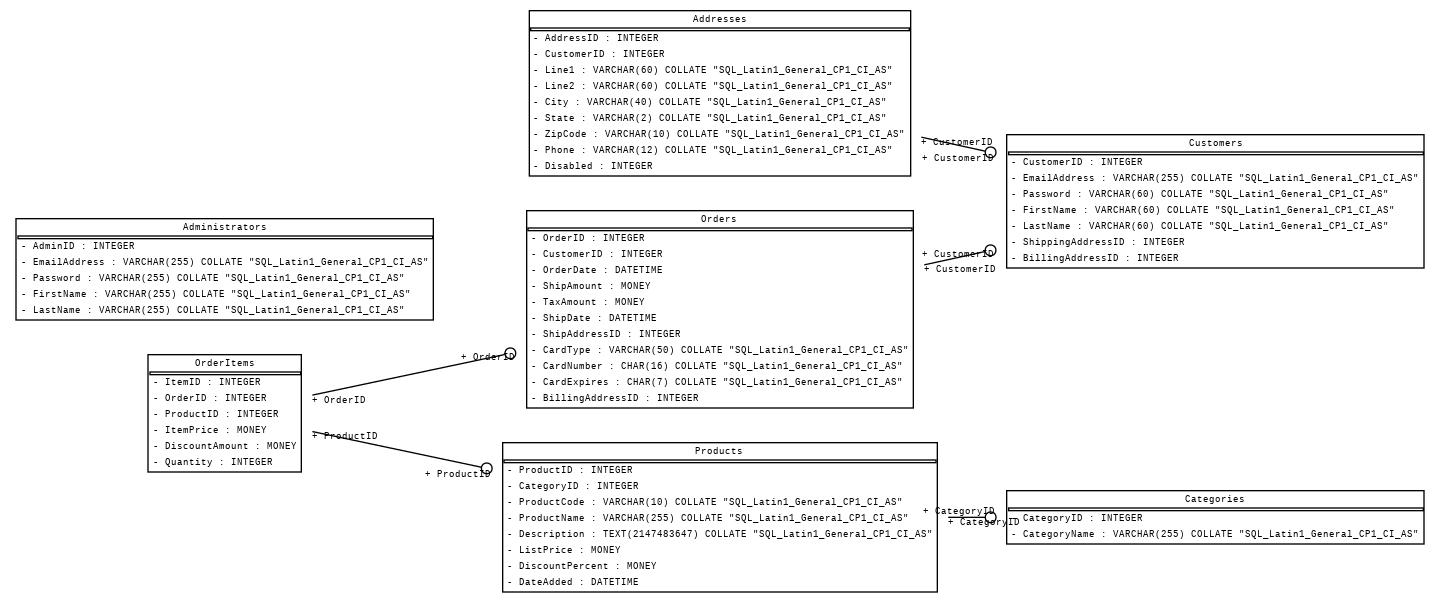

In [ ]:
from sqlalchemy import MetaData
from sqlalchemy_schemadisplay import create_schema_graph
from PIL import Image

# Assume 'pool' is your SQLAlchemy engine
metadata = MetaData()
metadata.bind = pool
metadata.reflect(bind=pool)

graph = create_schema_graph(
    metadata=metadata,
    show_datatypes=True,
    show_indexes=True,
    rankdir='LR',  # From left to right (LR), or top to bottom (TB)
    concentrate=False
)

# Create the output file (PDF, PNG, etc.)
output_file_path = "/content/drive/MyDrive/Projects/22-Database Management and Analytics using Google Cloud SQL/db_schema.png"
graph.write_png(output_file_path)

# Load the graph image using PIL (Pillow)
image = Image.open(output_file_path)

# Display the image inline in Jupyter Notebook or Google Colab
image